In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmaps
import scipy.stats as stats
import scipy as sp
from fitsio import FITS
import copy
import h5py
import getdist
from getdist import plots, MCSamples, loadMCSamples
from astropy.io import fits
from vega import VegaInterface, Wedge
from vega.parameters.param_utils import build_names
from vega.data import Data
from IPython.display import display, Markdown
%run -i "~/fitter2_tutorial/PolyChordLite/pypolychord/output.py"

%matplotlib inline

In [2]:
def make_chain(names, mean, cov):
    
    gaussian_samples = np.random.multivariate_normal(mean, cov, size=1000000)
    #print(names,gaussian_samples.shape)
    try:
        gaussian_samples_add=np.hstack((gaussian_samples,(gaussian_samples[:,2]/gaussian_samples[:,3]).reshape(len(gaussian_samples),1)))
        gaussian_samples_add=np.hstack((gaussian_samples_add,(gaussian_samples[:,4]).reshape(len(gaussian_samples),1)))
        gaussian_samples_add=np.hstack((gaussian_samples_add,(gaussian_samples[:,2]/gaussian_samples[:,3]*np.sqrt(1+2*gaussian_samples[:,3]/3+1/5*gaussian_samples[:,3]**2)).reshape(len(gaussian_samples),1)))
        gaussian_samples_add=np.hstack((gaussian_samples_add,(gaussian_samples[:,4]*np.exp(-0.001*gaussian_samples[:,5])).reshape(len(gaussian_samples),1)))
        #names=np.append(names,'bias_LYA')
        names=(list(names)+['bias_LYA']+['bias_F_hcd']+['bias_eff']+['bias_F_hcd-L_hcd'])
    except:
        gaussian_samples_add=np.hstack((gaussian_samples,(gaussian_samples[:,2]/gaussian_samples[:,3]).reshape(len(gaussian_samples),1)))
        gaussian_samples_add=np.hstack((gaussian_samples_add,(gaussian_samples[:,2]/gaussian_samples[:,3]*np.sqrt(1+2*gaussian_samples[:,3]/3+1/5*gaussian_samples[:,3]**2)).reshape(len(gaussian_samples),1)))

        #names=np.append(names,'bias_LYA')
        names=(list(names)+['bias_LYA']+['bias_eff'])
    labels = build_names(names)
    samples = MCSamples(samples=gaussian_samples_add, names = names, labels = [labels[name] for name in names])
    return samples

def get_res(path, auto=True, cross=True, lyb=False):
    hdul = fits.open(path)
    res = {}
    res['chisq'] = hdul[2].header['FVAL']
    res['mean'] = np.abs([val for val in hdul[2].data['values']])
    #res['cov'] = hdul[2].data['covariance']
    npars = len(hdul[2].data['names'])
    print(hdul[2].data['names'])
    cov=np.zeros((npars,npars))
    position=[]
    try:
        for par in ['bias_eta_LYA','bias_hcd']:
            position.append(np.where((hdul[2].data['names']==par))[0][0])
    except:
        print('no bias hcd')
    #print(hdul[2].data['covariance'])
    #print(hdul[2].data['errors'])
    for i in range(npars):
        for j in range(npars):
            if i in position or j in position:
                if i in position and j in position:
                    cov[i][j]=hdul[2].data['covariance'][:][i][j]
                else:
                    cov[i][j]=-hdul[2].data['covariance'][:][i][j]
            else:
                cov[i][j]=hdul[2].data['covariance'][:][i][j]
    #print(cov)
    res['cov'] = cov
    #print(hdul[2].data['errors'])
    res['pars'] = {hdul[2].data['names'][i]:{'val':hdul[2].data['values'][i], 'err':hdul[2].data['errors'][i]} for i in range(npars)}
    
    dim = 0
    if auto:
        data = hdul[1].data['lyalya_lyalya_DATA']
        mask = hdul[1].data['lyalya_lyalya_MASK']
        dim += len(data[mask])
        res['auto_data'] = data
        res['auto_model'] = hdul[1].data['lyalya_lyalya_MODEL']
    if cross:
        data = hdul[1].data['lyalya_qso_DATA']
        mask = hdul[1].data['lyalya_qso_MASK']
        dim += len(data[mask])
        res['cross_data'] = data
        res['cross_model'] = hdul[1].data['lyalya_qso_MODEL']
    if lyb:
        if auto:
            data = hdul[1].data['lyalya_lyalyb_DATA']
            mask = hdul[1].data['lyalya_lyalyb_MASK']
            dim += len(data[mask])
            res['autolyb_data'] = data
            res['autolyb_model'] = hdul[1].data['lyalya_lyalyb_MODEL']
        if cross:
            data = hdul[1].data['lyalyb_qso_DATA']
            mask = hdul[1].data['lyalyb_qso_MASK']
            dim += len(data[mask])
            res['crosslyb_data'] = data
            res['crosslyb_model'] = hdul[1].data['lyalyb_qso_MODEL']
    hdul.close()
    
    res['dim'] = dim
    res['npars'] = npars
    prob = 1 - stats.chi2.cdf(hdul[2].header['FVAL'], dim - npars)
    res['red_chisq'] = hdul[2].header['FVAL']/(dim - npars)
    res['prob'] = prob
    chain = make_chain(res['pars'].keys(), res['mean'], res['cov'])
    return res, chain

def make_chain_data(names, mean, cov):
    
    gaussian_samples = np.random.multivariate_normal(mean, cov, size=1000000)
    labels = build_names(names)
    samples = MCSamples(samples=gaussian_samples, names = names, labels = [labels[name] for name in names])
    return samples

def get_res_data(path, auto=True, cross=True, lyb=False):
    hdul = fits.open(path)
    res = {}
    res['chisq'] = hdul[2].header['FVAL']
    res['mean'] = np.abs([val for val in hdul[2].data['values']])
    #res['cov'] = hdul[2].data['covariance']
    npars = len(hdul[2].data['names'])
    print(hdul[2].data['names'])
    cov=np.zeros((npars,npars))
    position=[]
    try:
        for par in ['bias_eta_LYA','bias_hcd']:
            position.append(np.where((hdul[2].data['names']==par))[0][0])
    except:
        print('no bias hcd')
    #print(hdul[2].data['covariance'])
    #print(hdul[2].data['errors'])
    for i in range(npars):
        for j in range(npars):
            if i in position or j in position:
                if i in position and j in position:
                    cov[i][j]=hdul[2].data['covariance'][:][i][j]
                else:
                    cov[i][j]=-hdul[2].data['covariance'][:][i][j]
            else:
                cov[i][j]=hdul[2].data['covariance'][:][i][j]
    #print(cov)
    res['cov'] = cov
    #print(hdul[2].data['errors'])
    res['pars'] = {hdul[2].data['names'][i]:{'val':hdul[2].data['values'][i], 'err':hdul[2].data['errors'][i]} for i in range(npars)}
    
    dim = 0
    if auto:
        data = hdul[1].data['lyaxlya_DATA']
        mask = hdul[1].data['lyaxlya_MASK']
        dim += len(data[mask])
        res['auto_data'] = data
        res['auto_model'] = hdul[1].data['lyaxlya_MODEL']
    if cross:
        data = hdul[1].data['qsoxlya_DATA']
        mask = hdul[1].data['qsoxlya_MASK']
        dim += len(data[mask])
        res['cross_data'] = data
        res['cross_model'] = hdul[1].data['qsoxlya_MODEL']
    if lyb:
        if auto:
            data = hdul[1].data['lyalya_lyalyb_DATA']
            mask = hdul[1].data['lyalya_lyalyb_MASK']
            dim += len(data[mask])
            res['autolyb_data'] = data
            res['autolyb_model'] = hdul[1].data['lyalya_lyalyb_MODEL']
        if cross:
            data = hdul[1].data['lyalyb_qso_DATA']
            mask = hdul[1].data['lyalyb_qso_MASK']
            dim += len(data[mask])
            res['crosslyb_data'] = data
            res['crosslyb_model'] = hdul[1].data['lyalyb_qso_MODEL']
    hdul.close()
    
    res['dim'] = dim
    res['npars'] = npars
    prob = 1 - stats.chi2.cdf(hdul[2].header['FVAL'], dim - npars)
    res['red_chisq'] = hdul[2].header['FVAL']/(dim - npars)
    res['prob'] = prob
    chain = make_chain_data(res['pars'].keys(), res['mean'], res['cov'])
    return res, chain


# Mocks with no HCDs, 30 mocks, Thomas, for Saclay paper

In [13]:
f_cf=FITS('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_woutHCD/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_cf_kaiser_thomas-30.fits')
f_xcf=FITS('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_woutHCD/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_kaiser_thomas-30.fits')

In [35]:
import fitsio

fitsio.read_header('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_woutHCD/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_kaiser_thomas-30.fits',header=True)

/global/homes/t/tanting/fitter2_tutorial/PolyChordLite/pypolychord/output.py:3: DeprecationWarning: The keyword arguments '{'header': True}' are being ignored! This warning will be an error in a future version of `fitsio`!
  except ImportError:



SIMPLE  =                    T / conforms to FITS standard
BITPIX  =                    8 / array data type
NAXIS   =                    0 / number of array dimensions
EXTEND  =                    T / 

In [41]:
f_xcf[2].read_header()


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                   68 / length of dimension 1
NAXIS2  =                    5 / length of dimension 2
PCOUNT  =                    0 / number of group parameters
GCOUNT  =                    1 / number of groups
TFIELDS =                    4 / number of table fields
TTYPE1  = 'names'              / Names of sampled parameters
TFORM1  = '12A'                / 
TTYPE2  = 'values'             / Bestfit values of sampled parameters
TFORM2  = 'D'                  / 
TTYPE3  = 'errors'             / Errors around the bestfit
TFORM3  = 'D'                  / 
TTYPE4  = 'covariance'         / Covariance matrix around the bestfit
TFORM4  = '5D'                 / 
EXTNAME = 'BESTFIT'            / extension name
FVAL    =    3501.991395185471 / Bestfit chi^2 value
VALID   =                    T / Flag for valid fit
ACCURATE=

In [14]:
f_cf['BESTFIT']['names'][:],f_cf['BESTFIT']['values'][:],f_xcf['BESTFIT']['names'][:],f_xcf['BESTFIT']['values'][:]

(array(['ap', 'at', 'bias_eta_LYA', 'beta_LYA'], dtype='<U12'),
 array([ 1.00328244,  0.99469205, -0.20724168,  1.68657894]),
 array(['ap', 'at', 'bias_eta_LYA', 'beta_LYA', 'drp_QSO'], dtype='<U12'),
 array([ 0.99853944,  1.00039332, -0.18633991,  1.56379243, -0.03333047]))

In [21]:
ff = h5py.File('/global/cfs/cdirs/desi/science/lya/picca_on_mocks/saclay/v4.7/global/01_30/eboss-0.0/xcf_z_0_10-exp.h5','r')
ff.keys,ff['best fit'].attrs.keys()
        

(<bound method MappingHDF5.keys of <HDF5 file "xcf_z_0_10-exp.h5" (mode r)>>,
 <KeysViewHDF5 ['alpha_LYA', 'alpha_QSO', 'ap', 'at', 'bao_amp', 'beta_LYA', 'beta_QSO', 'bias_eta_LYA', 'bias_eta_QSO', 'cov[ap, ap]', 'cov[ap, at]', 'cov[ap, beta_LYA]', 'cov[ap, bias_eta_LYA]', 'cov[ap, drp_QSO]', 'cov[at, ap]', 'cov[at, at]', 'cov[at, beta_LYA]', 'cov[at, bias_eta_LYA]', 'cov[at, drp_QSO]', 'cov[beta_LYA, ap]', 'cov[beta_LYA, at]', 'cov[beta_LYA, beta_LYA]', 'cov[beta_LYA, bias_eta_LYA]', 'cov[beta_LYA, drp_QSO]', 'cov[bias_eta_LYA, ap]', 'cov[bias_eta_LYA, at]', 'cov[bias_eta_LYA, beta_LYA]', 'cov[bias_eta_LYA, bias_eta_LYA]', 'cov[bias_eta_LYA, drp_QSO]', 'cov[drp_QSO, ap]', 'cov[drp_QSO, at]', 'cov[drp_QSO, beta_LYA]', 'cov[drp_QSO, bias_eta_LYA]', 'cov[drp_QSO, drp_QSO]', 'drp_QSO', 'edm', 'fval', 'growth_rate', 'has_accurate_covar', 'has_covariance', 'has_made_posdef_covar', 'has_posdef_covar', 'has_reached_call_limit', 'has_valid_parameters', 'hesse_failed', 'is_above_max_edm', 'is_

In [42]:
ff['best fit'].attrs['bias_eta_LYA'],ff['best fit'].attrs['beta_LYA'],ff['best fit'].attrs['drp_QSO'],ff['best fit'].attrs['fval'],ff['best fit'].attrs['npar']

(array([-0.19023041,  0.00100065]),
 array([1.56426625, 0.01499881]),
 array([-0.03304479,  0.0350922 ]),
 3502.087521128392,
 5)

In [43]:
res_cf_mocks_kaiser_thomas_30, chain_cf_mocks_kaiser_thomas_30 = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_woutHCD/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_cf_kaiser_thomas-30.fits', lyb=False, cross=False)
res_xcf_mocks_kaiser_thomas_30, chain_xcf_mocks_kaiser_thomas_30 = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_woutHCD/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_kaiser_thomas-30.fits', lyb=False, cross=False)


['ap' 'at' 'bias_eta_LYA' 'beta_LYA']
no bias hcd
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'drp_QSO']
no bias hcd
Removed no burn in


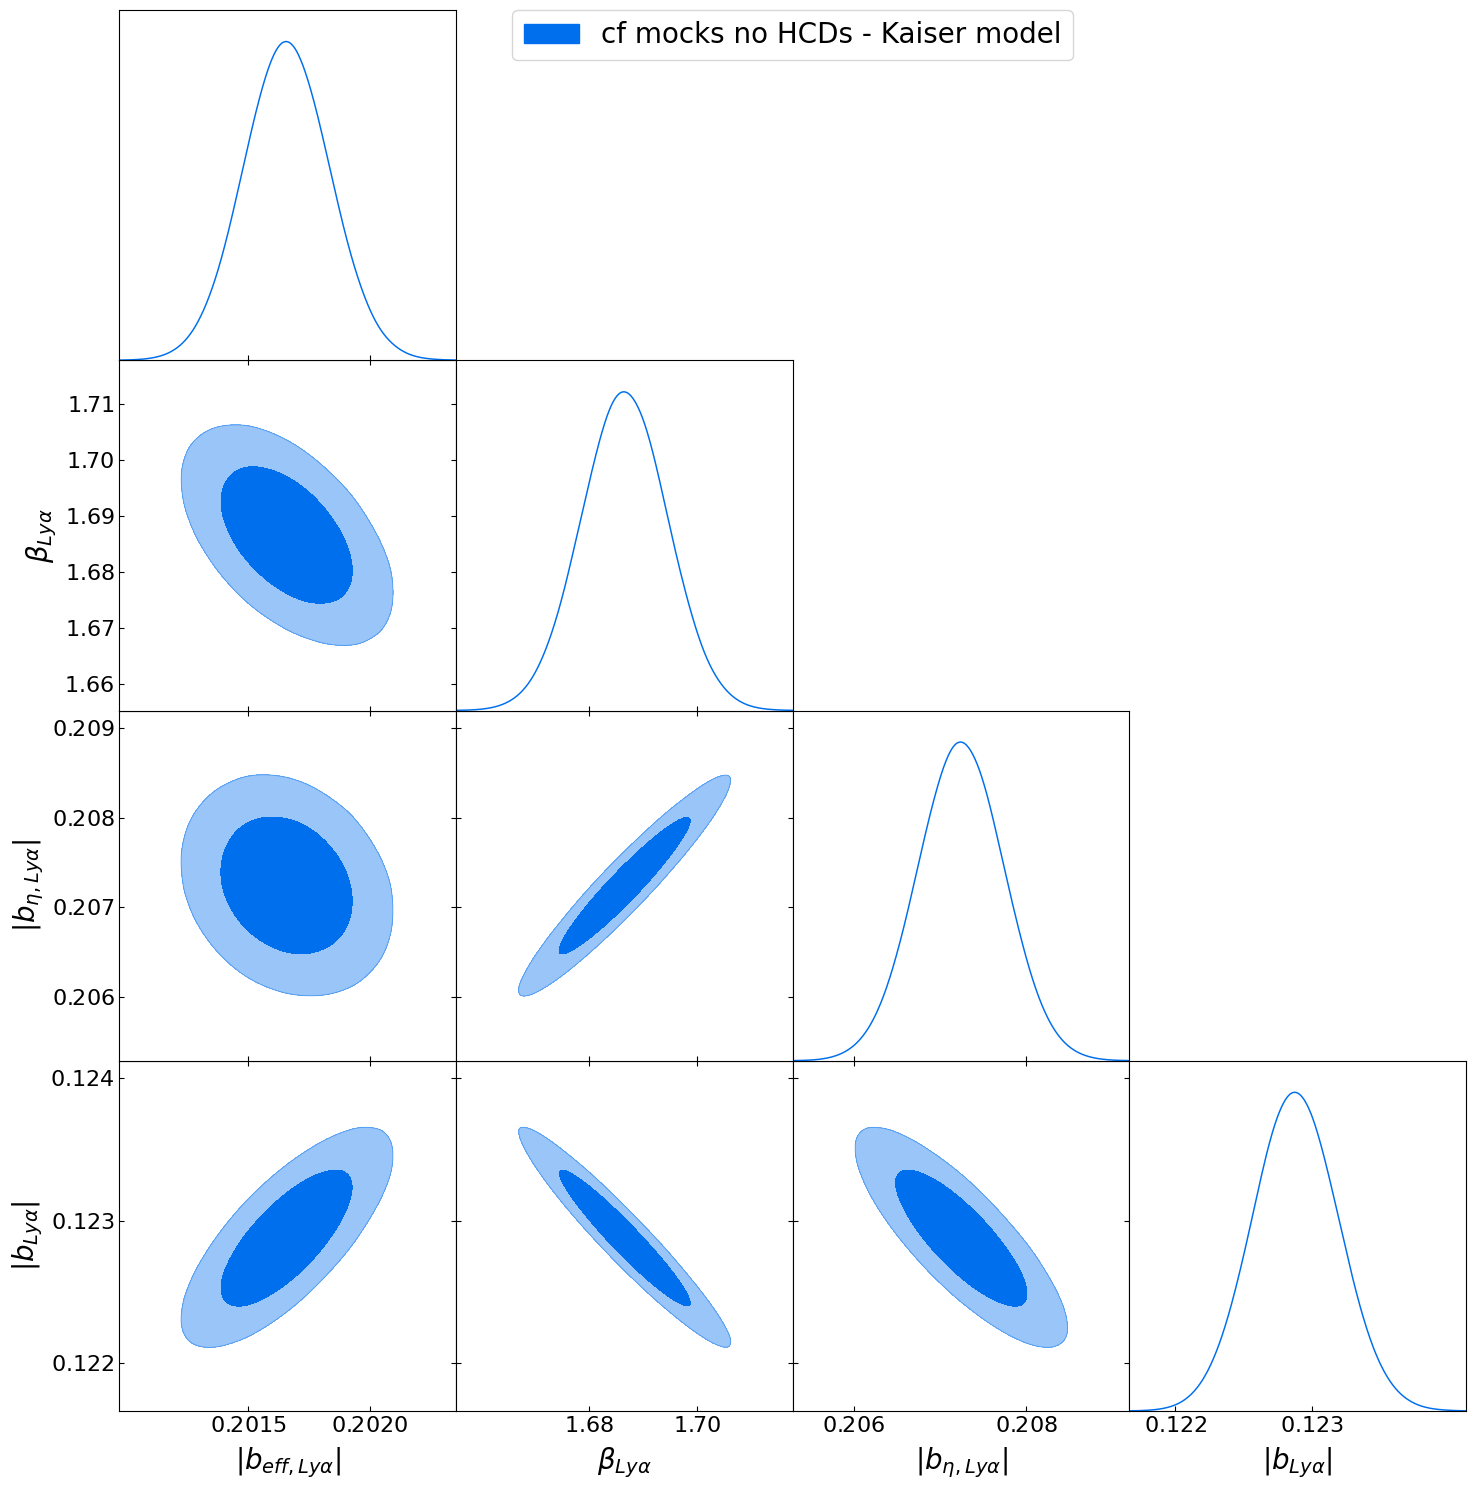

In [18]:

g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
pars_all = ['bias_eff', 'beta_LYA', 'bias_eta_LYA', 'bias_LYA']
g.triangle_plot([chain_cf_mocks_kaiser_thomas_30], pars_all, filled=True,
               legend_labels=['cf mocks no HCDs - Kaiser model'],
               param_limits={'alpha':[0.9,1.1]},framon=False)
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_cf_noHCDs_30mocks_thomas.pdf', bbox_inches='tight')

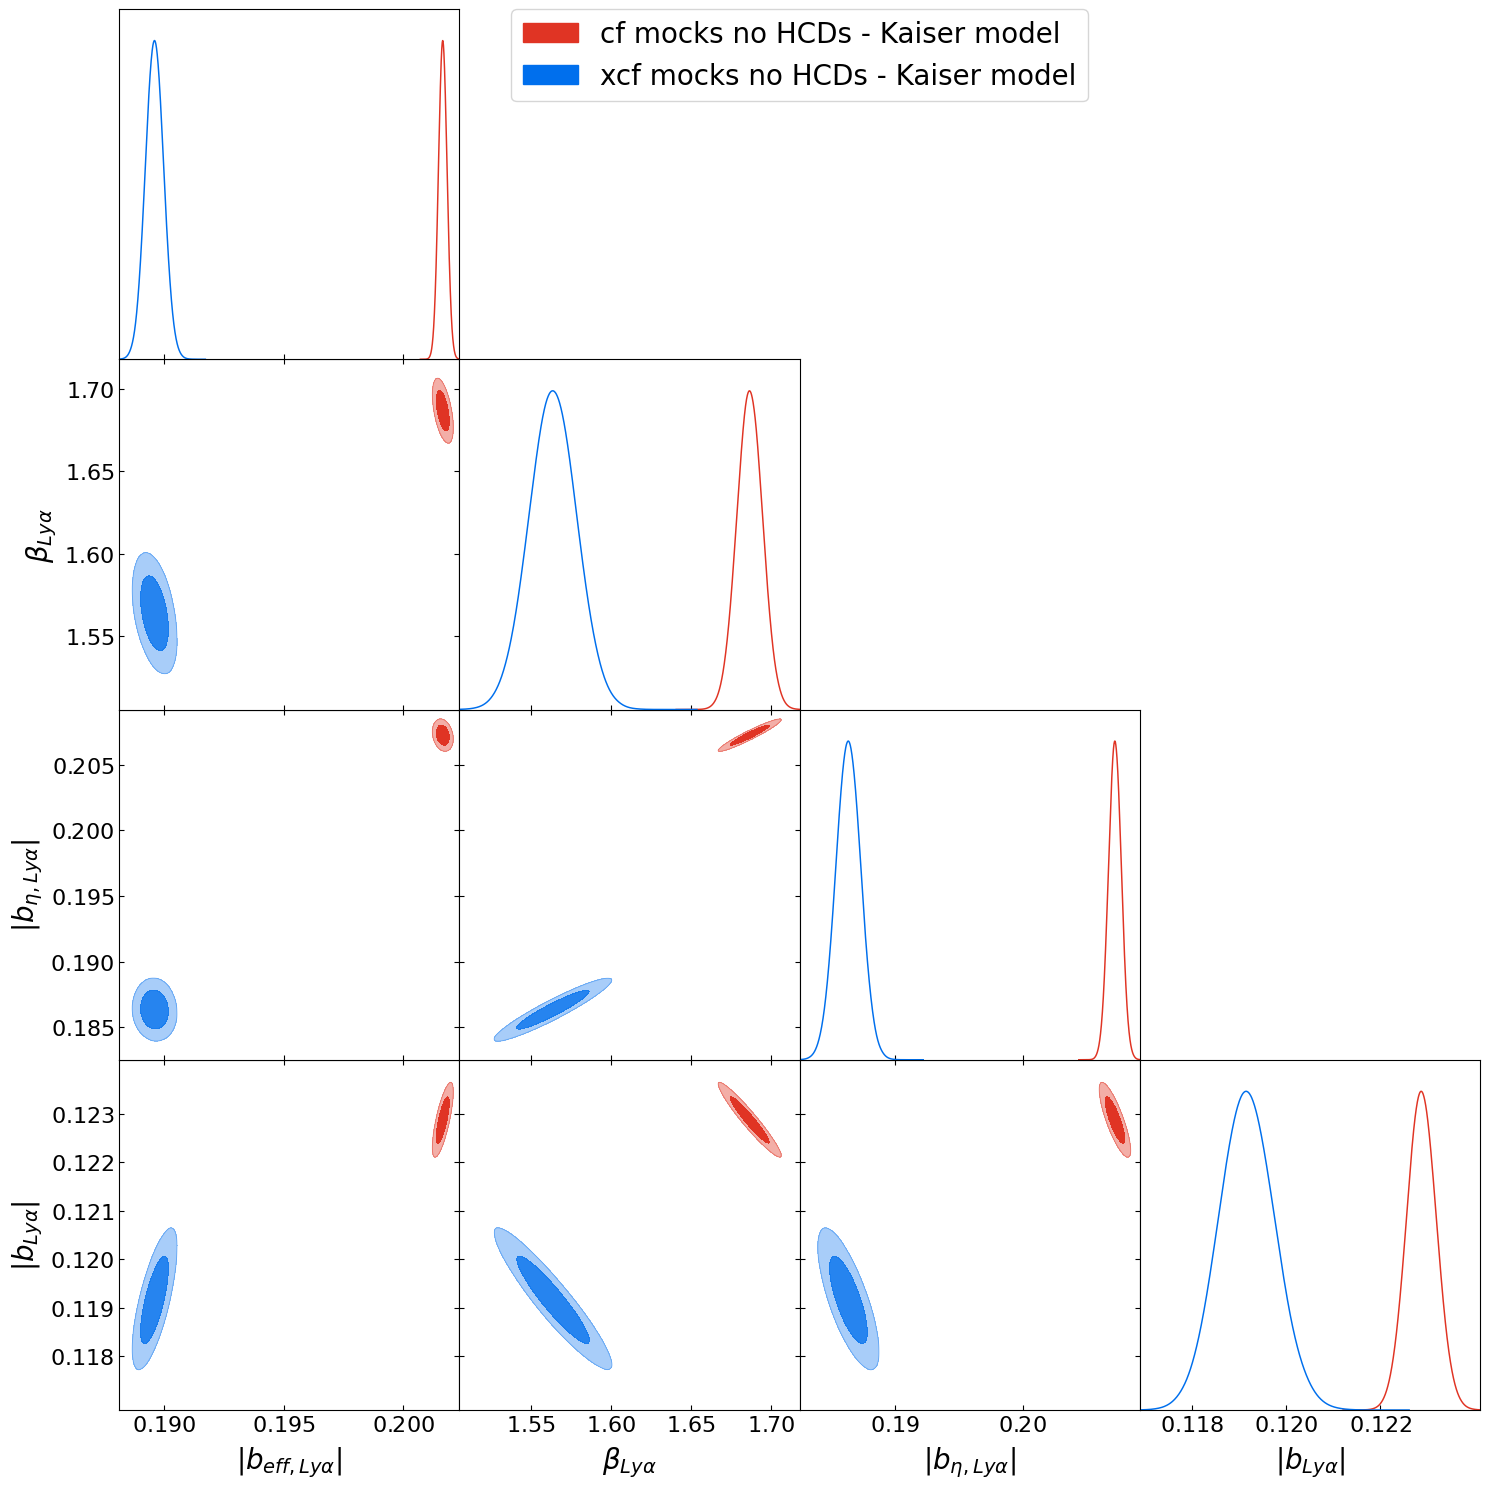

In [8]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
pars_all = ['bias_eff', 'beta_LYA', 'bias_eta_LYA', 'bias_LYA']

g.triangle_plot([chain_cf_mocks_kaiser_thomas_30,chain_xcf_mocks_kaiser_thomas_30], pars_all, filled=True,
               legend_labels=['cf mocks no HCDs - Kaiser model','xcf mocks no HCDs - Kaiser model'],
               param_limits={'alpha':[0.9,1.1]},framon=False)
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_cfxcf_noHCDs_30mocks_thomas.pdf', bbox_inches='tight')

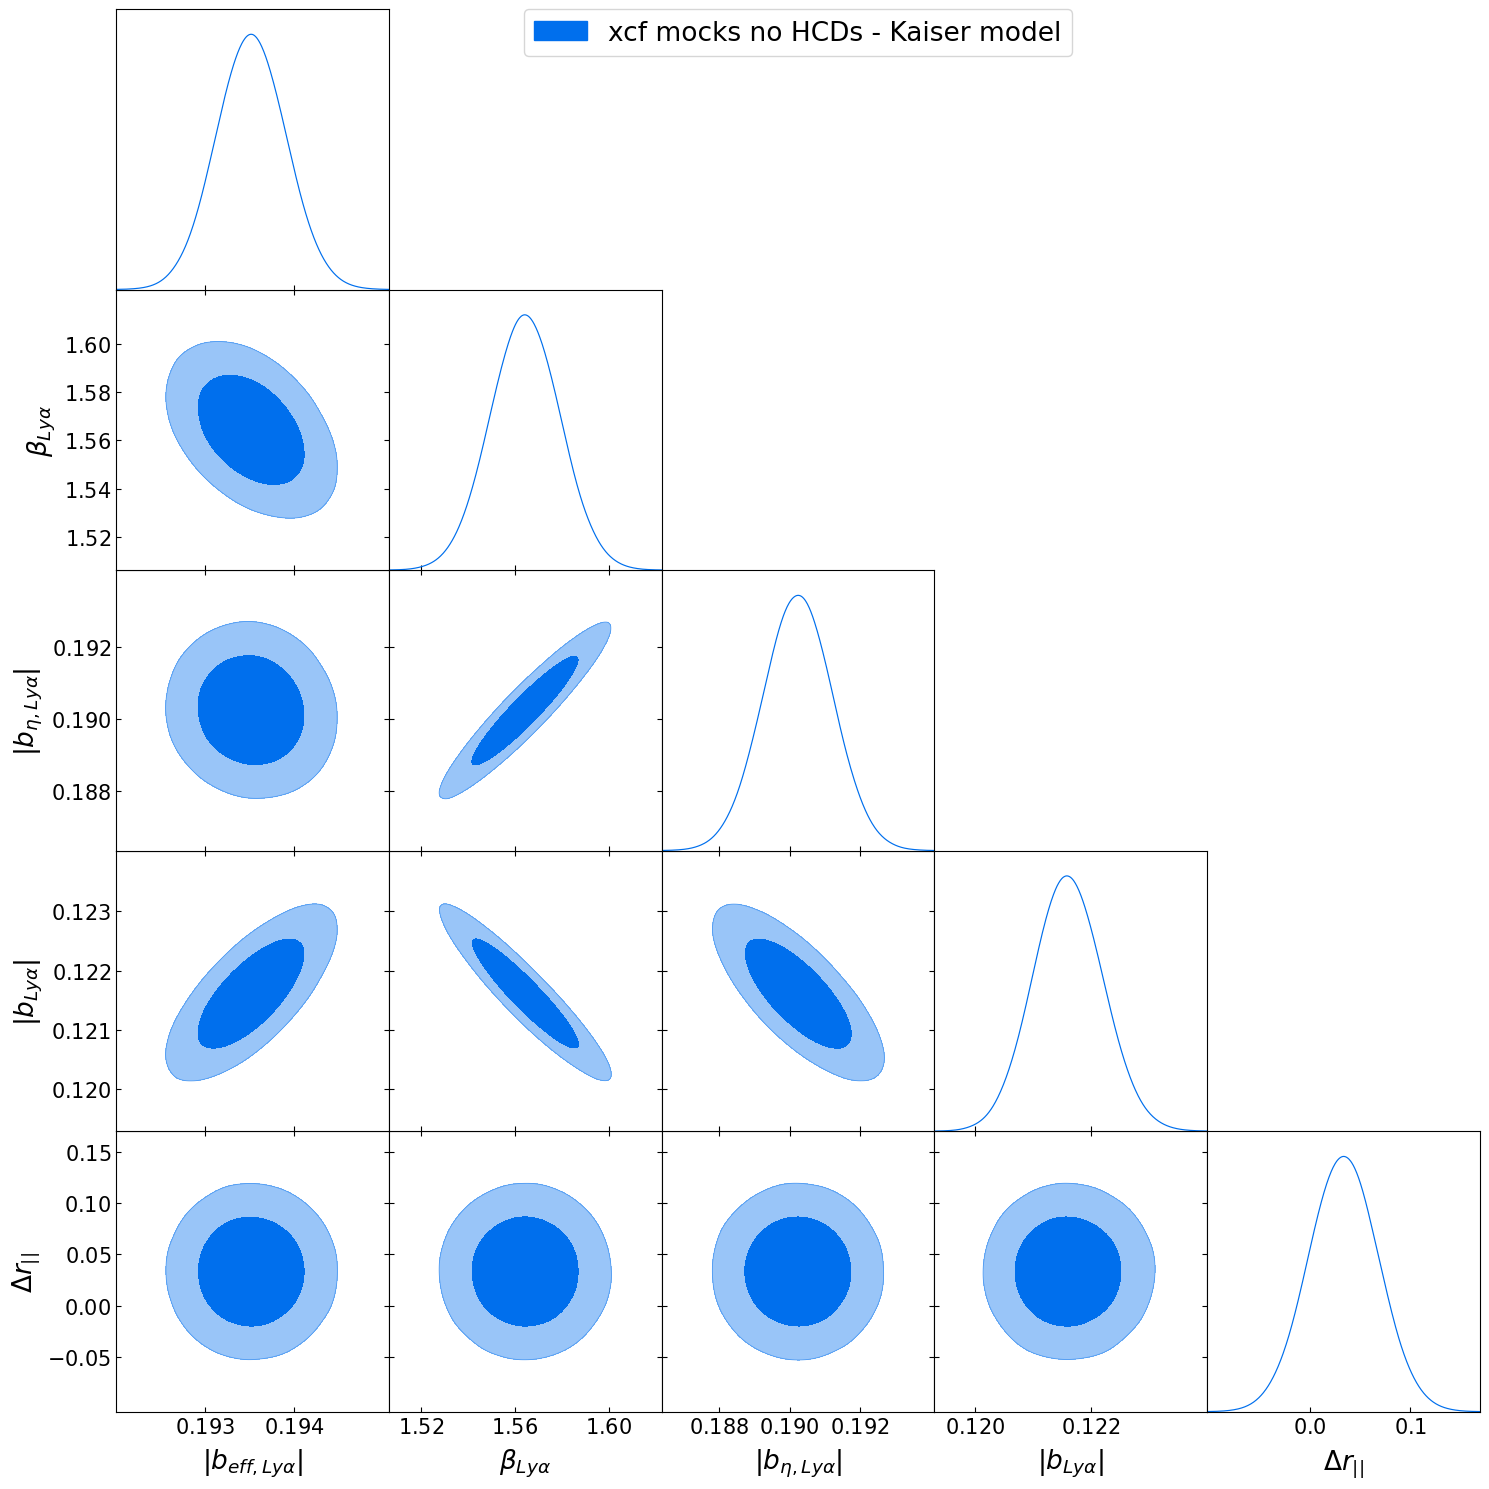

In [44]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
pars_all = ['bias_eff', 'beta_LYA', 'bias_eta_LYA', 'bias_LYA', 'drp_QSO']

g.triangle_plot([chain_xcf_mocks_kaiser_thomas_30], pars_all, filled=True,
               legend_labels=['xcf mocks no HCDs - Kaiser model'],
               param_limits={'alpha':[0.9,1.1]},framon=False)
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_xcf_noHCDs_30mocks_thomas.pdf', bbox_inches='tight')

# Mocks with no HCDs

In [36]:
res_cf_mocks_kaiser, chain_cf_mocks_kaiser = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_woutHCD/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_cf_kaiser.fits', lyb=False, cross=False)
res_xcf_mocks_kaiser, chain_xcf_mocks_kaiser = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_woutHCD/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_kaiser.fits', lyb=False, cross=False)
res_xcf_mocks_kaiser_rmin40, chain_xcf_mocks_kaiser_rmin40 = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_woutHCD/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_kaiser_rmin40.fits', lyb=False, cross=False)
res_cf_mocks_kaiser_masking, chain_cf_mocks_kaiser_masking = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_woutHCD_masking/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_cf_kaiser.fits', lyb=False, cross=False)

['ap' 'at' 'bias_eta_LYA' 'beta_LYA']
no bias hcd
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'drp_QSO']
no bias hcd
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'drp_QSO']
no bias hcd
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA']
no bias hcd
Removed no burn in


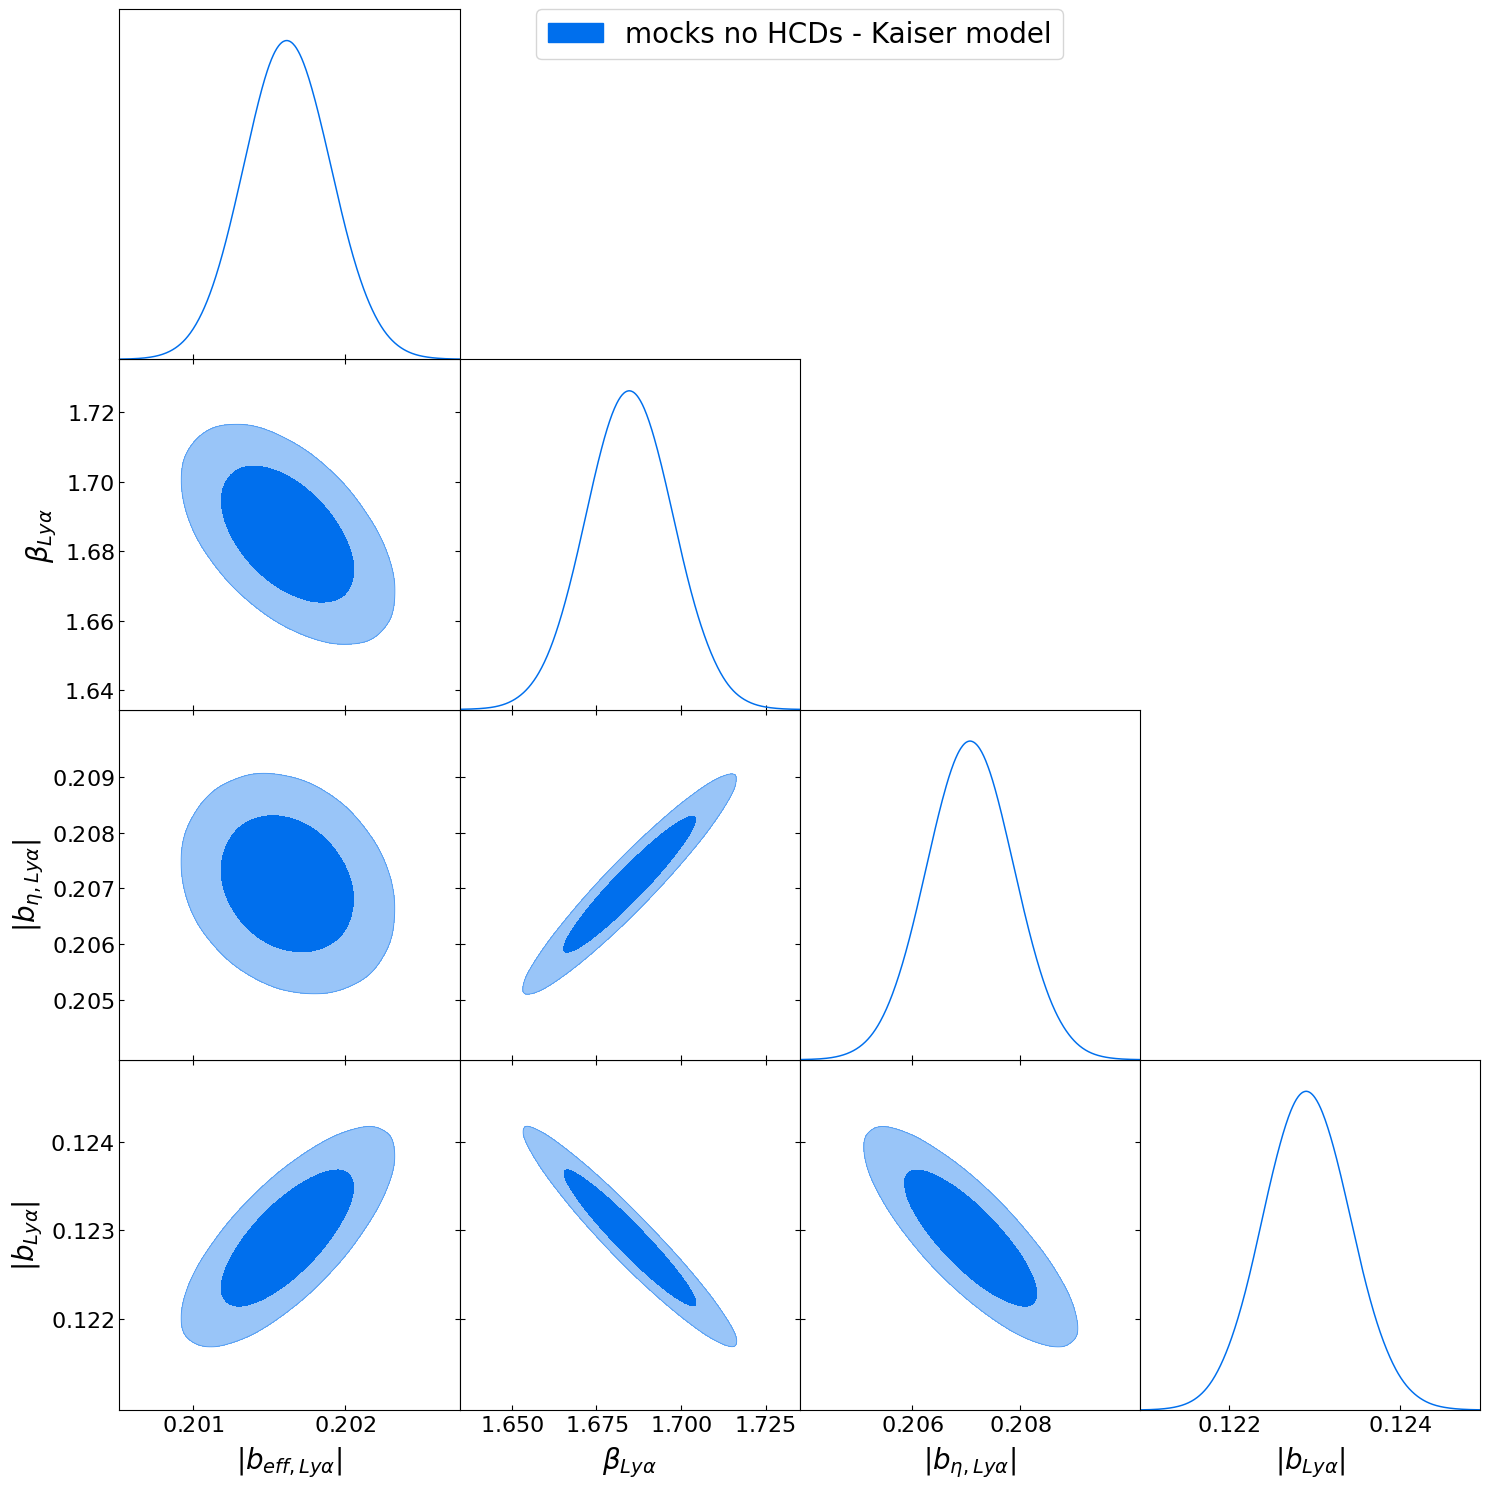

In [39]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
pars_all = ['bias_eff', 'beta_LYA', 'bias_eta_LYA', 'bias_LYA']

g.triangle_plot([chain_cf_mocks_kaiser], pars_all, filled=True,
               legend_labels=['mocks no HCDs - Kaiser model', 'mocks no HCDs masking - Kaiser model'],
               param_limits={'alpha':[0.9,1.1]},framon=False)
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_noHCDs.pdf', bbox_inches='tight')

# Mocks with HCDs

In [26]:
res_cf_mocks_masking_exp, chain_cf_mocks_masking_exp = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_cf_exp_fixed_betahcd.fits', lyb=False, cross=False)
res_cf_mocks_nomasking_exp, chain_cf_mocks_nomasking_exp = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_DLA_no_masking/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_cf_exp_fixed_betahcd.fits', lyb=False, cross=False)
res_cf_mocks_masking_voigt, chain_cf_mocks_masking_voigt = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_cf_voigt_fixed_betahcd.fits', lyb=False, cross=False)
res_cf_mocks_nomasking_voigt, chain_cf_mocks_nomasking_voigt = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_DLA_no_masking/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_cf_voigt_fixed_betahcd.fits', lyb=False, cross=False)

['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'L0_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'L0_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd']
Removed no burn in


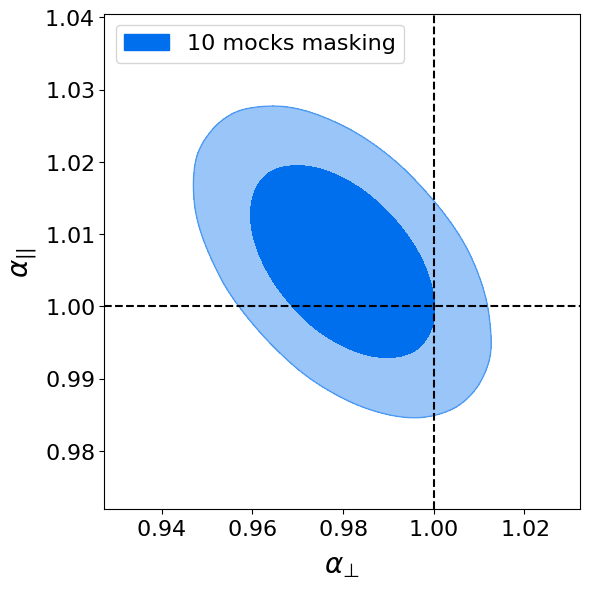

In [5]:
g = getdist.plots.getSubplotPlotter(width_inch=6)
g.settings.fontsize = 16
g.settings.legend_fontsize = 16
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
# pars_all = ['ap', 'at', 'bias_LYA', 'beta_LYA', 'par_sigma_smooth', 'per_sigma_smooth']

g.plot_2d([chain_auto_v1], ['at', 'ap'], filled=[True])

g.add_legend(['10 mocks masking'])
g.fig.axes[0].axvline(1, c='k', ls='--')
g.fig.axes[0].axhline(1, c='k', ls='--')

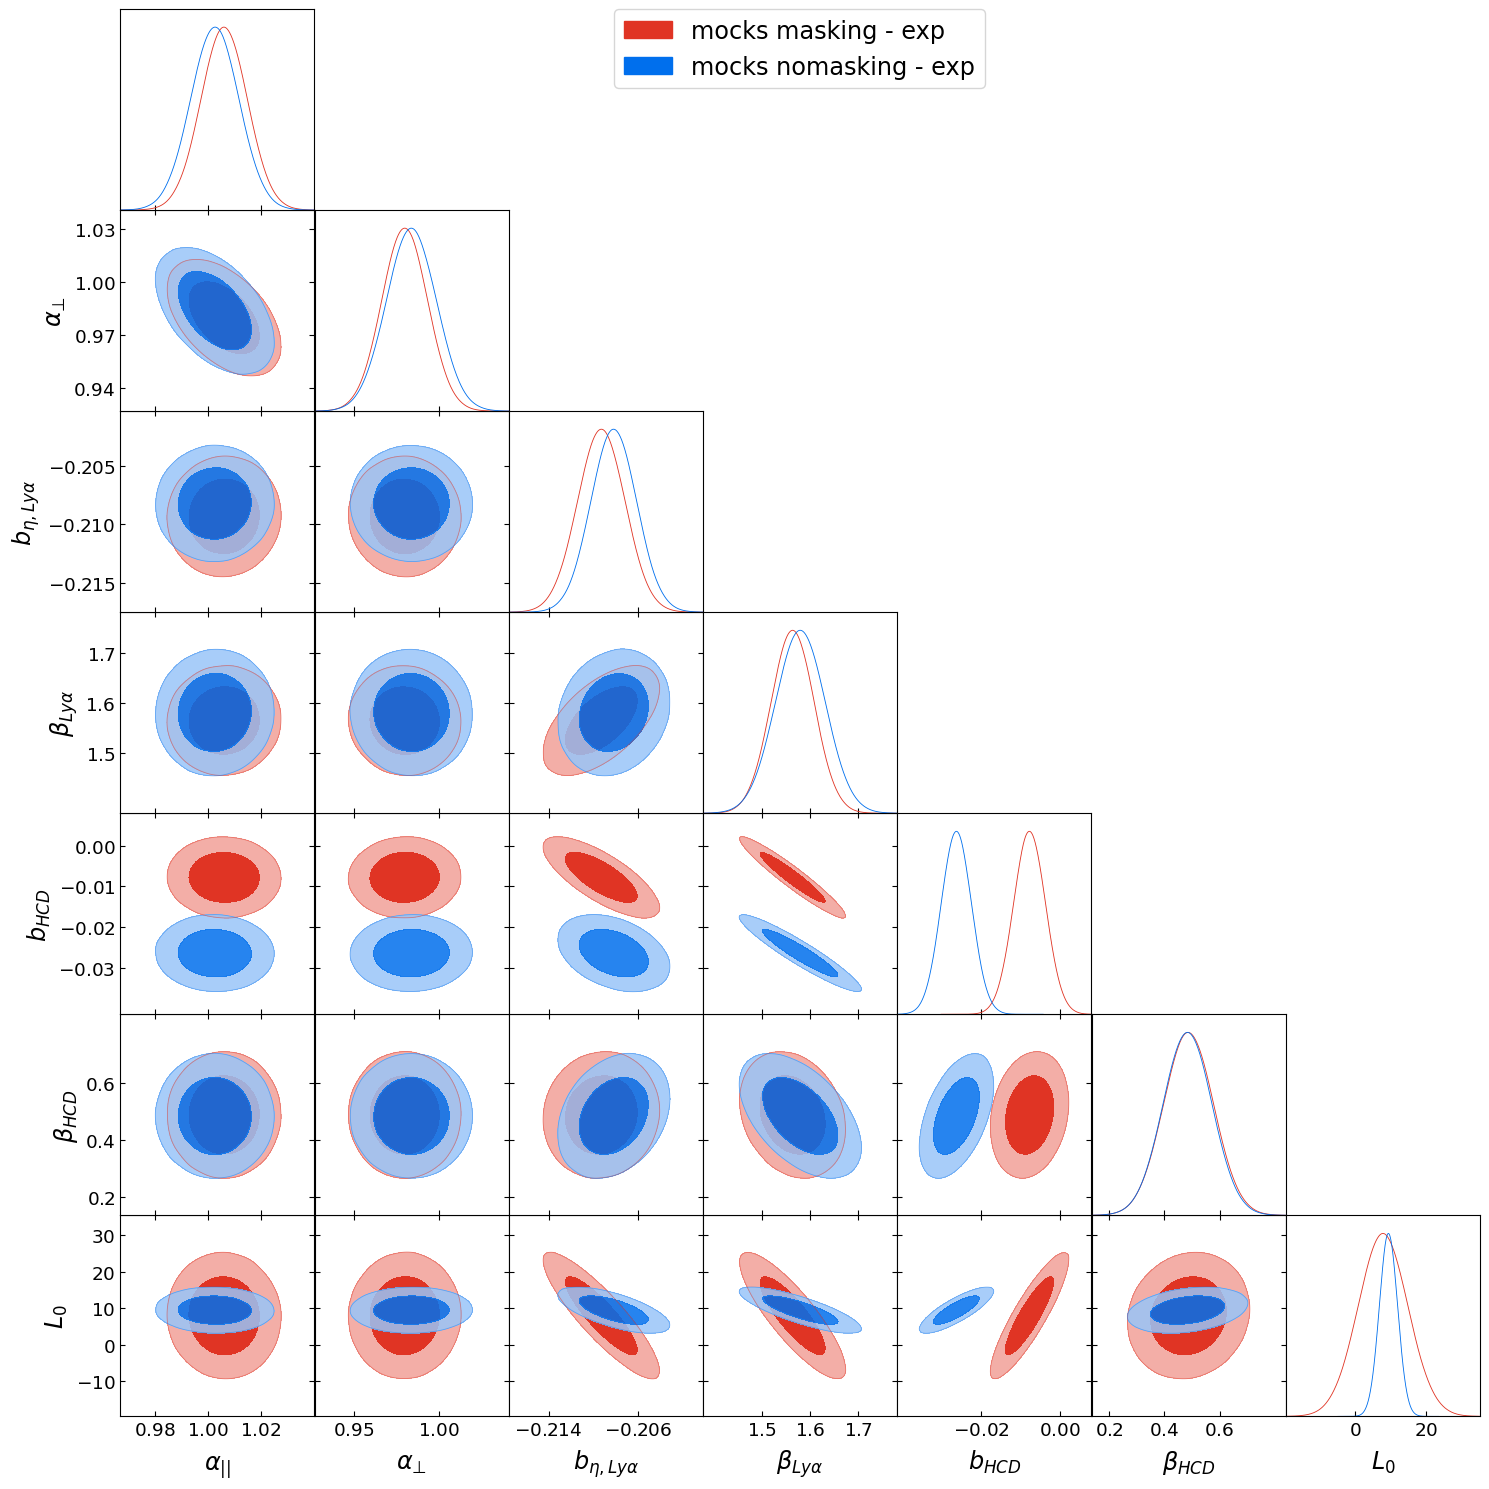

In [17]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
pars_all = ['ap', 'at', 'bias_eta_LYA', 'beta_LYA', 'bias_hcd', 'beta_hcd', 'L0_hcd']

g.triangle_plot([chain_cf_mocks_masking_exp, chain_cf_mocks_nomasking_exp], pars_all, filled=True,
               legend_labels=['mocks masking - exp', 'mocks nomasking - exp'],
               param_limits={'alpha':[0.9,1.1]})
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_exp.pdf', bbox_inches='tight')

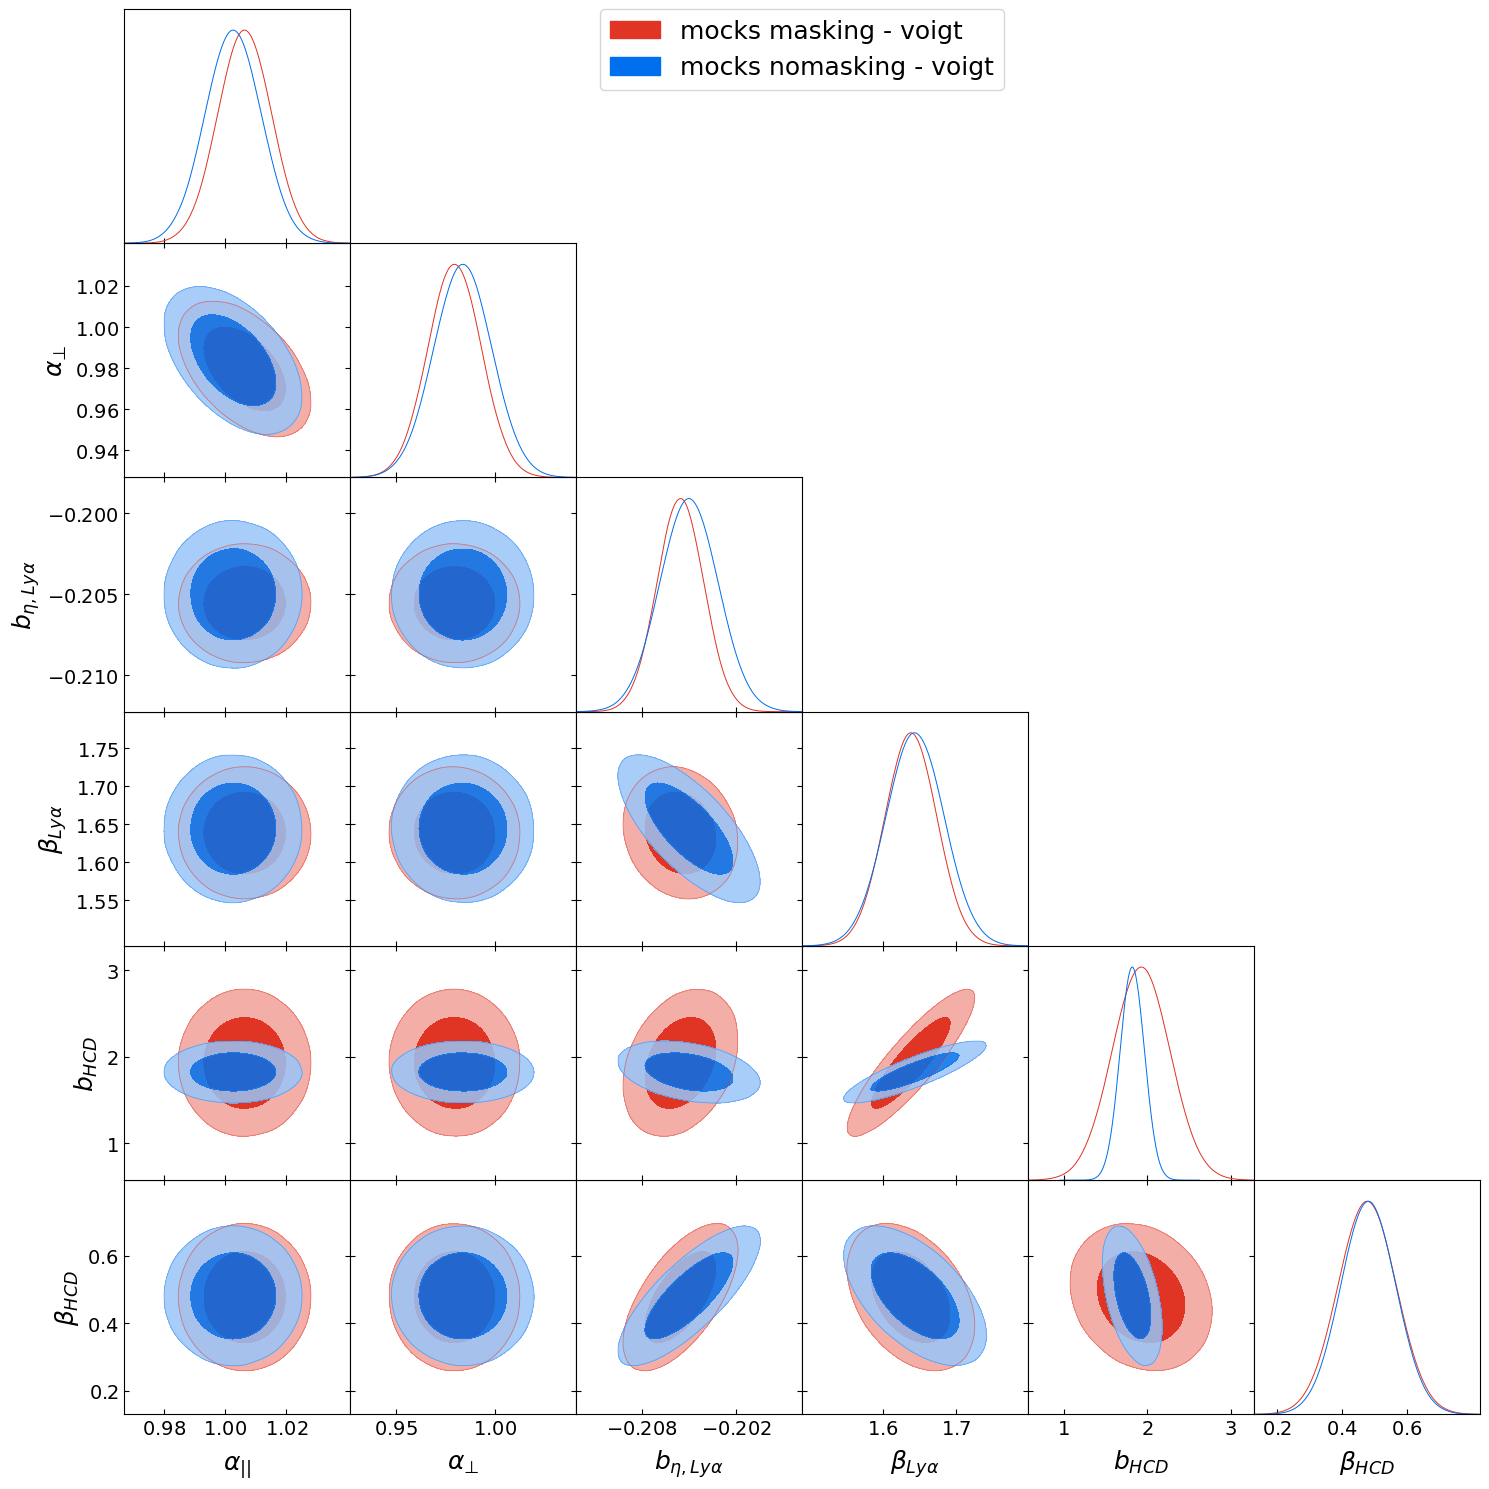

In [16]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
pars_all_voigt = ['ap', 'at', 'bias_eta_LYA', 'beta_LYA', 'bias_hcd', 'beta_hcd']

g.triangle_plot([chain_cf_mocks_masking_voigt, chain_cf_mocks_nomasking_voigt], pars_all_voigt, filled=True,
               legend_labels=['mocks masking - voigt', 'mocks nomasking - voigt'],
               param_limits={'alpha':[0.9,1.1]})
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_voigt.pdf', bbox_inches='tight')

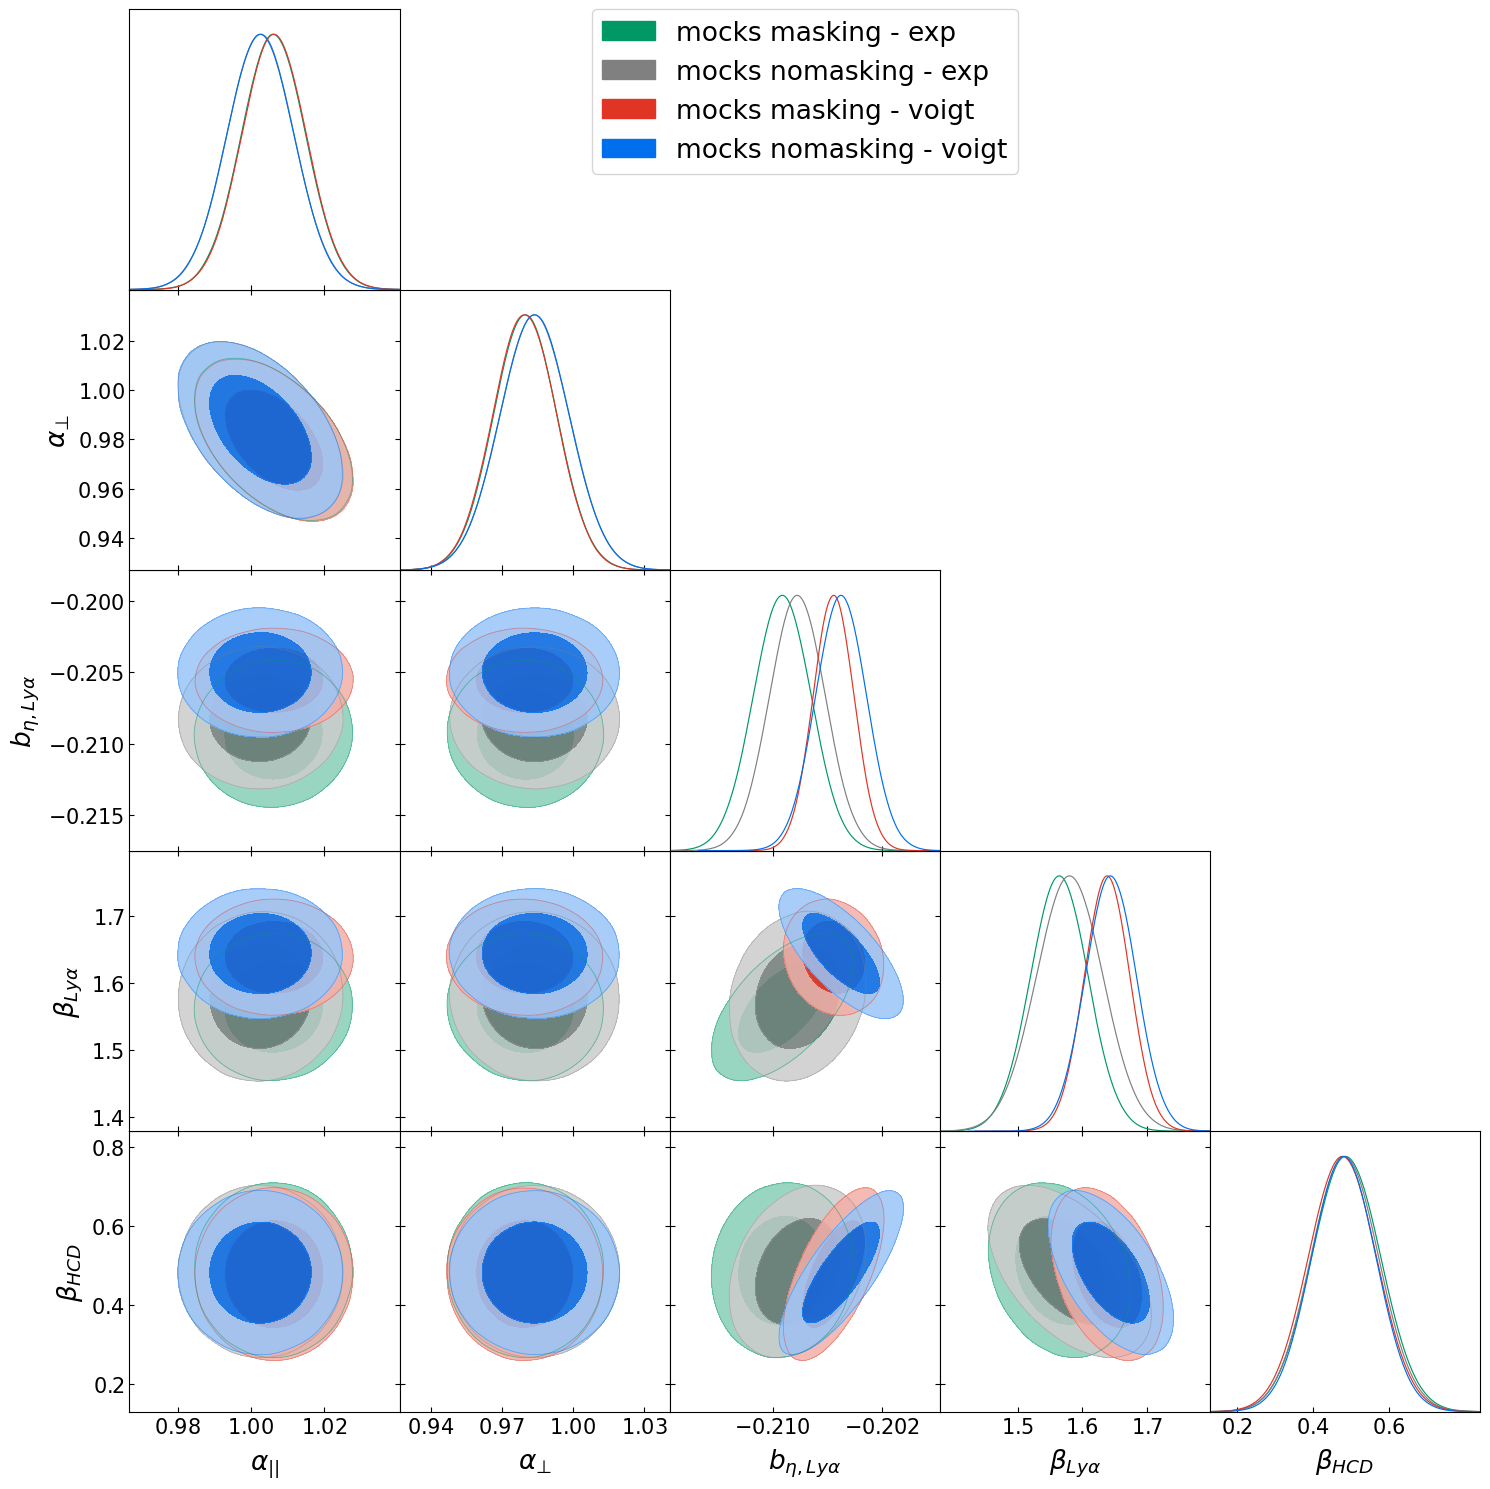

In [20]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
pars_all = ['ap', 'at', 'bias_eta_LYA', 'beta_LYA', 'beta_hcd']

g.triangle_plot([chain_cf_mocks_masking_exp, chain_cf_mocks_nomasking_exp,chain_cf_mocks_masking_voigt, chain_cf_mocks_nomasking_voigt], pars_all, filled=True,
               legend_labels=['mocks masking - exp', 'mocks nomasking - exp','mocks masking - voigt', 'mocks nomasking - voigt'],
               param_limits={'alpha':[0.9,1.1]})
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_exp+voigt.pdf', bbox_inches='tight')

# Fixing beta_hcd

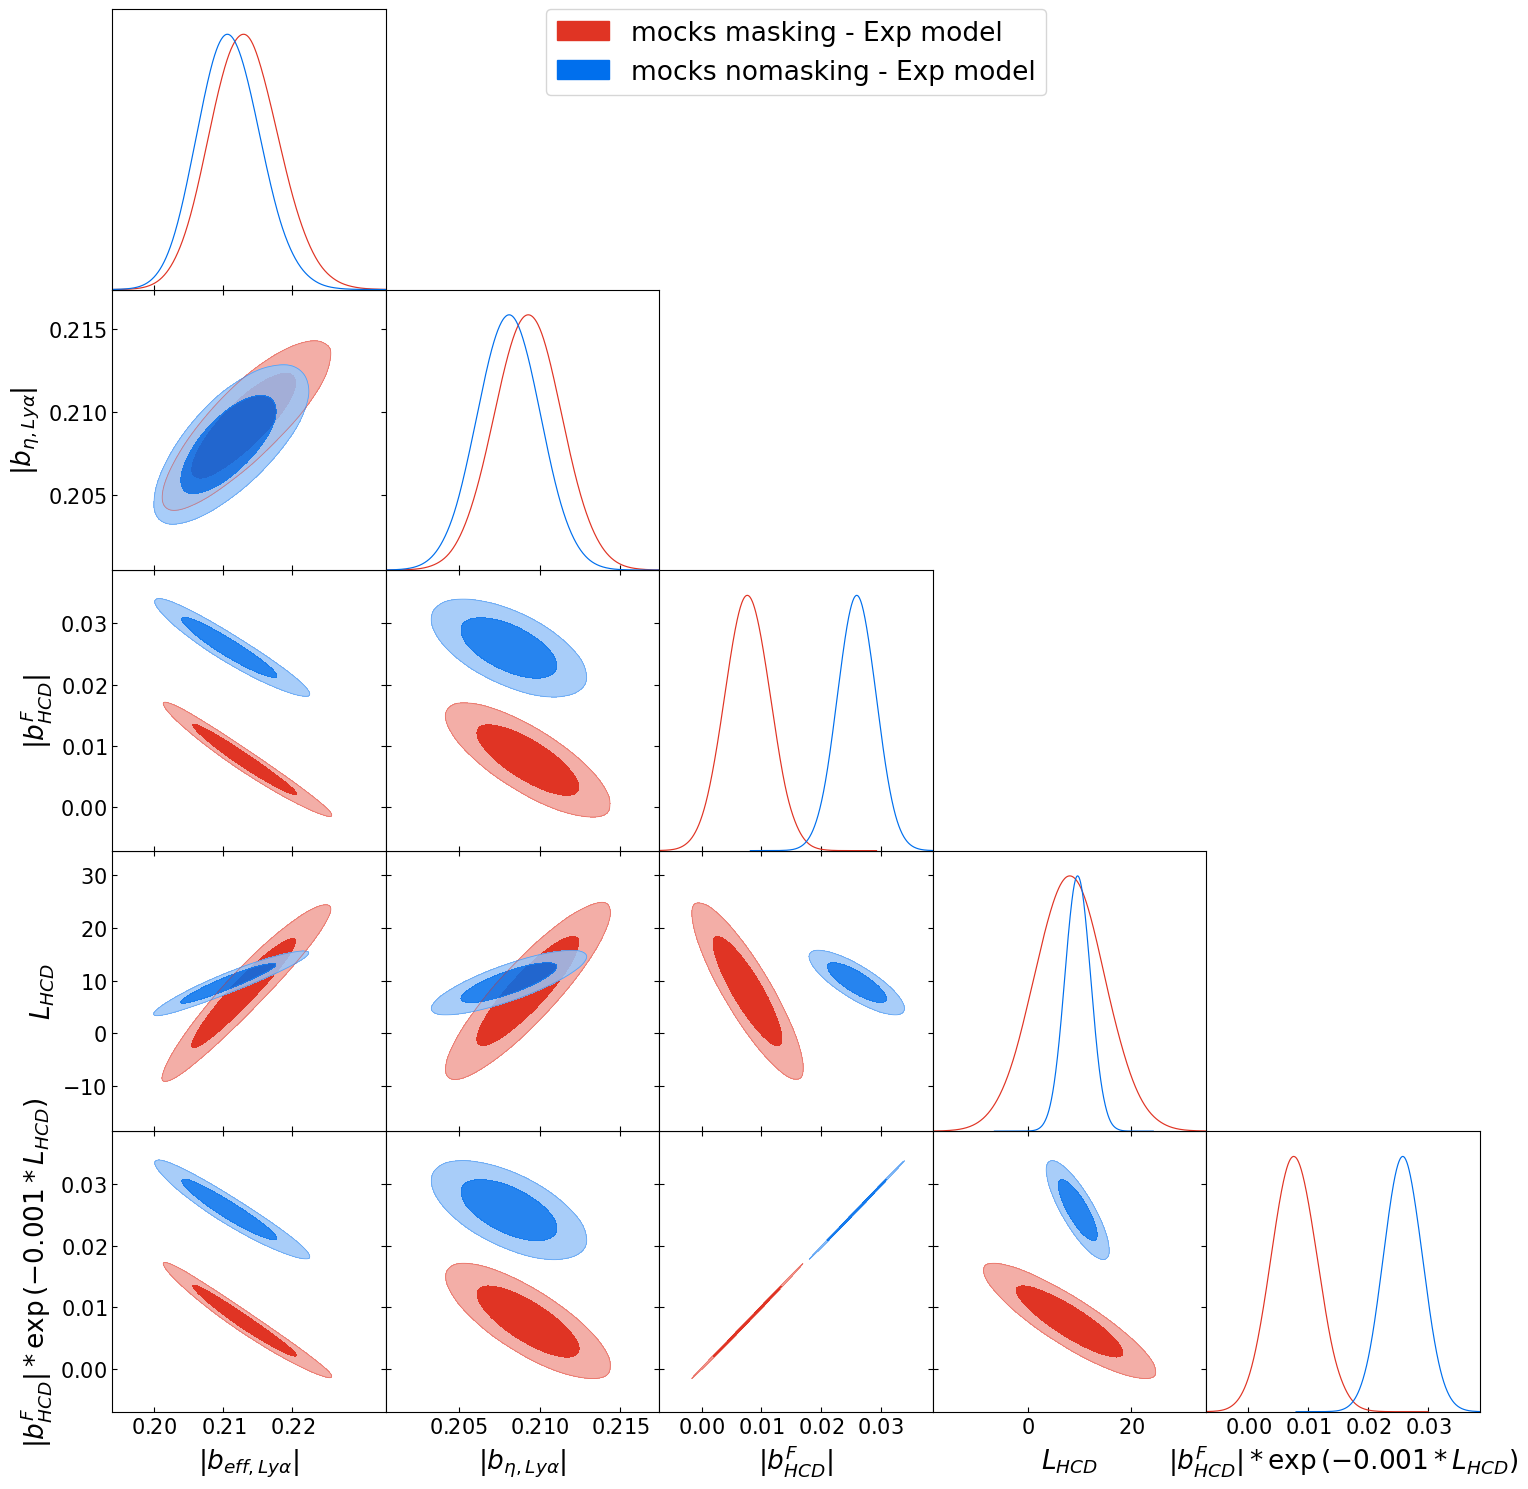

In [68]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
pars_all = ['bias_eff', 'bias_eta_LYA', 'bias_F_hcd', 'L0_hcd','bias_F_hcd-L_hcd']

g.triangle_plot([chain_cf_mocks_masking_exp, chain_cf_mocks_nomasking_exp], pars_all, filled=True,
               legend_labels=['mocks masking - Exp model', 'mocks nomasking - Exp model'],
               param_limits={'alpha':[0.9,1.1]},framon=False)
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_exp2.pdf', bbox_inches='tight')


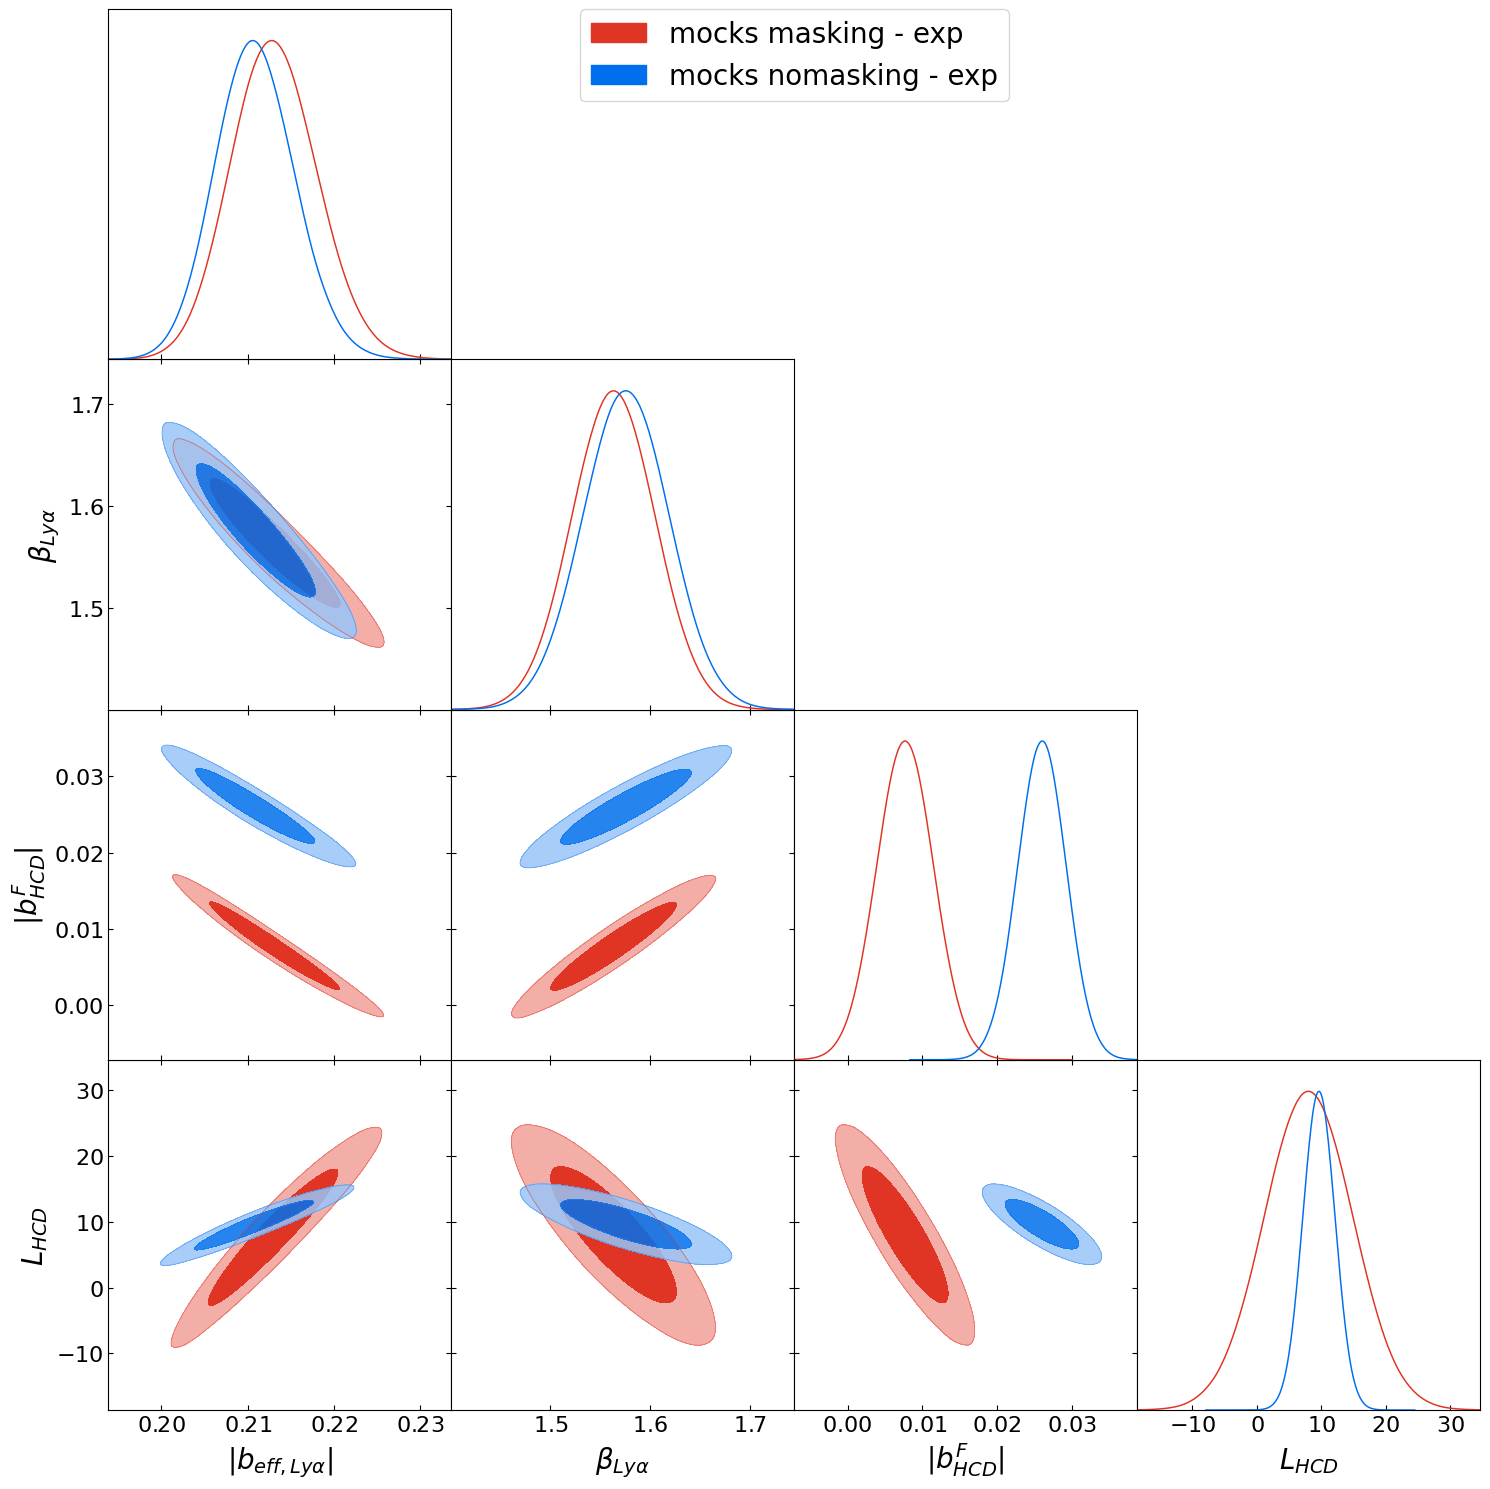

In [7]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
pars_all = ['bias_eff', 'beta_LYA', 'bias_F_hcd', 'L0_hcd']

g.triangle_plot([chain_cf_mocks_masking_exp, chain_cf_mocks_nomasking_exp], pars_all, filled=True,
               legend_labels=['mocks masking - exp', 'mocks nomasking - exp'],
               param_limits={'alpha':[0.9,1.1]})
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_exp2.pdf', bbox_inches='tight')

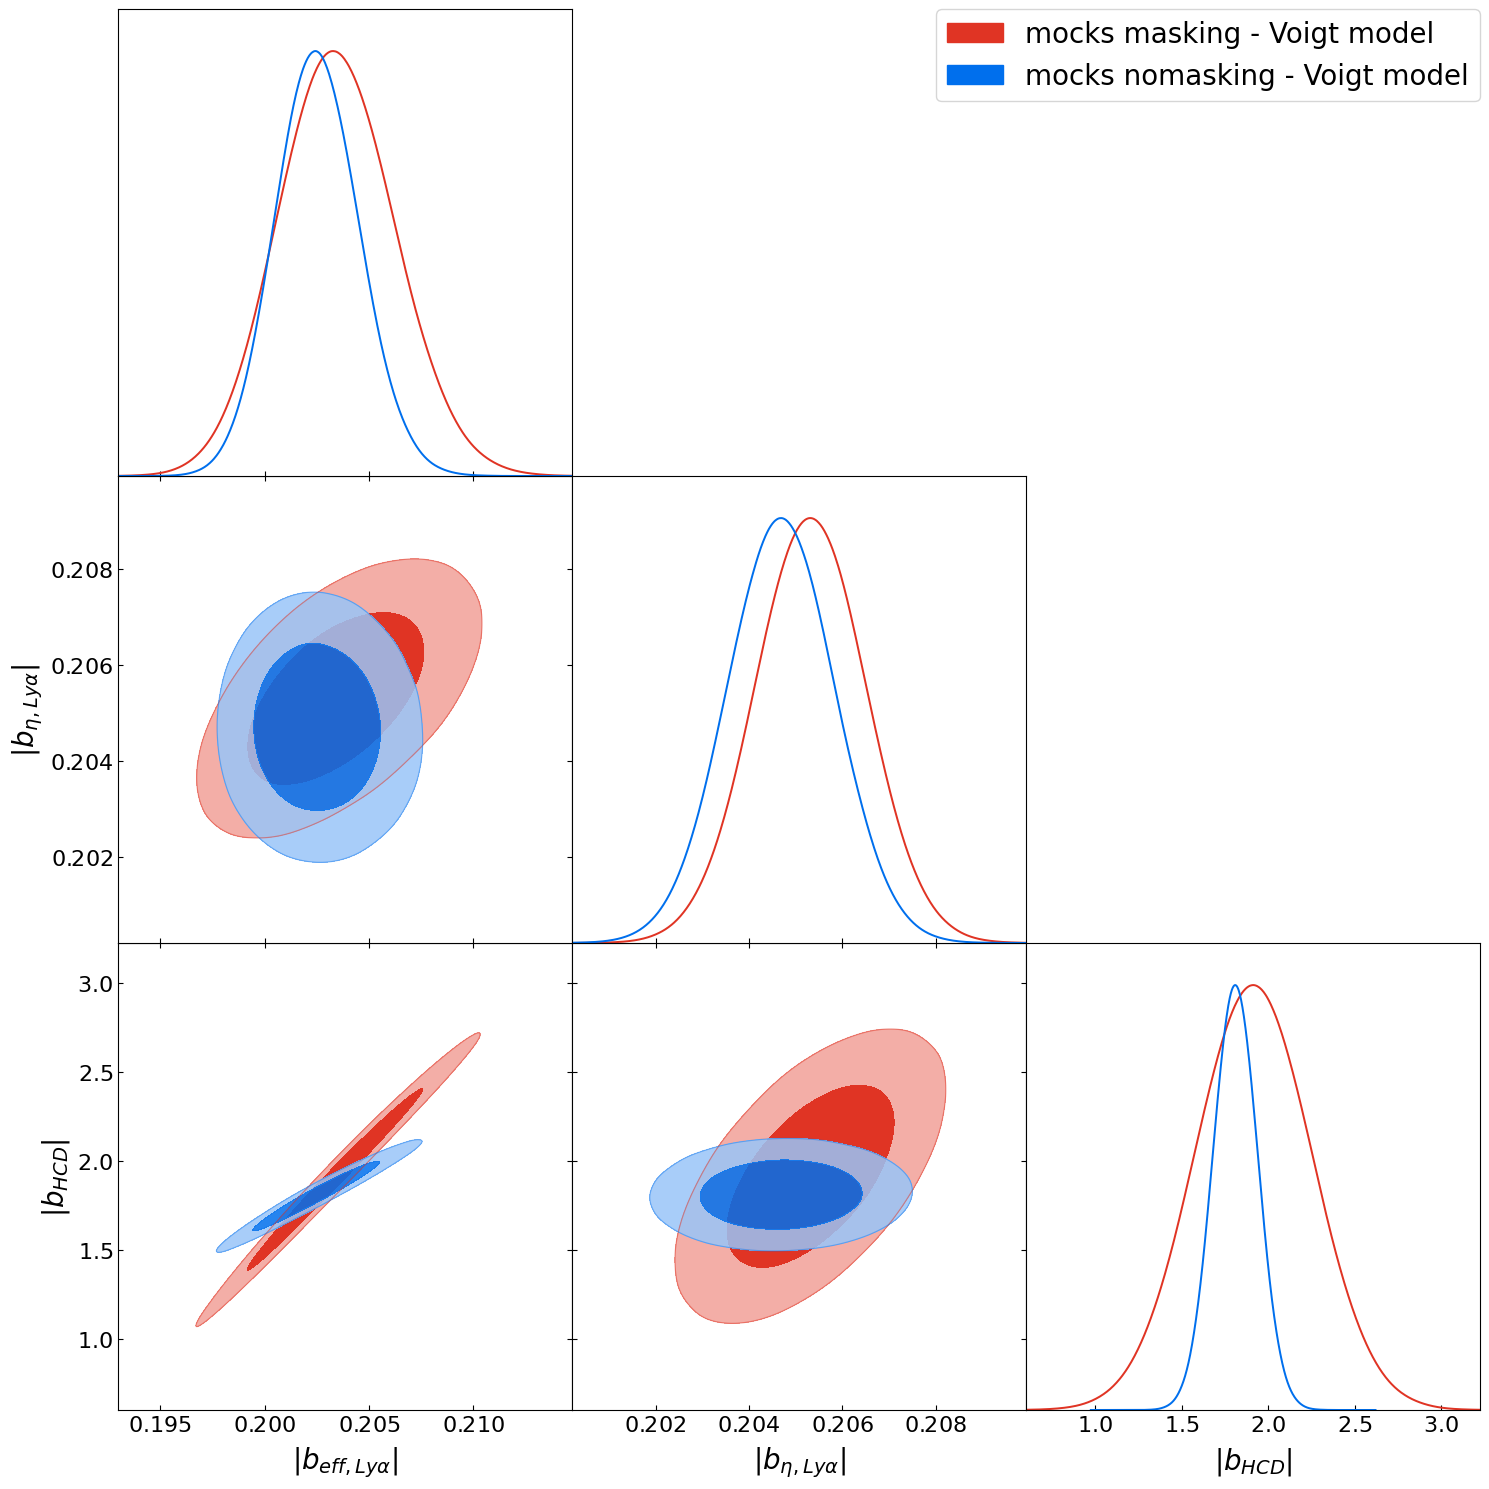

In [35]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
pars_all_voigt = ['bias_eff', 'bias_eta_LYA', 'bias_hcd']

g.triangle_plot([chain_cf_mocks_masking_voigt, chain_cf_mocks_nomasking_voigt], pars_all_voigt, filled=True,
               legend_labels=['mocks masking - Voigt model', 'mocks nomasking - Voigt model'],
               param_limits={'alpha':[0.9,1.1]},framon=False)
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_voigt2.pdf', bbox_inches='tight')

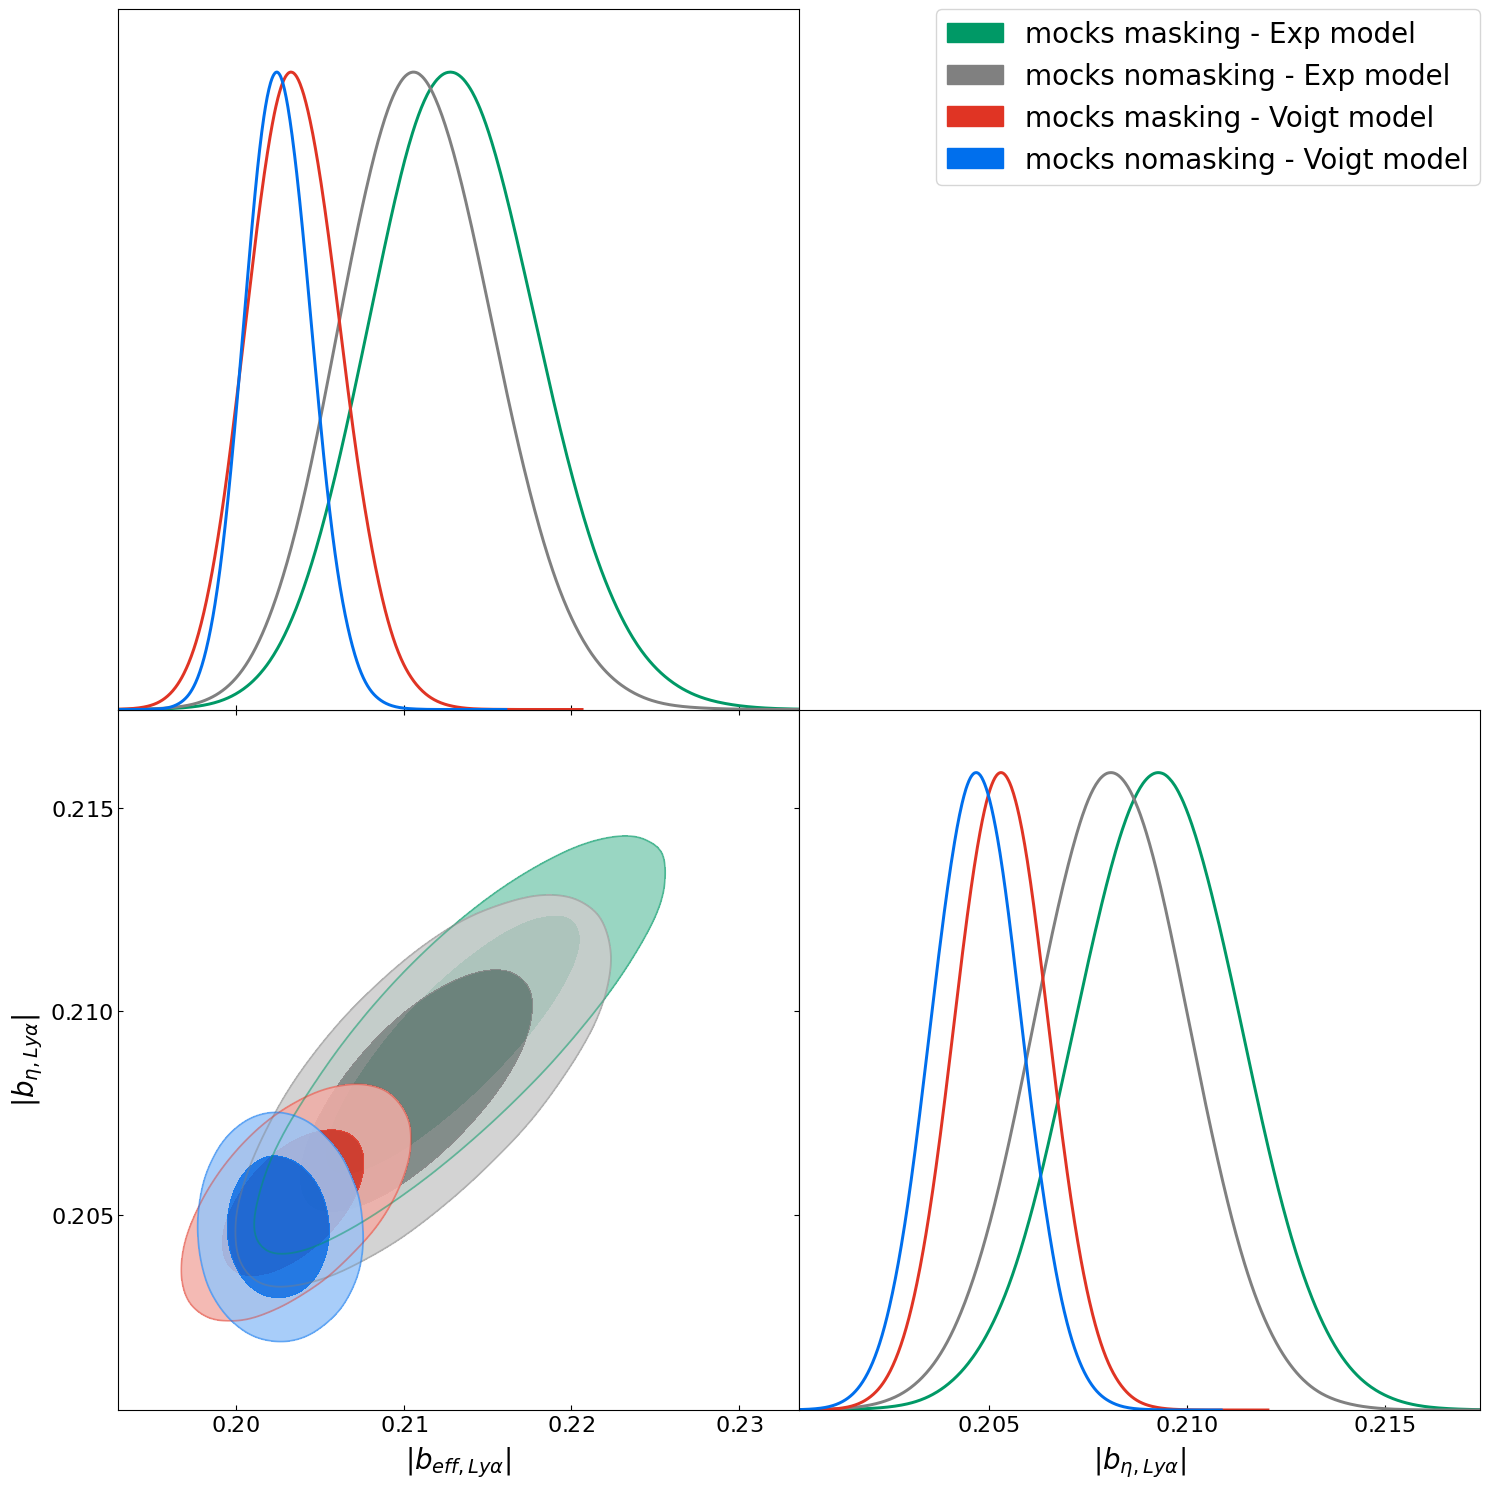

In [36]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
pars_all = ['bias_eff', 'bias_eta_LYA']

g.triangle_plot([chain_cf_mocks_masking_exp, chain_cf_mocks_nomasking_exp,chain_cf_mocks_masking_voigt, chain_cf_mocks_nomasking_voigt], pars_all, filled=True,
               legend_labels=['mocks masking - Exp model', 'mocks nomasking - Exp model','mocks masking - Voigt model', 'mocks nomasking - Voigt model'],
               param_limits={'alpha':[0.9,1.1]},framon=False)
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_exp+voigt2.pdf', bbox_inches='tight')

# Cross correlation

In [57]:
res_xcf_mocks_masking_exp_noprior_rmin40, chain_xcf_mocks_masking_exp_noprior_rmin40 = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_exp_noprior_rmin40.fits', lyb=False, cross=False)


['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'drp_QSO' 'beta_hcd'
 'L0_hcd']
[8.63293584e-03 1.06693351e-02 3.94662340e-03 4.99152684e-02
 5.11081774e-03 1.68686064e-01 1.99806959e+00 3.29537747e+01]
Removed no burn in


In [50]:
res_xcf_mocks_masking_exp, chain_xcf_mocks_masking_exp = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_exp.fits', lyb=False, cross=False)
res_xcf_mocks_nomasking_exp, chain_xcf_mocks_nomasking_exp = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_DLA_no_masking/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_exp.fits', lyb=False, cross=False)
res_xcf_mocks_masking_exp_noprior_rmin40, chain_xcf_mocks_masking_exp_noprior_rmin40 = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_exp_noprior_rmin40.fits', lyb=False, cross=False)
res_xcf_mocks_nomasking_exp_noprior_rmin40, chain_xcf_mocks_nomasking_exp_noprior_rmin40 = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_DLA_no_masking/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_exp_noprior_rmin40.fits', lyb=False, cross=False)

res_xcf_mocks_masking_voigt, chain_xcf_mocks_masking_voigt = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_voigt.fits', lyb=False, cross=False)
res_xcf_mocks_masking_voigt_noprior, chain_xcf_mocks_masking_voigt_noprior = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_voigt_noprior.fits', lyb=False, cross=False)
res_xcf_mocks_masking_voigt_noprior_rmin40, chain_xcf_mocks_masking_voigt_noprior_rmin40 = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_cf_voigt_fixed_betahcd_rmin40.fits', lyb=False, cross=False)
res_xcf_mocks_nomasking_voigt, chain_xcf_mocks_nomasking_voigt = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_DLA_no_masking/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_voigt.fits', lyb=False, cross=False)
res_xcf_mocks_nomasking_voigt_noprior, chain_xcf_mocks_nomasking_voigt_noprior = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_DLA_no_masking/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_voigt_noprior.fits', lyb=False, cross=False)
res_xcf_mocks_nomasking_voigt_noprior_rmin40, chain_xcf_mocks_nomasking_voigt_noprior_rmin40 = get_res('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_DLA_no_masking/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_xcf_voigt_noprior_rmin40.fits', lyb=False, cross=False)



['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'drp_QSO' 'beta_hcd'
 'L0_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'drp_QSO' 'beta_hcd'
 'L0_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'drp_QSO' 'beta_hcd'
 'L0_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'drp_QSO' 'beta_hcd'
 'L0_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'drp_QSO' 'beta_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'drp_QSO' 'beta_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'drp_QSO' 'beta_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'drp_QSO' 'beta_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'drp_QSO' 'beta_hcd']
Removed no burn in


## Voigt model with priors, different rmin

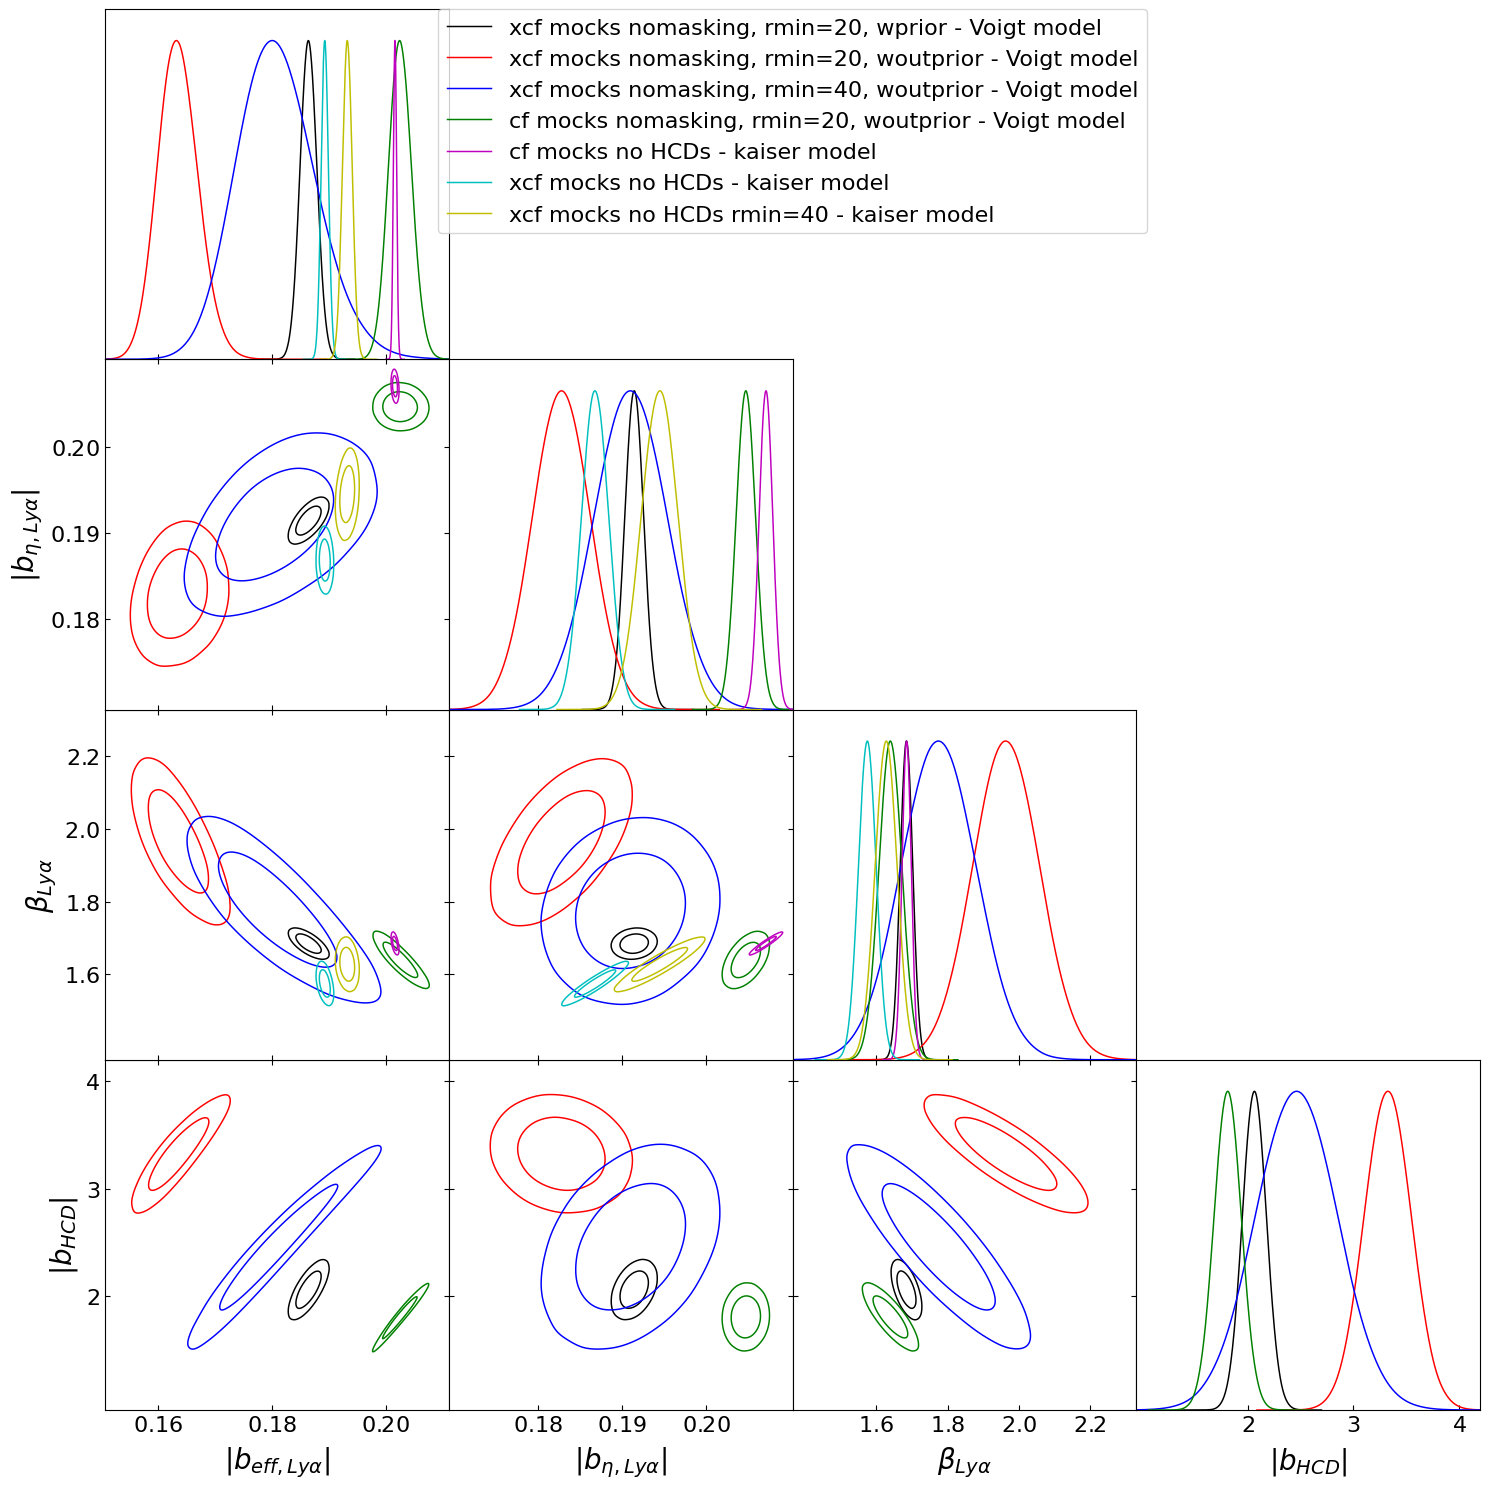

In [38]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 16
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
pars_all_voigt = ['bias_eff', 'bias_eta_LYA', 'beta_LYA','bias_hcd']

g.triangle_plot([chain_xcf_mocks_nomasking_voigt, chain_xcf_mocks_nomasking_voigt_noprior, chain_xcf_mocks_nomasking_voigt_noprior_rmin40, chain_cf_mocks_nomasking_voigt, chain_cf_mocks_kaiser, chain_xcf_mocks_kaiser, chain_xcf_mocks_kaiser_rmin40], pars_all_voigt, filled=False,
               legend_labels=['xcf mocks nomasking, rmin=20, wprior - Voigt model', 'xcf mocks nomasking, rmin=20, woutprior - Voigt model', 'xcf mocks nomasking, rmin=40, woutprior - Voigt model', 'cf mocks nomasking, rmin=20, woutprior - Voigt model', 'cf mocks no HCDs - kaiser model', 'xcf mocks no HCDs - kaiser model', 'xcf mocks no HCDs rmin=40 - kaiser model'],
               param_limits={'alpha':[0.9,1.1]},framon=False)
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_voigt_xcf-1.pdf', bbox_inches='tight')

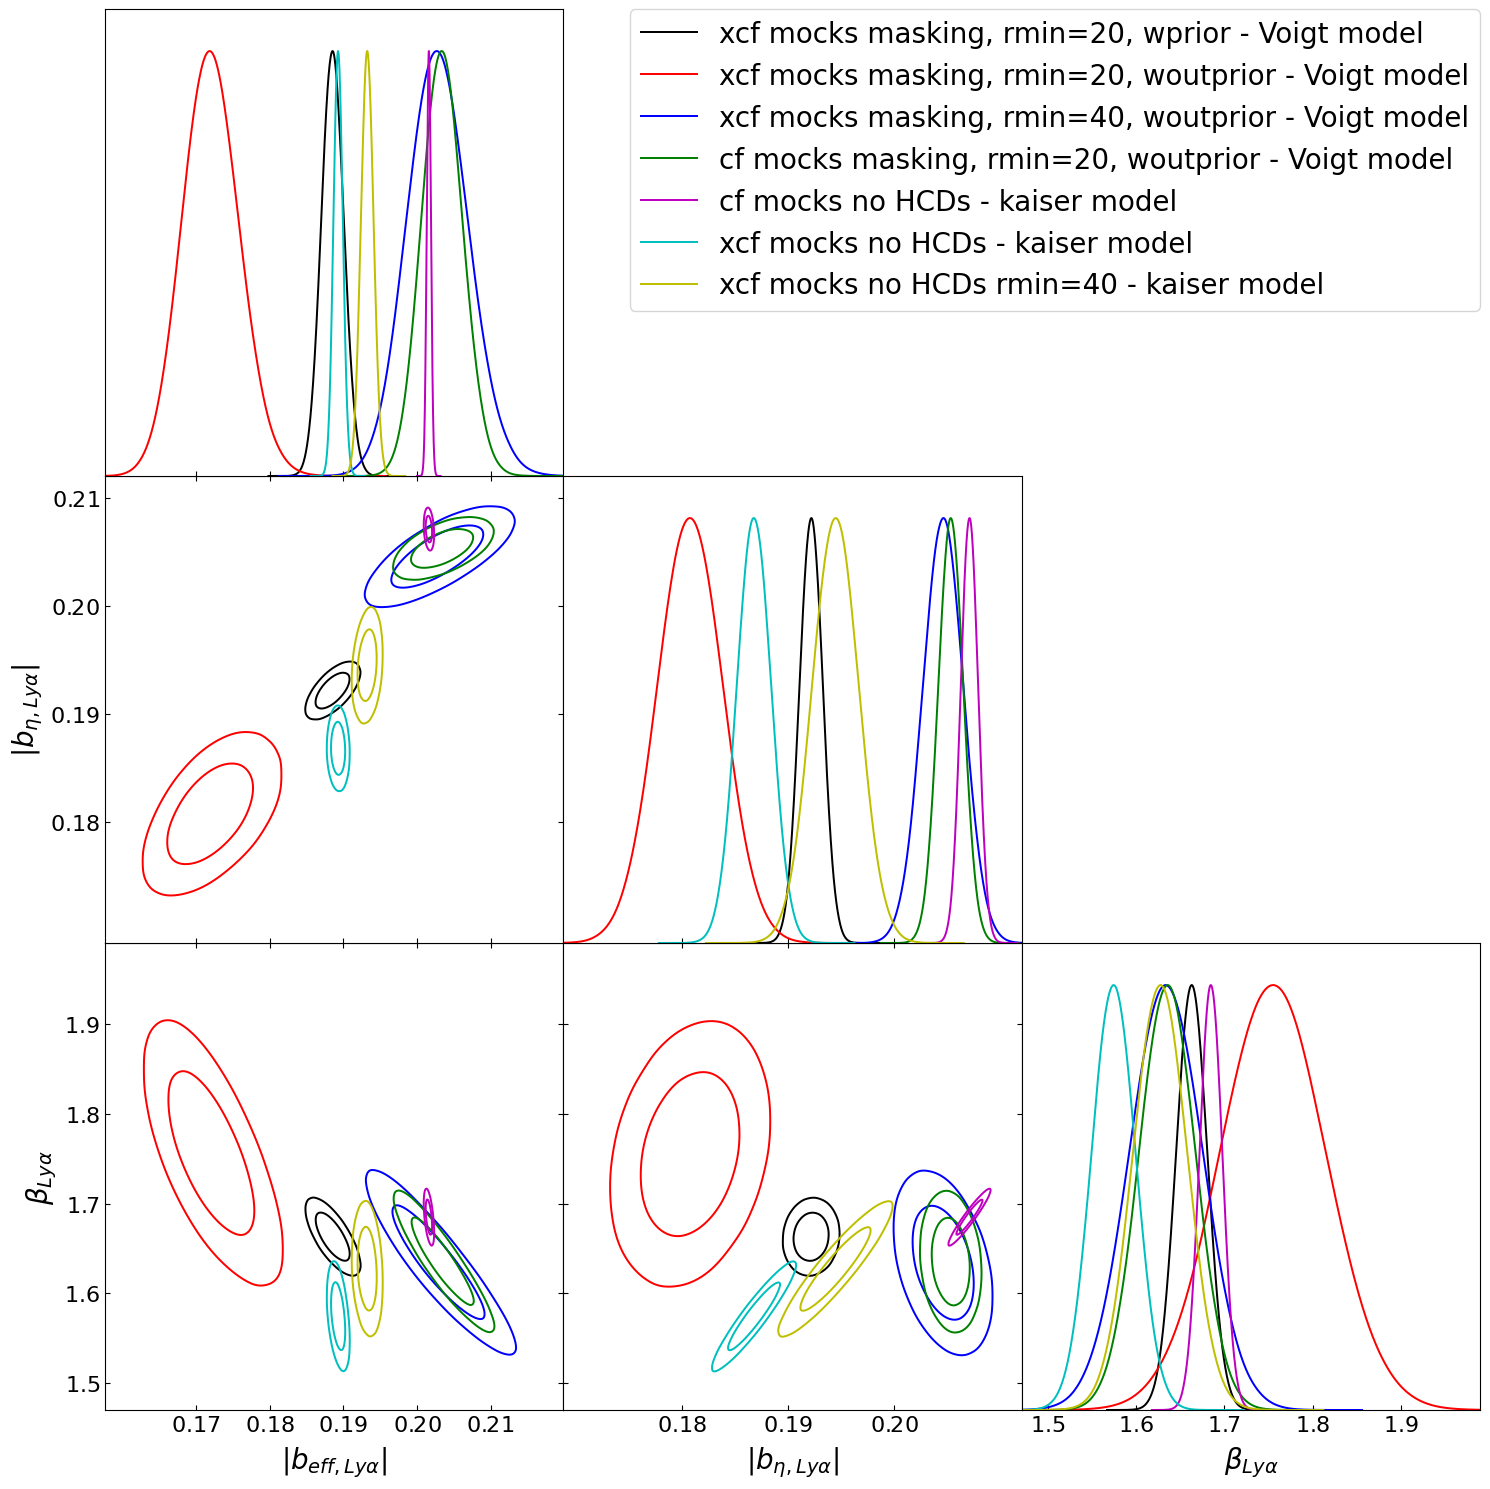

In [39]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
pars_all_voigt = ['bias_eff', 'bias_eta_LYA', 'beta_LYA']

#g.triangle_plot([chain_xcf_mocks_nomasking_voigt, chain_xcf_mocks_nomasking_voigt_noprior, chain_xcf_mocks_nomasking_voigt_noprior_rmin40, chain_cf_mocks_nomasking_voigt, chain_cf_mocks_nomasking_exp, chain_cf_mocks_kaiser], pars_all_voigt, filled=False,
#               legend_labels=['mocks nomasking, rmin=20, wprior - Voigt model', 'mocks nomasking, rmin=20, woutprior - Voigt model', 'mocks nomasking, rmin=40, woutprior - Voigt model','cf mocks nomasking, rmin=20, woutprior - Voigt model', 'cf mocks nomasking, rmin=20, woutprior - Exp model', 'cf mocks no HCDs - kaiser model'],
#               param_limits={'alpha':[0.9,1.1]},framon=False)
g.triangle_plot([chain_xcf_mocks_masking_voigt, chain_xcf_mocks_masking_voigt_noprior, chain_xcf_mocks_masking_voigt_noprior_rmin40, chain_cf_mocks_masking_voigt, chain_cf_mocks_kaiser, chain_xcf_mocks_kaiser, chain_xcf_mocks_kaiser_rmin40], pars_all_voigt, filled=False,
               legend_labels=['xcf mocks masking, rmin=20, wprior - Voigt model', 'xcf mocks masking, rmin=20, woutprior - Voigt model', 'xcf mocks masking, rmin=40, woutprior - Voigt model', 'cf mocks masking, rmin=20, woutprior - Voigt model', 'cf mocks no HCDs - kaiser model', 'xcf mocks no HCDs - kaiser model', 'xcf mocks no HCDs rmin=40 - kaiser model'],
               param_limits={'alpha':[0.9,1.1]},framon=False)
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_voigt_xcf-2.pdf', bbox_inches='tight')

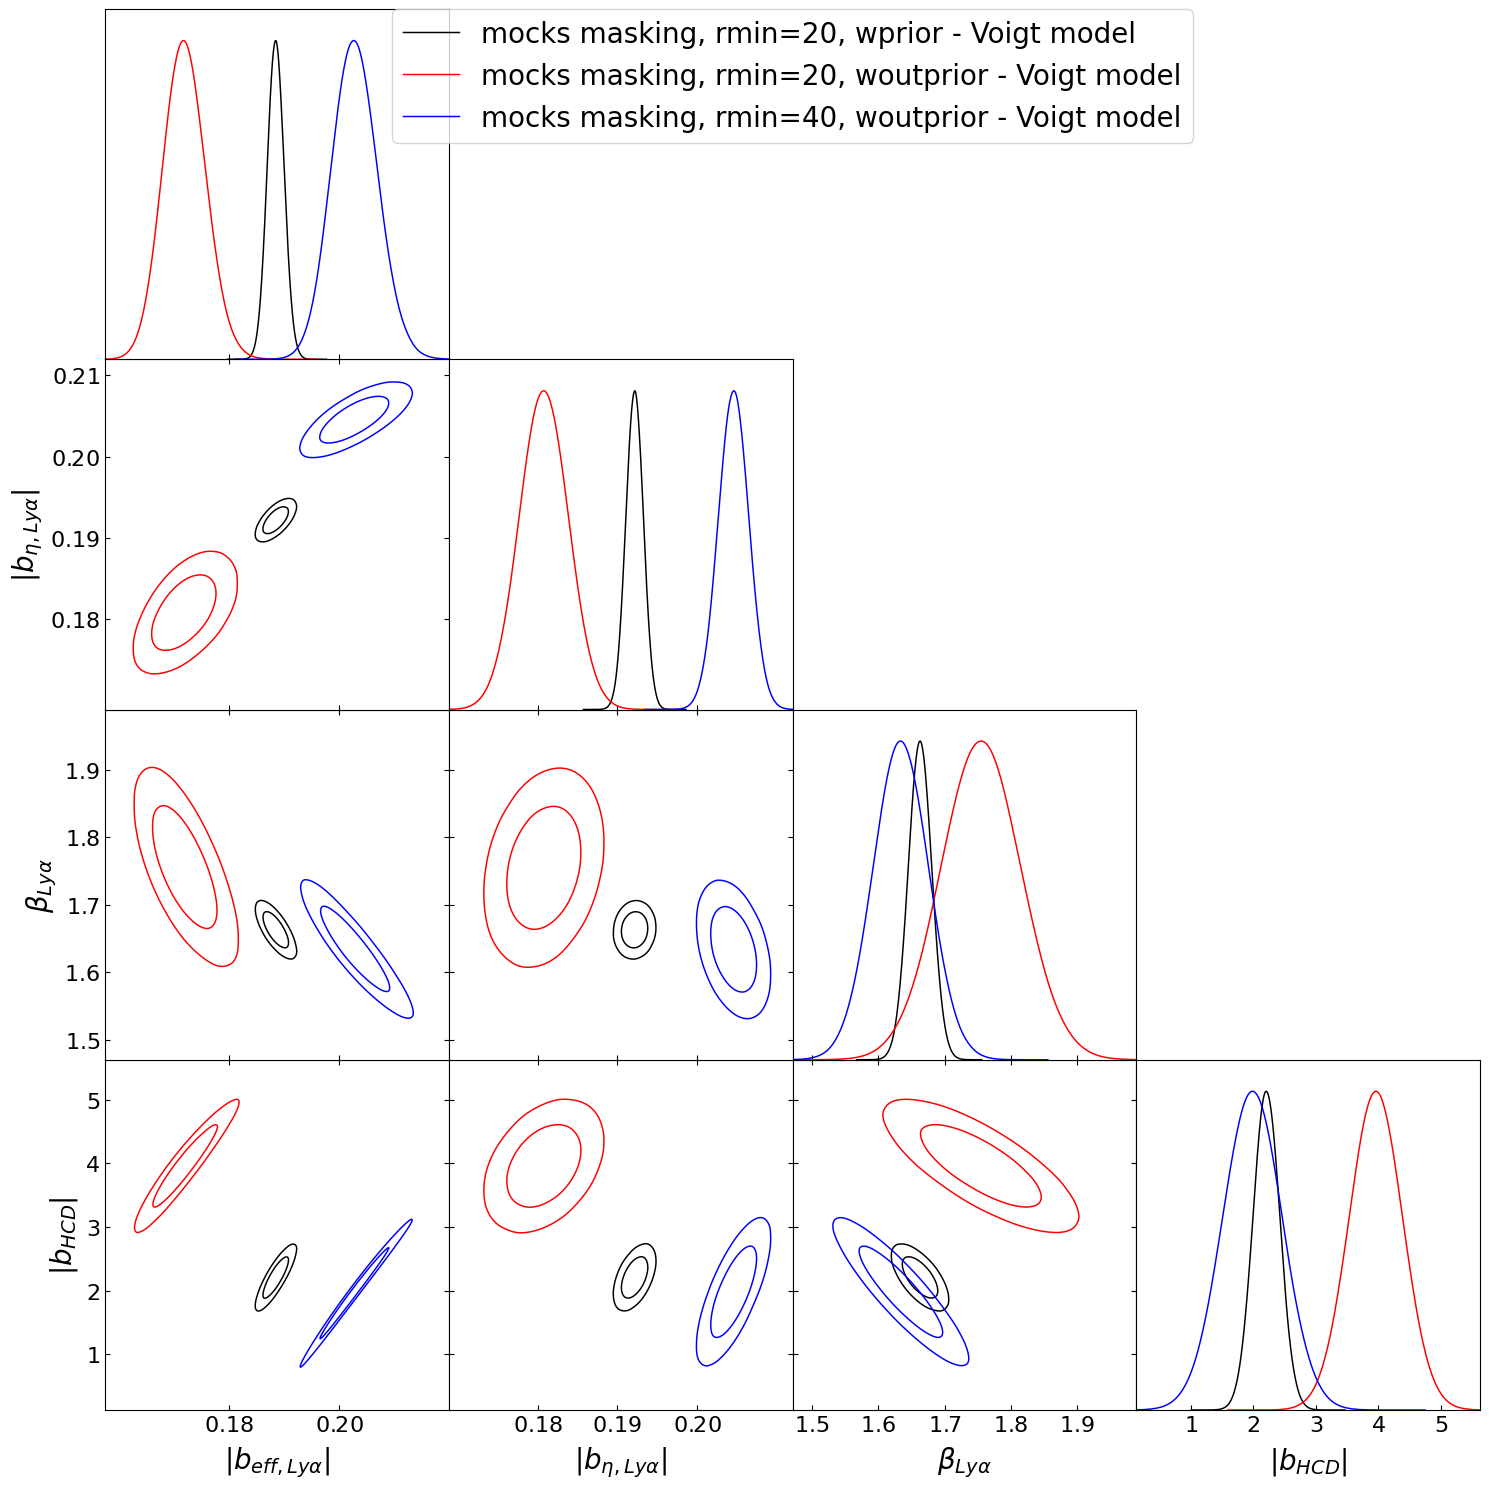

In [22]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
pars_all_voigt = ['bias_eff', 'bias_eta_LYA', 'beta_LYA','bias_hcd']

g.triangle_plot([chain_xcf_mocks_masking_voigt, chain_xcf_mocks_masking_voigt_noprior, chain_xcf_mocks_masking_voigt_noprior_rmin40], pars_all_voigt, filled=False,
               legend_labels=['mocks masking, rmin=20, wprior - Voigt model', 'mocks masking, rmin=20, woutprior - Voigt model', 'mocks masking, rmin=40, woutprior - Voigt model'],
               param_limits={'alpha':[0.9,1.1]},framon=False)
#plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_voigt2.pdf', bbox_inches='tight')

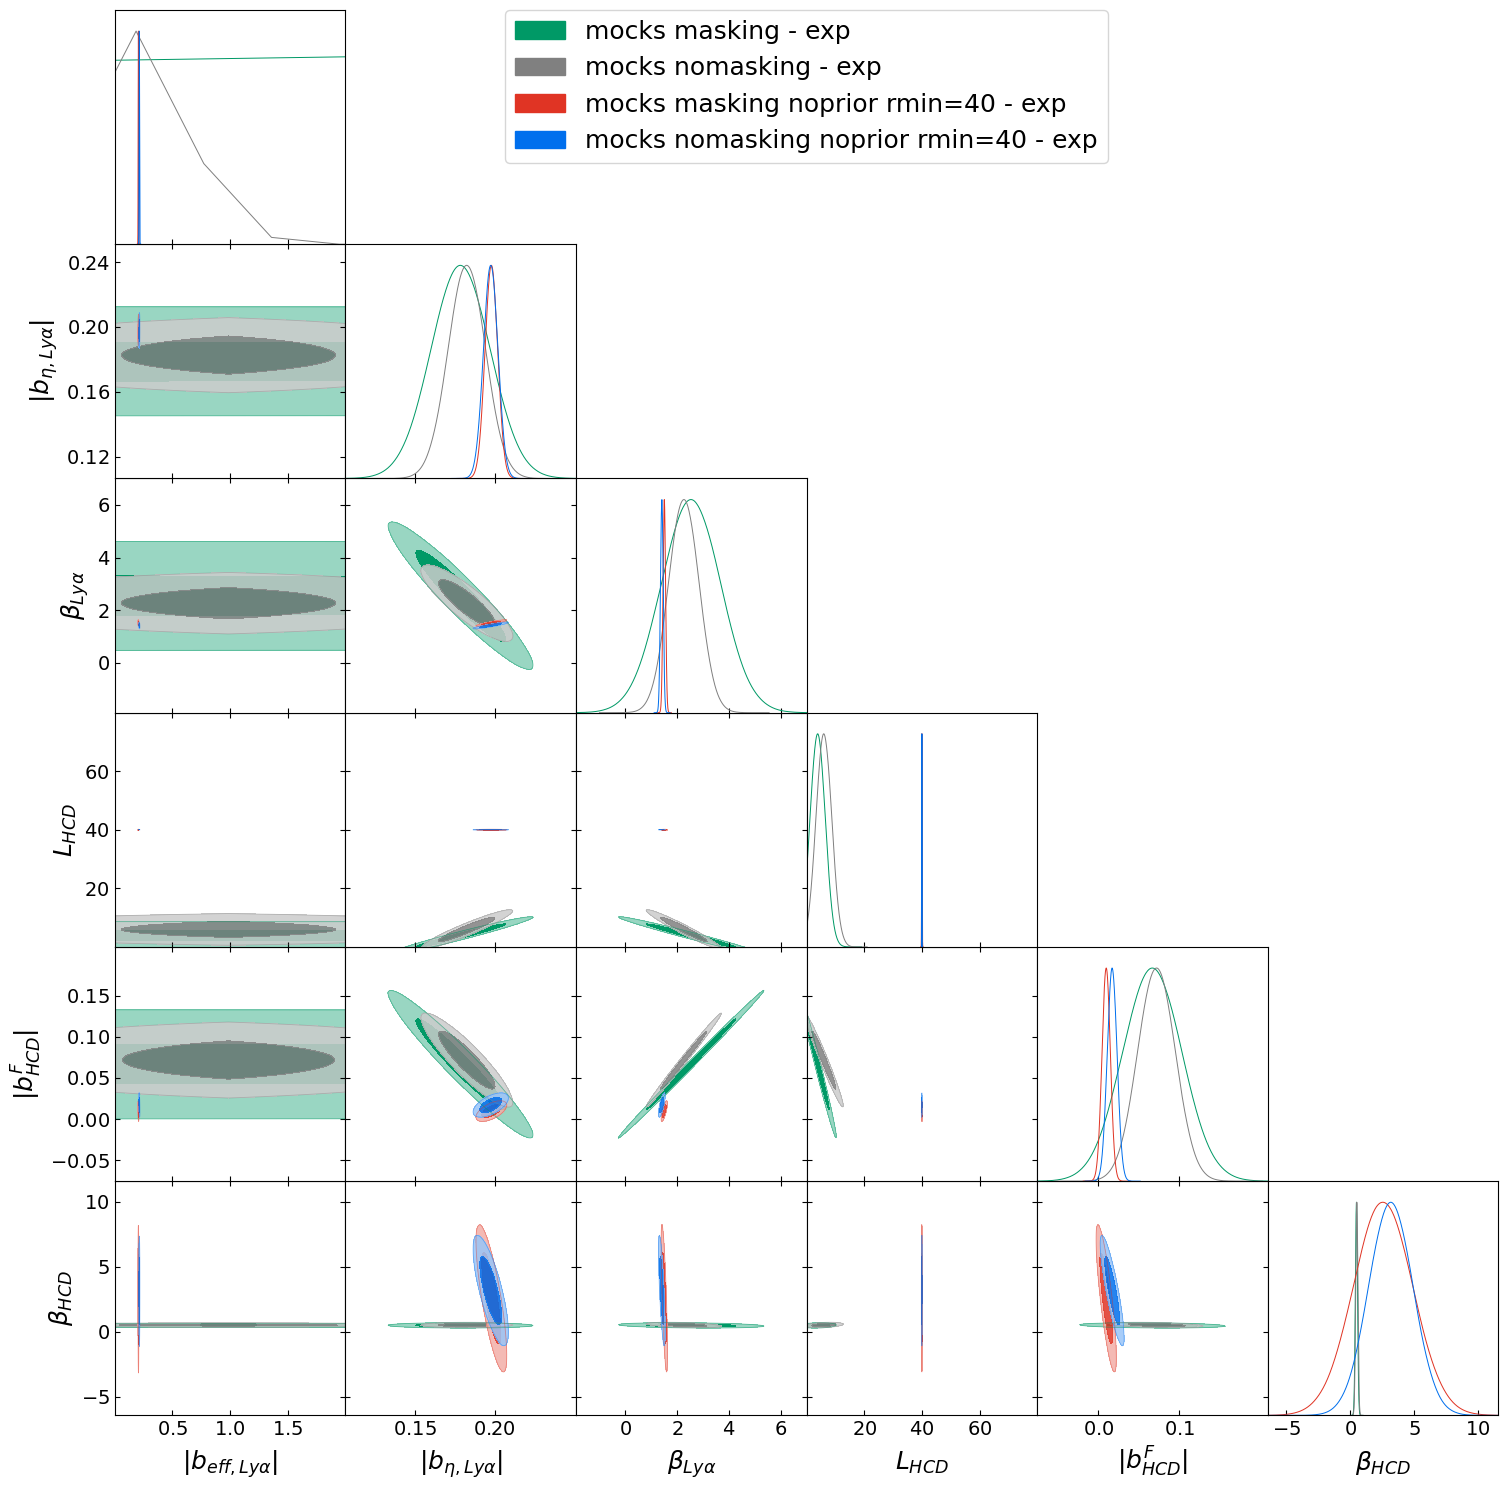

In [59]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
pars_all = ['bias_eff', 'bias_eta_LYA', 'beta_LYA', 'L0_hcd','bias_F_hcd','beta_hcd']

g.triangle_plot([chain_xcf_mocks_masking_exp, chain_xcf_mocks_nomasking_exp,chain_xcf_mocks_masking_exp_noprior_rmin40, chain_xcf_mocks_nomasking_exp_noprior_rmin40], pars_all, filled=True,
               legend_labels=['mocks masking - exp', 'mocks nomasking - exp','mocks masking noprior rmin=40 - exp', 'mocks nomasking noprior rmin=40 - exp'],
               param_limits={'bias_eff':[0,2], 'L0_hcd':[0,80]})
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_xcf_exp-1.pdf', bbox_inches='tight')

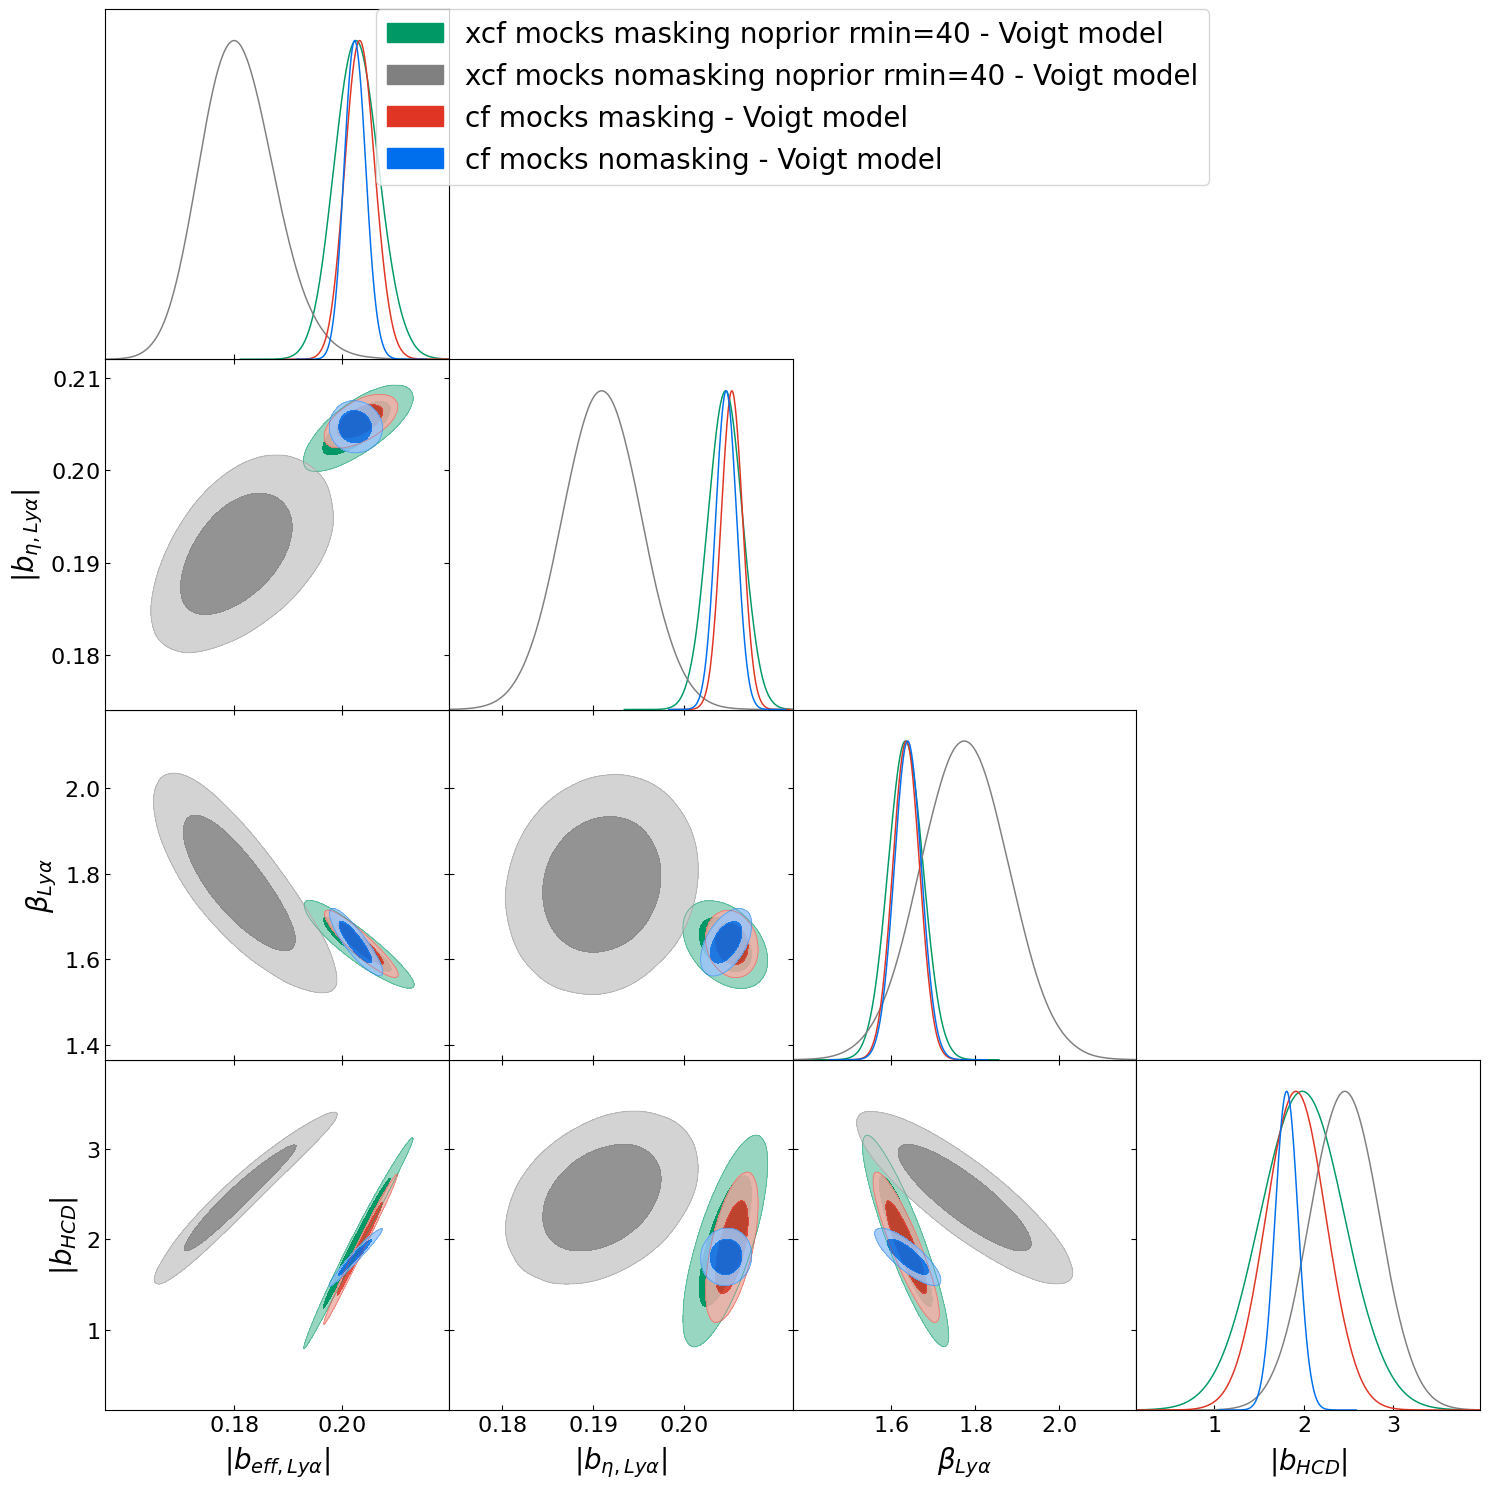

In [43]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
pars_all_voigt = ['bias_eff', 'bias_eta_LYA', 'beta_LYA', 'bias_hcd']

g.triangle_plot([chain_xcf_mocks_masking_voigt_noprior_rmin40, chain_xcf_mocks_nomasking_voigt_noprior_rmin40,chain_cf_mocks_masking_voigt, chain_cf_mocks_nomasking_voigt], pars_all_voigt, filled=True,
               legend_labels=['xcf mocks masking noprior rmin=40 - Voigt model', 'xcf mocks nomasking noprior rmin=40 - Voigt model','cf mocks masking - Voigt model', 'cf mocks nomasking - Voigt model'],
               param_limits={'alpha':[0.9,1.1]},framon=False)
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_voigt_xcf-3.pdf', bbox_inches='tight')

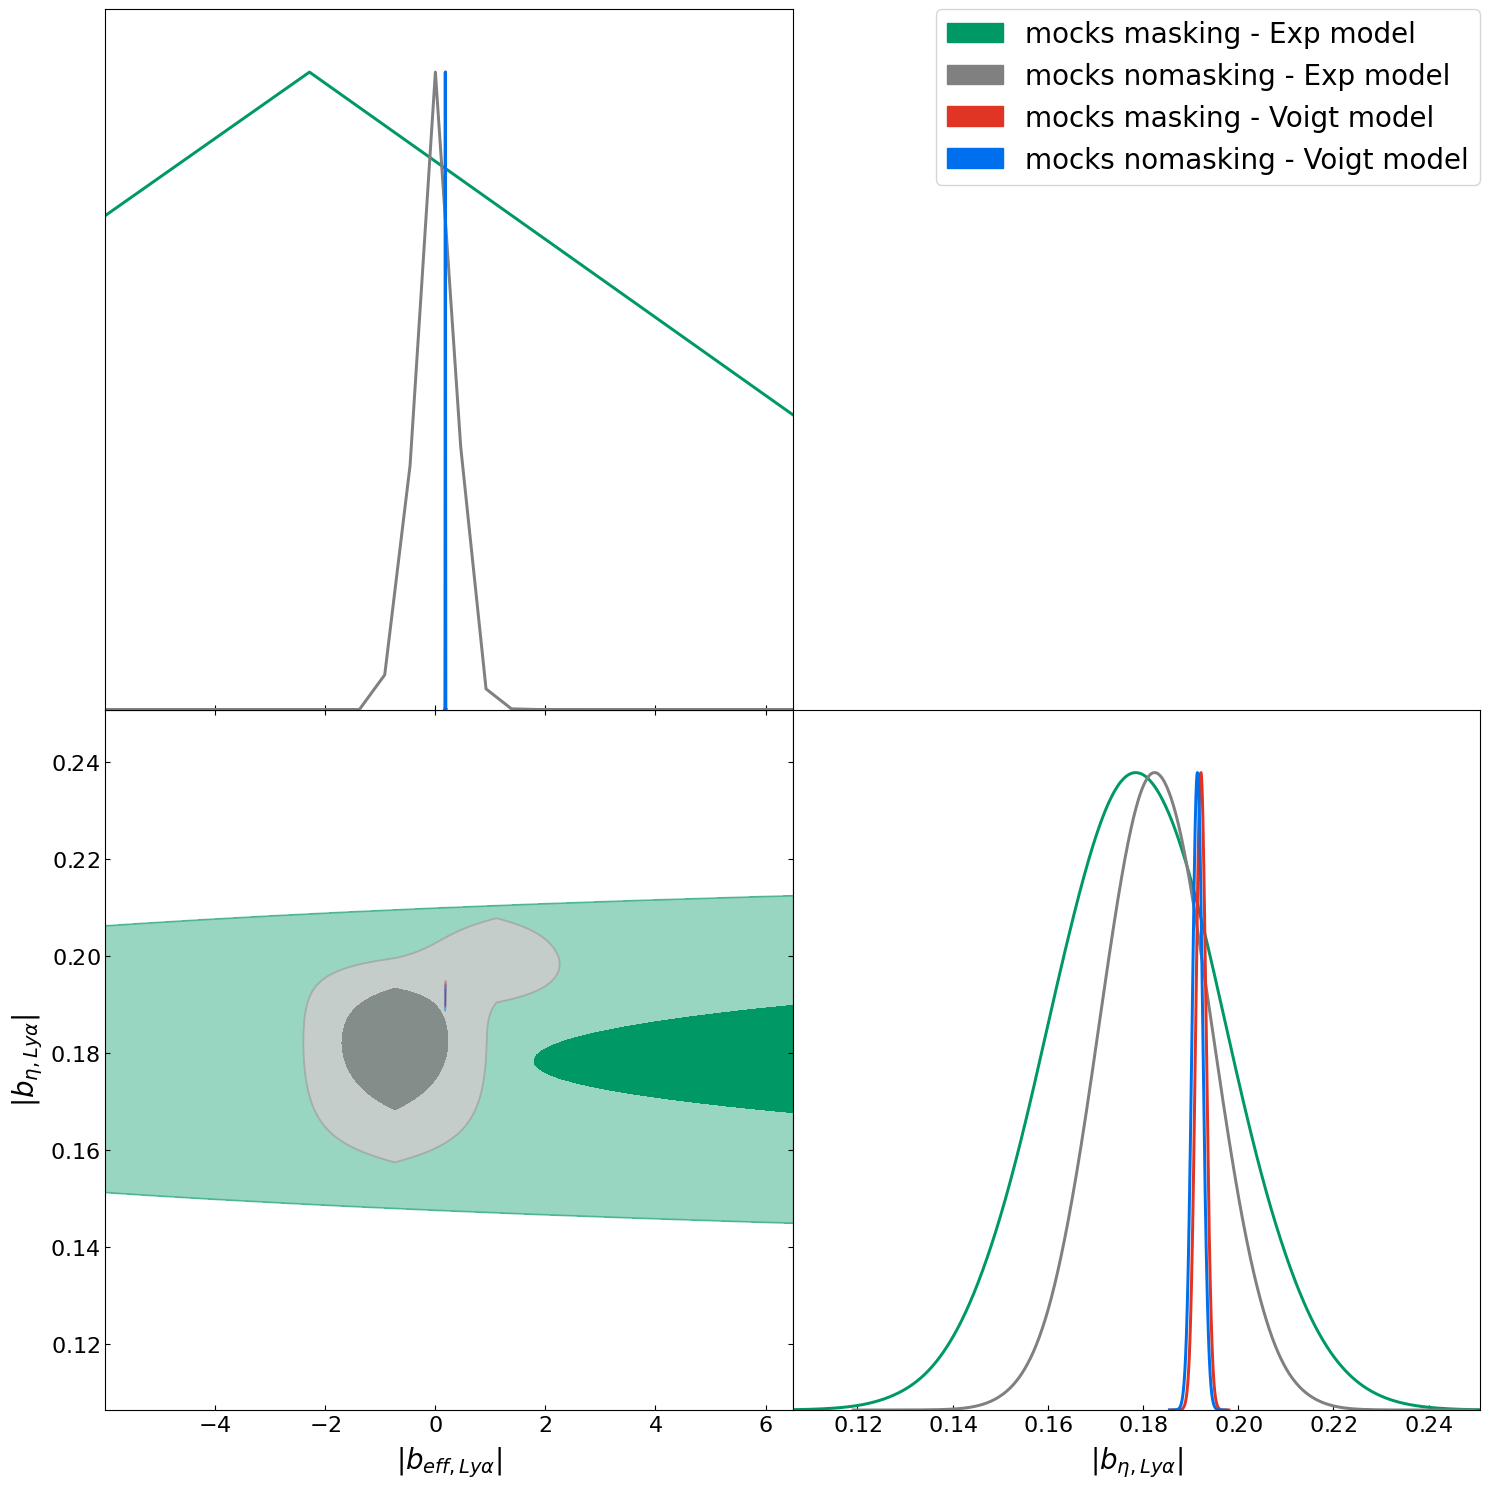

In [11]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
pars_all = ['bias_eff', 'bias_eta_LYA']

g.triangle_plot([chain_xcf_mocks_masking_exp, chain_xcf_mocks_nomasking_exp,chain_xcf_mocks_masking_voigt, chain_xcf_mocks_nomasking_voigt], pars_all, filled=True,
               legend_labels=['mocks masking - Exp model', 'mocks nomasking - Exp model','mocks masking - Voigt model', 'mocks nomasking - Voigt model'],
               param_limits={'alpha':[0.9,1.1]},framon=False)

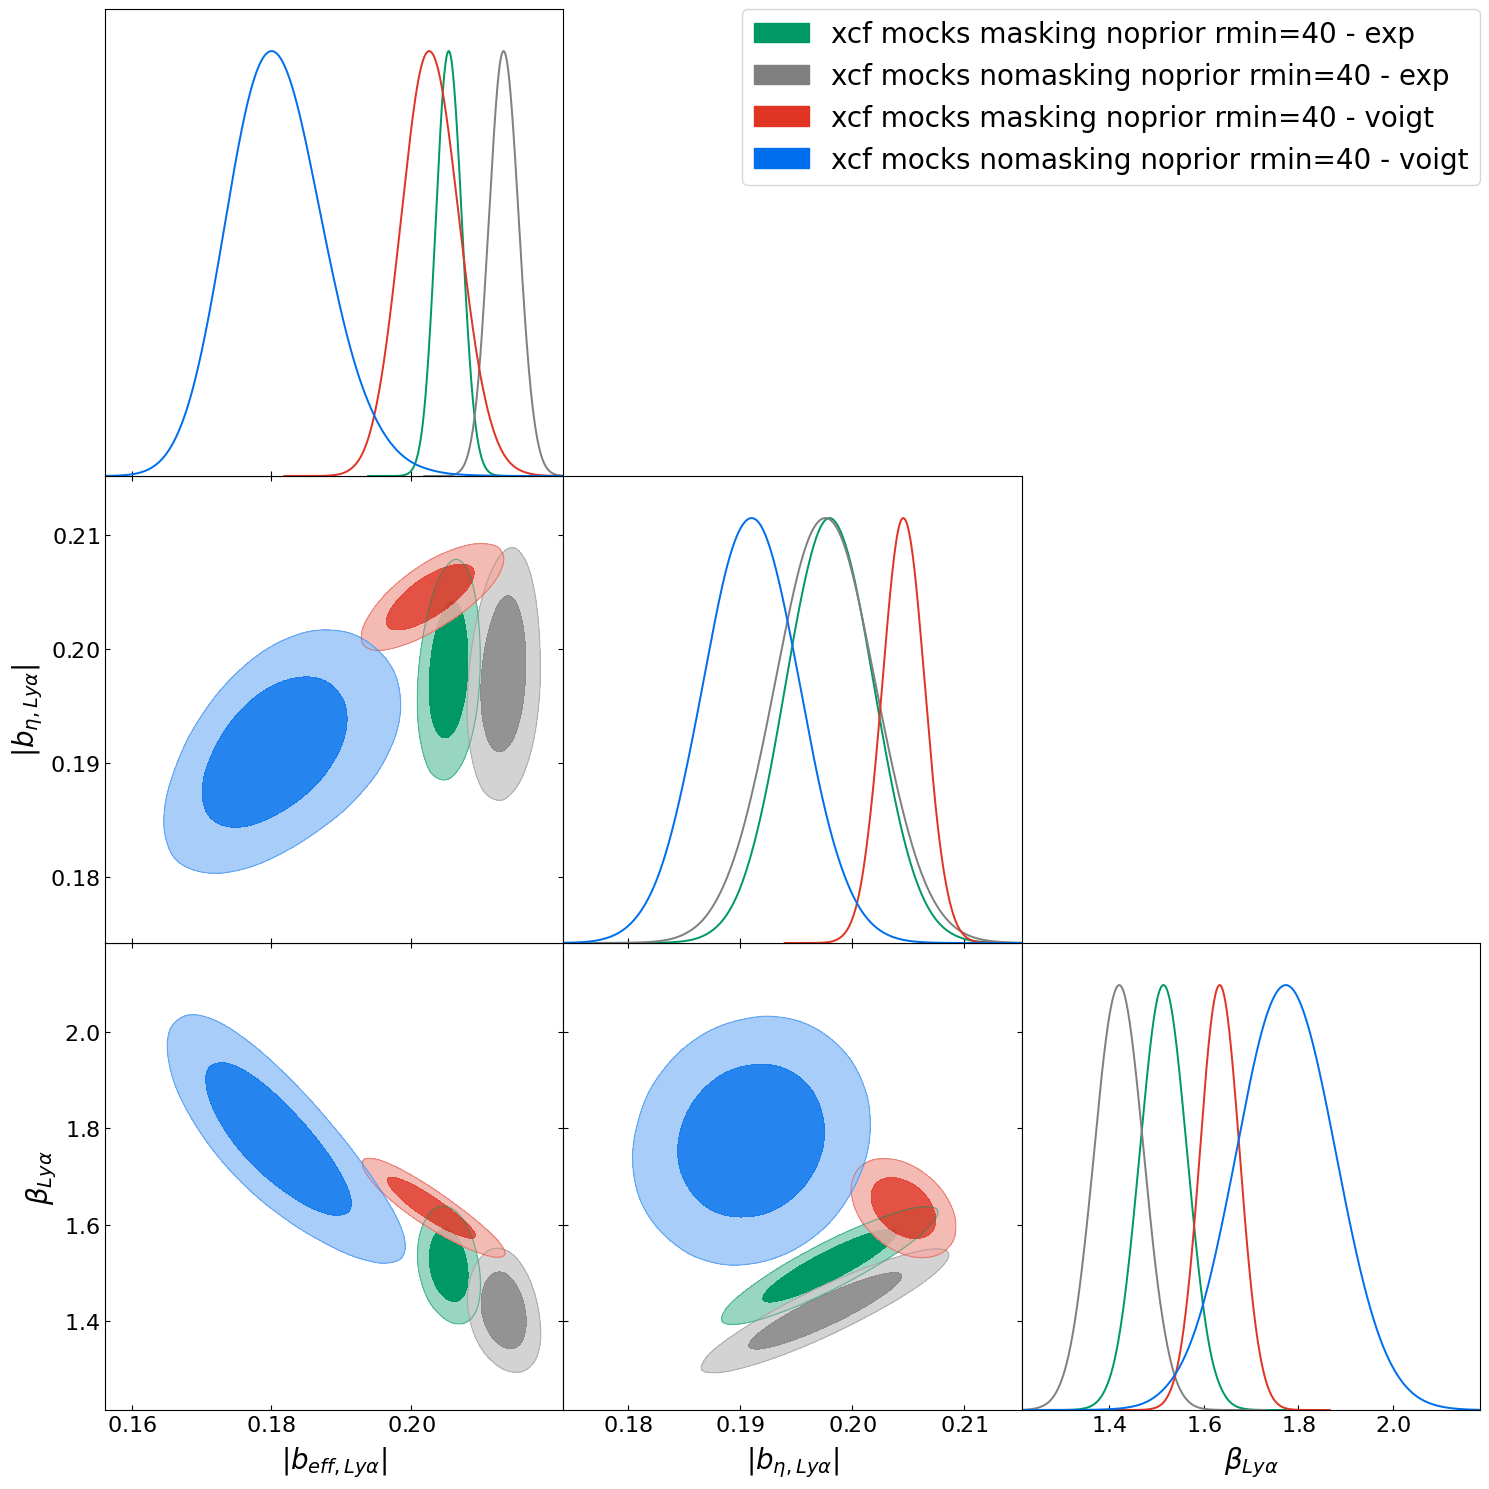

In [54]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
pars_all = [ 'bias_eff', 'bias_eta_LYA', 'beta_LYA']

g.triangle_plot([chain_xcf_mocks_masking_exp_noprior_rmin40, chain_xcf_mocks_nomasking_exp_noprior_rmin40,chain_xcf_mocks_masking_voigt_noprior_rmin40, chain_xcf_mocks_nomasking_voigt_noprior_rmin40], pars_all, filled=True,
               legend_labels=['xcf mocks masking noprior rmin=40 - exp', 'xcf mocks nomasking noprior rmin=40 - exp','xcf mocks masking noprior rmin=40 - voigt', 'xcf mocks nomasking noprior rmin=40 - voigt'],
               param_limits={'alpha':[0.9,1.1]})
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_mocks_exp_xcf-2.pdf', bbox_inches='tight')

# Get uncorrelated uncertainty

In [41]:
def get_matrix(directory):
    f = h5py.File(directory,'r')
    #print(f['best fit'].attrs.keys())
    params = ['L0_hcd','beta','gamma']
    matrix = np.ones(9).reshape(3,3)
    for i in range(3):
        for j in range(3):
            #if i!=j:
                #try:
            f_cov=f['best fit'].attrs['cov[{}, {}]'.format(params[i],params[j])]
            #print(f_cov)
            #except:
            #    f_cov=f['best fit'].attrs['cov[{}, {}]'.format(params[j],params[i])]
            matrix[i,j]=f_cov/(f['best fit'].attrs[params[i]][1]*f['best fit'].attrs[params[j]][1])
    return matrix
def get_correlated_uncertainty(directory):
    matrix = get_matrix(directory)
    D,V=np.linalg.eig(matrix)
    return D
def print_correlation(directory):
    f = h5py.File(directory,'r')
    ap=f['best fit'].attrs['ap'][0]
    eap=f['best fit'].attrs['ap'][1]
    at=f['best fit'].attrs['at'][0]
    eat=f['best fit'].attrs['at'][1]
    biaseta_LYA=f['best fit'].attrs['bias_eta_LYA'][0]
    ebiaseta_LYA=f['best fit'].attrs['bias_eta_LYA'][1]
    bias_hcd=f['best fit'].attrs['bias_hcd'][0]
    ebias_hcd=f['best fit'].attrs['bias_hcd'][1]
    beta_LYA=f['best fit'].attrs['beta_LYA'][0]
    ebeta_LYA=f['best fit'].attrs['beta_LYA'][1]
    beta_hcd=f['best fit'].attrs['beta_hcd'][0]
    ebeta_hcd=f['best fit'].attrs['beta_hcd'][1]
    L0hcd=f['best fit'].attrs['L0_hcd']
    chi2= f['best fit'].attrs['fval']
    ndata= f['best fit'].attrs['ndata']
    npar= f['best fit'].attrs['npar']
    for param1 in ['at','ap','bias_eta_LYA','beta_LYA','bias_hcd','beta_hcd']:
        for param2 in ['at','ap','bias_eta_LYA','beta_LYA','bias_hcd','beta_hcd']:
            try:
                f_cov=f['best fit'].attrs['cov[{}, {}]'.format(param1,param2)]
            except:
                f_cov=f['best fit'].attrs['cov[{}, {}]'.format(param2,param1)]
                continue
            print('correlation between {} and {}: {}'.format(param1,param2,f_cov/(f['best fit'].attrs[param1][1]*f['best fit'].attrs[param2][1])))

In [42]:
f = h5py.File('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10/Fits_mock_hcd_mask_200_rebins_3-0-10/result_exp.h5','r')
#f['best fit'].attrs['cov[{}, {}]'.format(param1,param2)]
print_correlation('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10/Fits_mock_hcd_mask_200_rebins_3-0-10/result_exp.h5')

correlation between at and at: 1.0002556124714332
correlation between at and ap: -0.49010158155624306
correlation between at and bias_eta_LYA: 0.0168894386894418
correlation between at and beta_LYA: -0.026586867013497672
correlation between at and bias_hcd: 0.040754530269250244
correlation between at and beta_hcd: 0.005567927532844948
correlation between ap and at: -0.49010158155624306
correlation between ap and ap: 1.0001047881336529
correlation between ap and bias_eta_LYA: 0.02636386477547465
correlation between ap and beta_LYA: -0.03473528249273214
correlation between ap and bias_hcd: -0.034717864173147796
correlation between ap and beta_hcd: 0.018513120042614694
correlation between bias_eta_LYA and at: 0.0168894386894418
correlation between bias_eta_LYA and ap: 0.02636386477547465
correlation between bias_eta_LYA and bias_eta_LYA: 1.0
correlation between bias_eta_LYA and beta_LYA: -0.9419560576450876
correlation between bias_eta_LYA and bias_hcd: -0.12147697925493768
correlation be

In [39]:
f_fits = FITS('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10/Fits_mock_hcd_mask_200_rebins_3-0-10/result_vega_cf_exp.fits')
f_fits[2]['covariance'][:],f_fits[2]['covariance'][:].shape

(array([[ 7.76017801e-05, -5.76208834e-05,  5.40342247e-07,
          8.60655992e-06, -7.87919516e-07, -1.83838677e-06,
         -1.85334088e-03],
        [-5.76208834e-05,  1.81000513e-04, -4.26492031e-07,
         -1.97570370e-05,  1.56115738e-06,  5.85361576e-07,
          2.19254995e-03],
        [ 5.40342247e-07, -4.26492031e-07,  4.47706161e-06,
          5.52395816e-05, -6.42623932e-06,  1.29880405e-05,
         -1.30502836e-02],
        [ 8.60655992e-06, -1.97570370e-05,  5.52395816e-05,
          2.00850275e-03, -1.72885818e-04, -9.05196542e-04,
         -2.67523460e-01],
        [-7.87919516e-07,  1.56115738e-06, -6.42623932e-06,
         -1.72885818e-04,  1.64447132e-05,  7.03911374e-05,
          2.51688469e-02],
        [-1.83838677e-06,  5.85361576e-07,  1.29880405e-05,
         -9.05196542e-04,  7.03911374e-05,  8.20359542e-03,
          7.15435163e-02],
        [-1.85334088e-03,  2.19254995e-03, -1.30502836e-02,
         -2.67523460e-01,  2.51688469e-02,  7.15435163e-02

In [81]:
f_fits[2]['names'][:]

array(['ap', 'at', 'bias_eta_LYA', 'beta_LYA', 'bias_hcd', 'beta_hcd',
       'L0_hcd'], dtype='<U12')

In [54]:
f_fits[2]['values'][:]

array([ 1.00619848e+00,  9.79895198e-01, -2.09313095e-01,  1.56410707e+00,
       -7.76203436e-03,  4.87754571e-01,  7.96706829e+00])

In [58]:
f_fits[2]['errors'][:]

array([8.80907217e-03, 1.34532329e-02, 2.11590259e-03, 4.48135308e-02,
       4.04776368e-03, 9.05174441e-02, 6.82150541e+00])

In [57]:
f_fits[2]['covariance'][:]

array([[ 7.76017801e-05, -5.76208834e-05,  5.40342247e-07,
         8.60655992e-06, -7.87919516e-07, -1.83838677e-06,
        -1.85334088e-03],
       [-5.76208834e-05,  1.81000513e-04, -4.26492031e-07,
        -1.97570370e-05,  1.56115738e-06,  5.85361576e-07,
         2.19254995e-03],
       [ 5.40342247e-07, -4.26492031e-07,  4.47706161e-06,
         5.52395816e-05, -6.42623932e-06,  1.29880405e-05,
        -1.30502836e-02],
       [ 8.60655992e-06, -1.97570370e-05,  5.52395816e-05,
         2.00850275e-03, -1.72885818e-04, -9.05196542e-04,
        -2.67523460e-01],
       [-7.87919516e-07,  1.56115738e-06, -6.42623932e-06,
        -1.72885818e-04,  1.64447132e-05,  7.03911374e-05,
         2.51688469e-02],
       [-1.83838677e-06,  5.85361576e-07,  1.29880405e-05,
        -9.05196542e-04,  7.03911374e-05,  8.20359542e-03,
         7.15435163e-02],
       [-1.85334088e-03,  2.19254995e-03, -1.30502836e-02,
        -2.67523460e-01,  2.51688469e-02,  7.15435163e-02,
         4.9673213

In [86]:
f =  h5py.File('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10_DLA_no_masking/Fits_mock_hcd_mask_200_rebins_3-0-10/result_exp.h5','r')
matrix = np.ones(49).reshape(7,7)
params = ['at','ap','bias_eta_LYA','beta_LYA','bias_hcd','beta_hcd','L0_hcd']
for i in range(7):
    #print(f['best fit'].attrs[params[i]][0],f['best fit'].attrs[params[i]][1])
    print(np.sqrt(f['best fit'].attrs['cov[{}, {}]'.format(params[i],params[i])]))
    for j in range(7):
        #print(params[i],params[j])
        #print(f['best fit'].attrs['cov[{}, {}]'.format(params[i],params[j])])
        matrix[i,j]=f['best fit'].attrs['cov[{}, {}]'.format(params[i],params[j])]/(f['best fit'].attrs[params[i]][1]*f['best fit'].attrs[params[j]][1])
matrix

0.01466641446525251
0.009187474687572103
0.002036048711368353
0.05172629744638615
0.003852426285883686
0.08908396046565534
2.571929703241046


array([[ 1.00028715, -0.48855488, -0.00955621, -0.0251889 ,  0.02380439,
        -0.00163141,  0.01867762],
       [-0.48855488,  1.00011256,  0.01931094,  0.02660714, -0.02593807,
        -0.0045125 , -0.02872283],
       [-0.00955621,  0.01931094,  1.        ,  0.16310362, -0.35660245,
         0.28149083, -0.65634975],
       [-0.0251889 ,  0.02660714,  0.16310362,  1.        , -0.93702434,
        -0.50859496, -0.80119444],
       [ 0.02380439, -0.02593807, -0.35660245, -0.93702434,  1.        ,
         0.49083674,  0.81890878],
       [-0.00163141, -0.0045125 ,  0.28149083, -0.50859496,  0.49083674,
         1.        ,  0.28810936],
       [ 0.01867762, -0.02872283, -0.65634975, -0.80119444,  0.81890878,
         0.28810936,  1.        ]])

In [84]:
print(f_fits[2]['covariance'][:])
matrix=f_fits[2]['covariance'][:][4:6:1,4:6:1]
D,V=np.linalg.eig(matrix)
print(matrix)
print(D)
print(V)

[[ 7.76017801e-05 -5.76208834e-05  5.40342247e-07  8.60655992e-06
  -7.87919516e-07 -1.83838677e-06 -1.85334088e-03]
 [-5.76208834e-05  1.81000513e-04 -4.26492031e-07 -1.97570370e-05
   1.56115738e-06  5.85361576e-07  2.19254995e-03]
 [ 5.40342247e-07 -4.26492031e-07  4.47706161e-06  5.52395816e-05
  -6.42623932e-06  1.29880405e-05 -1.30502836e-02]
 [ 8.60655992e-06 -1.97570370e-05  5.52395816e-05  2.00850275e-03
  -1.72885818e-04 -9.05196542e-04 -2.67523460e-01]
 [-7.87919516e-07  1.56115738e-06 -6.42623932e-06 -1.72885818e-04
   1.64447132e-05  7.03911374e-05  2.51688469e-02]
 [-1.83838677e-06  5.85361576e-07  1.29880405e-05 -9.05196542e-04
   7.03911374e-05  8.20359542e-03  7.15435163e-02]
 [-1.85334088e-03  2.19254995e-03 -1.30502836e-02 -2.67523460e-01
   2.51688469e-02  7.15435163e-02  4.96732132e+01]]
[[1.64447132e-05 7.03911374e-05]
 [7.03911374e-05 8.20359542e-03]]
[1.58395520e-05 8.20420058e-03]
[[-0.99996305 -0.0085968 ]
 [ 0.0085968  -0.99996305]]


In [85]:
matrix=np.zeros((2,2))
matrix[0][0]=f_fits[2]['covariance'][:][4][4]
matrix[0][1]=f_fits[2]['covariance'][:][4][6]
matrix[1][0]=f_fits[2]['covariance'][:][6][4]
matrix[1][1]=f_fits[2]['covariance'][:][6][6]
D,V=np.linalg.eig(matrix)
print(matrix)
print(D)
print(V)

[[1.64447132e-05 2.51688469e-02]
 [2.51688469e-02 4.96732132e+01]]
[3.69194638e-06 4.96732259e+01]
[[-9.99999872e-01 -5.06688494e-04]
 [ 5.06688494e-04 -9.99999872e-01]]


In [73]:
np.matmul(matrix,V[0].T),V[0]
#print(matrix,D,V)

(array([-3.60896165e-06,  7.61457289e-06, -2.24091037e-05, -7.78482862e-04,
         6.65285434e-05,  3.32455483e-04,  1.07941286e-01]),
 array([ 3.73100192e-05,  1.16555574e-04,  4.66090940e-06, -4.07745204e-01,
        -9.13095514e-01, -4.71323535e-04,  4.40378878e-04]))

In [ ]:
f = h5py.File('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/Result_hcd/Stack_1_10/Fits_mock_hcd_mask_200_rebins_3-0-10/result_LBG.h5','r')
matrix = np.ones(9).reshape(3,3)
params = ['L0_hcd','beta','gamma']
for i in range(3):
    print(f['best fit'].attrs[params[i]][0],f['best fit'].attrs[params[i]][1])
    print(np.sqrt(f['best fit'].attrs['cov[{}, {}]'.format(params[i],params[i])]))
    for j in range(3):
        #print(params[i],params[j])
        #print(f['best fit'].attrs['cov[{}, {}]'.format(params[i],params[j])])
        matrix[i,j]=f['best fit'].attrs['cov[{}, {}]'.format(params[i],params[j])]/(f['best fit'].attrs[params[i]][1]*f['best fit'].attrs[params[j]][1])
matrix

# DR16 and DESI data

In [84]:
f=fits.open('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/DESI_data/EDR/fitter/auto_v6.fits')
#'/global/homes/t/tanting/DESI_analysis/Thesis/Calum_scripts/fits_dr16/dr16_auto.fits'

In [85]:
f[1].data

FITS_rec([( 1.01233992e-02,  0,  9.61798783e-03, 3.98771809e-08,   2.04069327,   2.71644252, 2.36309063,   5844805),
          ( 5.81963220e-03,  0,  5.50856013e-03, 1.61925299e-08,   2.03736974,   6.18276357, 2.369381  ,  17652315),
          ( 3.32524869e-03,  1,  3.36734963e-03, 8.81792235e-09,   2.03575878,  10.1215235 , 2.37495291,  27842223),
          ...,
          ( 2.26474994e-07,  0, -1.80924035e-05, 1.07177622e-09, 298.00855827, 190.00265754, 2.48054153, 175971403),
          ( 1.27257409e-07,  0, -2.60091402e-05, 1.00606028e-09, 298.00651972, 194.00313304, 2.47940897, 178566665),
          (-8.76530699e-08,  0, -6.72281854e-05, 1.11252273e-09, 298.00407459, 198.00441542, 2.47933029, 181748942)],
         dtype=(numpy.record, [('lyaxlya_MODEL', '>f8'), ('lyaxlya_MASK', 'i1'), ('lyaxlya_DATA', '>f8'), ('lyaxlya_VAR', '>f8'), ('lyaxlya_RP', '>f8'), ('lyaxlya_RT', '>f8'), ('lyaxlya_Z', '>f8'), ('lyaxlya_NB', '>i8')]))

In [69]:
f=fits.open('/global/homes/t/tanting/DESI_analysis/Thesis/Calum_scripts/fits_dr16/dr16_cross.fits')

In [70]:
f[1].data

FITS_rec([(5.59608727e-04,  0, -4.94066926e-03, 4.07049769e-06, -197.99400799,   2.68790069, 2.4109149 ,   47621),
          (4.00889790e-04,  0,  1.09758249e-03, 1.65144468e-06, -197.99477974,   6.19742437, 2.4087312 ,  132067),
          (2.68668833e-04,  0, -8.09852145e-04, 9.04450308e-07, -197.99592496,  10.13045204, 2.41039591,  212196),
          ...,
          (1.34184560e-05,  0,  1.53124620e-05, 4.22016894e-08,  197.99909831, 190.00731719, 2.27313641, 4795176),
          (1.29210443e-05,  0, -5.99505383e-05, 4.08370605e-08,  198.0000022 , 194.00687331, 2.27302173, 4890031),
          (1.24195689e-05,  0,  2.20874276e-05, 4.06772902e-08,  197.99944774, 198.00593164, 2.27297985, 4981486)],
         dtype=(numpy.record, [('qsoxlya_MODEL', '>f8'), ('qsoxlya_MASK', 'i1'), ('qsoxlya_DATA', '>f8'), ('qsoxlya_VAR', '>f8'), ('qsoxlya_RP', '>f8'), ('qsoxlya_RT', '>f8'), ('qsoxlya_Z', '>f8'), ('qsoxlya_NB', '>i8')]))

In [71]:
f=fits.open('/global/homes/t/tanting/DESI_analysis/Thesis/Calum_scripts/fits_dr16/dr16_official_lya_only.fits')

In [72]:
f[1].data

FITS_rec([(0.01041356,  0, 0.01006066, 1.09210301e-08, 2.07942278,  2.69591934, 2.36224365,  7585209, 7.25597074e-04,  0, -4.94066926e-03, 4.07049769e-06, -197.99400799,   2.68790069, 2.4109149 ,   47621),
          (0.00588412,  0, 0.00560909, 3.54115358e-09, 2.07593782,  6.19556712, 2.36032967, 21017642, 4.96090161e-04,  0,  1.09758249e-03, 1.65144468e-06, -197.99477974,   6.19742437, 2.4087312 ,  132067),
          (0.00347564,  1, 0.00343969, 2.05379237e-09, 2.07702203, 10.13001749, 2.35955733, 33951053, 3.34535095e-04,  0, -8.09852145e-04, 9.04450308e-07, -197.99592496,  10.13045204, 2.41039591,  212196),
          ...,
          (0.        ,  0, 0.        , 0.00000000e+00, 0.        ,  0.        , 0.        ,        0, 1.24291334e-05,  0,  1.53124620e-05, 4.22016894e-08,  197.99909831, 190.00731719, 2.27313641, 4795176),
          (0.        ,  0, 0.        , 0.00000000e+00, 0.        ,  0.        , 0.        ,        0, 1.19746392e-05,  0, -5.99505383e-05, 4.08370605e-08,  198.0

In [90]:
res_cf_data_dr16, chain_cf_data_dr16 = get_res_data('/global/homes/t/tanting/DESI_analysis/Thesis/Calum_scripts/fits_dr16/dr16_auto.fits', lyb=False, cross=False)
res_xcf_data_dr16, chain_xcf_data_dr16 = get_res_data('/global/homes/t/tanting/DESI_analysis/Thesis/Calum_scripts/fits_dr16/dr16_cross.fits', auto=False,lyb=False, cross=True)
res_cfxcf_data_dr16, chain_cfxcf_data_dr16 = get_res_data('/global/homes/t/tanting/DESI_analysis/Thesis/Calum_scripts/fits_dr16/dr16_official_lya_only.fits', lyb=False, cross=False)

['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'beta_hcd'
 'bias_eta_SiII(1260)' 'bias_eta_SiIII(1207)' 'bias_eta_SiII(1193)'
 'bias_eta_SiII(1190)' 'bias_eta_CIV(eff)'
 'BB-lyaxlya-0-broadband_sky-scale-sky'
 'BB-lyaxlya-0-broadband_sky-sigma-sky' 'L0_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'drp_QSO'
 'sigma_velo_disp_lorentz_QSO' 'bias_eta_SiII(1260)'
 'bias_eta_SiIII(1207)' 'bias_eta_SiII(1193)' 'bias_eta_SiII(1190)'
 'bias_eta_CIV(eff)' 'bias_hcd' 'beta_hcd' 'L0_hcd']
Removed no burn in
['ap' 'at' 'bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'beta_hcd' 'L0_hcd'
 'drp_QSO' 'sigma_velo_disp_lorentz_QSO' 'bias_eta_SiII(1260)'
 'bias_eta_SiIII(1207)' 'bias_eta_SiII(1193)' 'bias_eta_SiII(1190)'
 'bias_eta_CIV(eff)' 'BB-lyaxlya-0-broadband_sky-scale-sky'
 'BB-lyaxlya-0-broadband_sky-sigma-sky' 'qso_rad_strength']
Removed no burn in


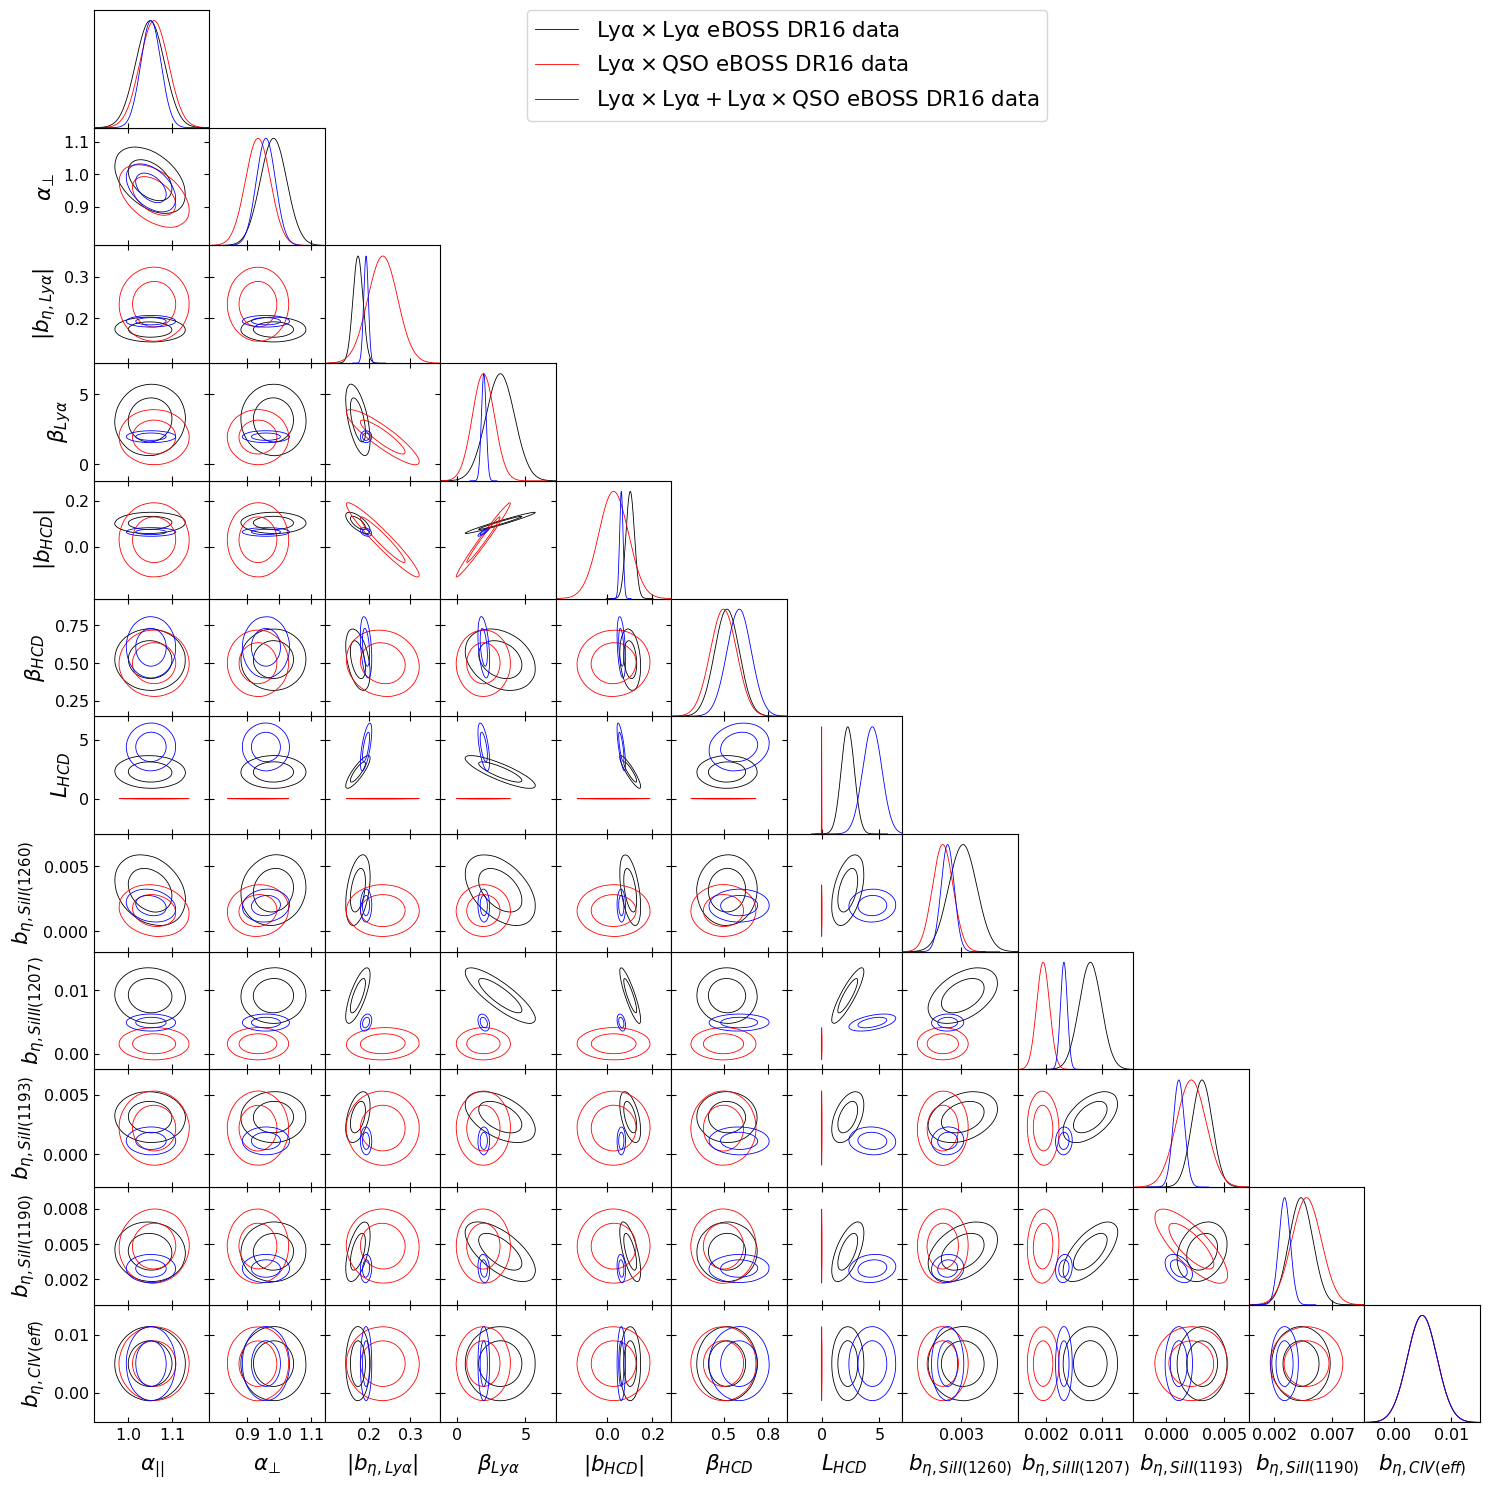

In [105]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
'''
pars_all = ['ap', 'at', 'bias_eta_LYA', 'beta_LYA', 'bias_hcd', 'beta_hcd', 'L0_hcd',
 'drp_QSO', 'sigma_velo_disp_lorentz_QSO', 'bias_eta_SiII(1260)',
 'bias_eta_SiIII(1207)', 'bias_eta_SiII(1193)', 'bias_eta_SiII(1190)',
 'bias_eta_CIV(eff)', 'BB-lyaxlya-0-broadband_sky-scale-sky',
 'BB-lyaxlya-0-broadband_sky-sigma-sky', 'qso_rad_strength']
'''
#[ 'bias_eff', 'bias_eta_LYA', 'beta_LYA']
pars_all = ['ap', 'at', 'bias_eta_LYA', 'beta_LYA', 'bias_hcd', 'beta_hcd', 'L0_hcd',
  'bias_eta_SiII(1260)',
 'bias_eta_SiIII(1207)', 'bias_eta_SiII(1193)', 'bias_eta_SiII(1190)',
 'bias_eta_CIV(eff)', ]
g.triangle_plot([chain_cf_data_dr16, chain_xcf_data_dr16,chain_cfxcf_data_dr16], pars_all, filled=False,
               legend_labels=[r'$\rm{Ly}\alpha\times\rm{Ly}\alpha$ eBOSS DR16 data', r'$\rm{Ly}\alpha\times\rm{QSO}$ eBOSS DR16 data',r'$\rm{Ly}\alpha\times\rm{Ly}\alpha+\rm{Ly}\alpha\times\rm{QSO}$ eBOSS DR16 data'],
               param_limits={'L0_hcd':[-3,7]})
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_data_dr16.pdf', bbox_inches='tight')

In [87]:
res_cf_data_DESI, chain_cf_data_DESI = get_res_data('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/DESI_data/EDR/fitter/auto_v6.fits', lyb=False, cross=False)
res_xcf_data_DESI, chain_xcf_data_DESI = get_res_data('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/DESI_data/EDR/fitter/cross_v6.fits', auto=False,lyb=False, cross=True)
res_cfxcf_data_DESI, chain_cfxcf_data_DESI = get_res_data('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/DESI_data/EDR/fitter/comb_baseline_v6.fits', lyb=False, cross=False)

['bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'beta_hcd' 'L0_hcd'
 'bias_eta_SiII(1260)' 'bias_eta_SiIII(1207)' 'bias_eta_SiII(1193)'
 'bias_eta_SiII(1190)' 'bao_amp']
Removed no burn in
['bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'beta_hcd' 'L0_hcd' 'drp_QSO'
 'sigma_velo_disp_lorentz_QSO' 'bias_eta_SiII(1260)'
 'bias_eta_SiIII(1207)' 'bias_eta_SiII(1193)' 'bias_eta_SiII(1190)'
 'bao_amp']
Removed no burn in
['bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'beta_hcd' 'L0_hcd' 'drp_QSO'
 'sigma_velo_disp_lorentz_QSO' 'bias_eta_SiII(1260)'
 'bias_eta_SiIII(1207)' 'bias_eta_SiII(1193)' 'bias_eta_SiII(1190)'
 'qso_rad_strength' 'bao_amp']
Removed no burn in


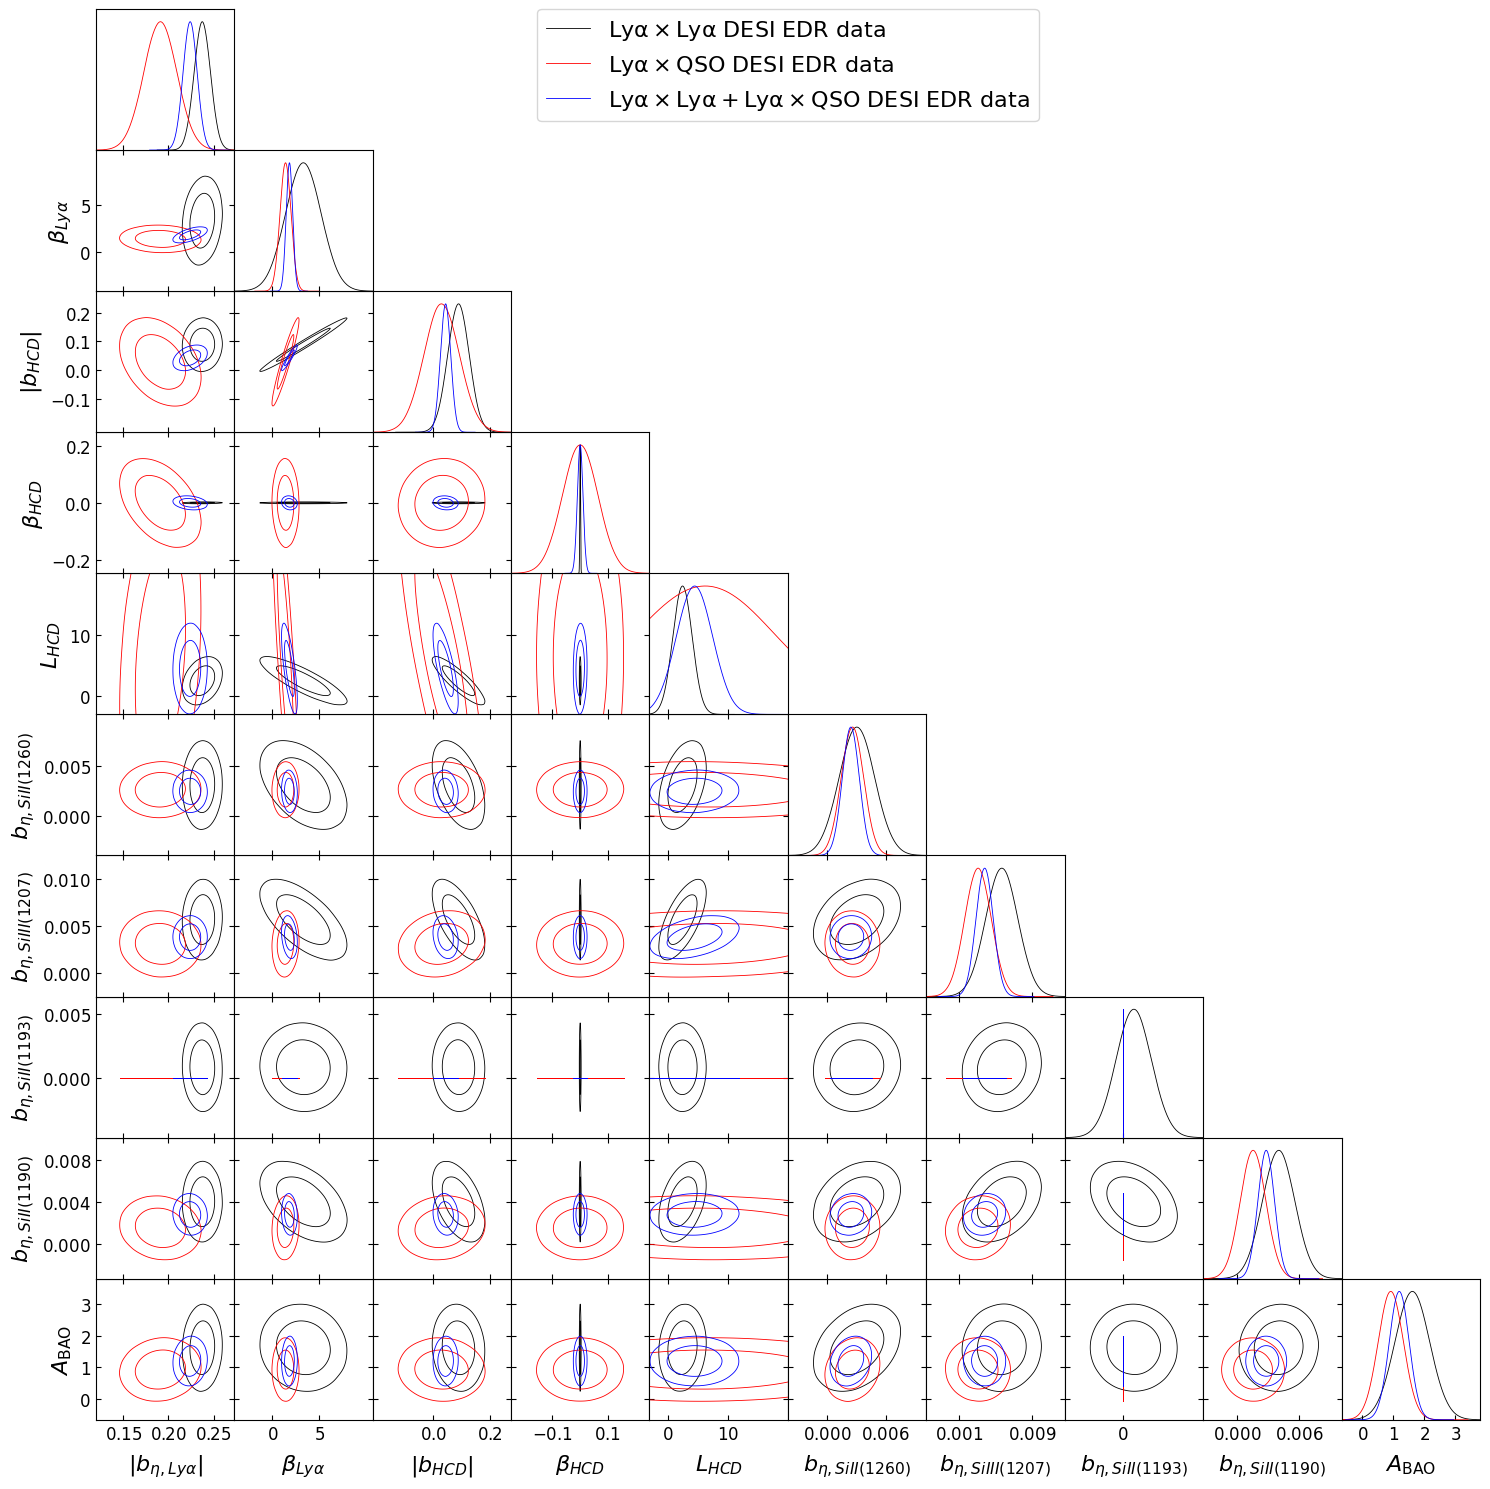

In [104]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
'''
pars_all = ['ap', 'at', 'bias_eta_LYA', 'beta_LYA', 'bias_hcd', 'beta_hcd', 'L0_hcd',
 'drp_QSO', 'sigma_velo_disp_lorentz_QSO', 'bias_eta_SiII(1260)',
 'bias_eta_SiIII(1207)', 'bias_eta_SiII(1193)', 'bias_eta_SiII(1190)',
 'bias_eta_CIV(eff)', 'BB-lyaxlya-0-broadband_sky-scale-sky',
 'BB-lyaxlya-0-broadband_sky-sigma-sky', 'qso_rad_strength']
'''
#[ 'bias_eff', 'bias_eta_LYA', 'beta_LYA']
pars_all = ['bias_eta_LYA', 'beta_LYA', 'bias_hcd', 'beta_hcd', 'L0_hcd',
  'bias_eta_SiII(1260)',
 'bias_eta_SiIII(1207)', 'bias_eta_SiII(1193)', 'bias_eta_SiII(1190)',
  'bao_amp']
g.triangle_plot([chain_cf_data_DESI, chain_xcf_data_DESI,chain_cfxcf_data_DESI], pars_all, filled=False,
               legend_labels=[r'$\rm{Ly}\alpha\times\rm{Ly}\alpha$ DESI EDR data', r'$\rm{Ly}\alpha\times\rm{QSO}$ DESI EDR data',r'$\rm{Ly}\alpha\times\rm{Ly}\alpha+\rm{Ly}\alpha\times\rm{QSO}$ DESI EDR data'],
               param_limits={'L0_hcd':[-3,20]})
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_data_DESI.pdf', bbox_inches='tight')

In [96]:
res_cf_data_dr16_fixHCD, chain_cf_data_dr16_fixHCD = get_res_data('/global/homes/t/tanting/DESI_analysis/Thesis/Calum_scripts/fits_dr16/dr16_auto_fixHCD.fits', lyb=False, cross=False)
res_cfxcf_data_dr16_fixHCD, chain_cfxcf_data_dr16_fixHCD = get_res_data('/global/homes/t/tanting/DESI_analysis/Thesis/Calum_scripts/fits_dr16/dr16_official_lya_only_fixHCD.fits', lyb=False, cross=False)
res_cf_data_DESI_fixHCD, chain_cf_data_DESI_fixHCD = get_res_data('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/DESI_data/EDR/fitter/auto_v6_fixHCD.fits', lyb=False, cross=False)
res_cfxcf_data_DESI_fixHCD, chain_cfxcf_data_DESI_fixHCD = get_res_data('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/DESI_data/EDR/fitter/comb_baseline_v6_fixHCD.fits', lyb=False, cross=False)

['bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'bias_eta_SiII(1260)'
 'bias_eta_SiIII(1207)' 'bias_eta_SiII(1193)' 'bias_eta_SiII(1190)'
 'bias_eta_CIV(eff)' 'BB-lyaxlya-0-broadband_sky-scale-sky'
 'BB-lyaxlya-0-broadband_sky-sigma-sky']
Removed no burn in
['bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'drp_QSO'
 'sigma_velo_disp_lorentz_QSO' 'bias_eta_SiII(1260)'
 'bias_eta_SiIII(1207)' 'bias_eta_SiII(1193)' 'bias_eta_SiII(1190)'
 'bias_eta_CIV(eff)' 'BB-lyaxlya-0-broadband_sky-scale-sky'
 'BB-lyaxlya-0-broadband_sky-sigma-sky' 'qso_rad_strength']
Removed no burn in
['bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'bias_eta_SiII(1260)'
 'bias_eta_SiIII(1207)' 'bias_eta_SiII(1193)' 'bias_eta_SiII(1190)'
 'bao_amp']
Removed no burn in
['bias_eta_LYA' 'beta_LYA' 'bias_hcd' 'drp_QSO'
 'sigma_velo_disp_lorentz_QSO' 'bias_eta_SiII(1260)'
 'bias_eta_SiIII(1207)' 'bias_eta_SiII(1193)' 'bias_eta_SiII(1190)'
 'qso_rad_strength' 'bao_amp']
Removed no burn in


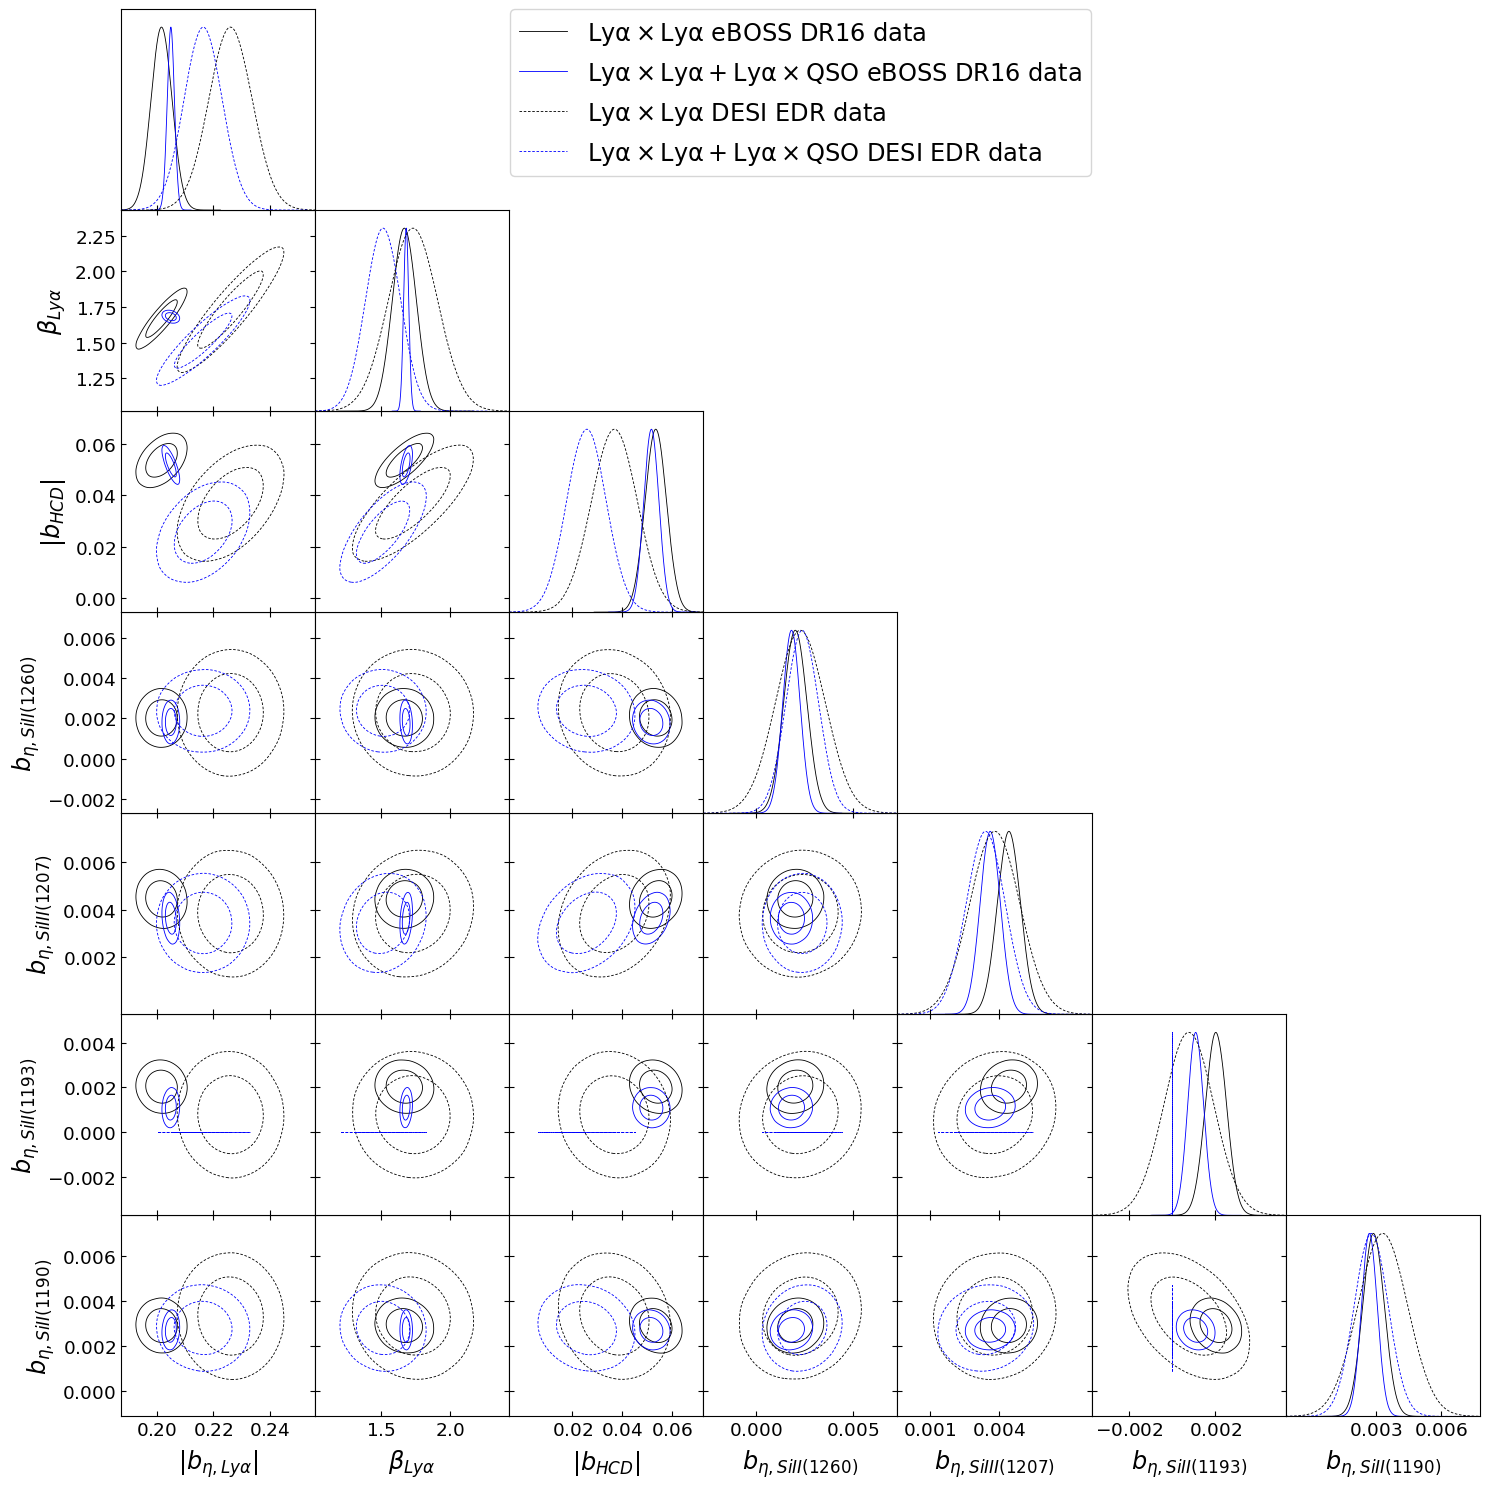

In [103]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
'''
pars_all = ['ap', 'at', 'bias_eta_LYA', 'beta_LYA', 'bias_hcd', 'beta_hcd', 'L0_hcd',
 'drp_QSO', 'sigma_velo_disp_lorentz_QSO', 'bias_eta_SiII(1260)',
 'bias_eta_SiIII(1207)', 'bias_eta_SiII(1193)', 'bias_eta_SiII(1190)',
 'bias_eta_CIV(eff)', 'BB-lyaxlya-0-broadband_sky-scale-sky',
 'BB-lyaxlya-0-broadband_sky-sigma-sky', 'qso_rad_strength']
'''
#[ 'bias_eff', 'bias_eta_LYA', 'beta_LYA']
pars_all = ['bias_eta_LYA', 'beta_LYA', 'bias_hcd',
  'bias_eta_SiII(1260)',
 'bias_eta_SiIII(1207)', 'bias_eta_SiII(1193)', 'bias_eta_SiII(1190)']
g.triangle_plot([chain_cf_data_dr16_fixHCD,chain_cfxcf_data_dr16_fixHCD,chain_cf_data_DESI_fixHCD,chain_cfxcf_data_DESI_fixHCD], pars_all, filled=False,
               legend_labels=[r'$\rm{Ly}\alpha\times\rm{Ly}\alpha$ eBOSS DR16 data',r'$\rm{Ly}\alpha\times\rm{Ly}\alpha+\rm{Ly}\alpha\times\rm{QSO}$ eBOSS DR16 data',r'$\rm{Ly}\alpha\times\rm{Ly}\alpha$ DESI EDR data',r'$\rm{Ly}\alpha\times\rm{Ly}\alpha+\rm{Ly}\alpha\times\rm{QSO}$ DESI EDR data'],
               param_limits={'L0_hcd':[-3,20]}, colors=['black', 'blue','black', 'blue'], ls=['-','-','--', '--', '--', '--'],
               line_args=[{'color':'black', 'ls':'-'},{'color':'blue', 'ls':'-'},{'color':'black', 'ls':'--'},{'color':'blue', 'ls':'--'}])
plt.savefig('/global/project/projectdirs/desi/mocks/lya_forest/develop/saclay/hcd_ting/paper_hcd_model/figures/triangle_data_DESI+DR16_fixHCD.pdf', bbox_inches='tight')

In [3]:
res_auto_v1, chain_auto_v1 = get_res('/global/cfs/projectdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/vega/lya_lya/output_fitter/lyalya_lyalya-auto_v1.fits', lyb=False, cross=False)
#res_auto_v2, chain_auto_v2 = get_res('/global/cfs/projectdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/vega/lya_lya/output_fitter/lyalya_lyalya-auto_v2.fits', lyb=False, cross=False)
#res_auto_v3, chain_auto_v3 = get_res('/global/cfs/projectdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/vega/lya_lya/output_fitter/lyalya_lyalya-auto_v3.fits', lyb=False, cross=False)

Removed no burn in
Removed no burn in
Removed no burn in


In [4]:
res_auto_jfs, chain_auto_jfs = get_res('/global/cfs/projectdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/vega/lya_lya/output_fitter/lyalya_lyalya-auto_j_fs_v1.fits', lyb=False, cross=False)

Removed no burn in


In [5]:
res_auto_now_v1, chain_auto_now_v1 = get_res('/global/cfs/projectdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/vega/lya_lya/output_fitter/lyalya_lyalya-auto_now_v1.fits', lyb=False, cross=False)
res_auto_j_v1, chain_auto_j_v1 = get_res('/global/cfs/projectdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/vega/lya_lya/output_fitter/lyalya_lyalya-auto_j_v1.fits', lyb=False, cross=False)


Removed no burn in
Removed no burn in


In [ ]:
res_auto_fit_v1, chain_auto_fit_v1 = get_res('/global/cfs/projectdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/vega/lya_lya/output_fitter/lyalya_lyalya-auto_fit_v1.fits', lyb=False, cross=False)
res_auto_true_v1, chain_auto_true_v1 = get_res('/global/cfs/projectdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/vega/lya_lya/output_fitter/lyalya_lyalya-auto_true_v1.fits', lyb=False, cross=False)
res_auto_true_orig_v1, chain_auto_true_orig_v1 = get_res('/global/cfs/projectdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/vega/lya_lya/output_fitter/lyalya_lyalya-auto_true_orig_v1.fits', lyb=False, cross=False)


Removed no burn in
Removed no burn in
Removed no burn in


In [7]:
vega_auto_v1 = VegaInterface('/global/cfs/projectdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/vega/lya_lya/main-auto_v1.ini')
vega_auto_v2 = VegaInterface('/global/cfs/projectdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/vega/lya_lya/main-auto_v2.ini')
vega_auto_v3 = VegaInterface('/global/cfs/projectdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/vega/lya_lya/main-auto_v3.ini')

INFO: reading input Pk /global/u1/a/acuceu/lib/mocks/vega/vega/models/PlanckDR12/PlanckDR12.fits
Reading data file /global/cfs/cdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/correlations/stack_0_5/cf_lya_lya_0_10_desi-3.5-4_2.4A-exp.fits.gz



/global/homes/a/acuceu/.conda/envs/mocks/lib/python3.8/site-packages/mcfit/mcfit.py:157: UserWarning: input must be log-spaced
  warnings.warn("input must be log-spaced")


INFO: reading input Pk /global/u1/a/acuceu/lib/mocks/vega/vega/models/PlanckDR12/PlanckDR12.fits
Reading data file /global/cfs/cdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/correlations/stack_0_5/cf_lya_lya_0_10_desi-3.5-4_2.4A-exp.fits.gz

INFO: reading input Pk /global/u1/a/acuceu/lib/mocks/vega/vega/models/PlanckDR12/PlanckDR12.fits
Reading data file /global/cfs/cdirs/desi/users/acuceu/picca_on_mocks_v9.0/global/desi-3-raw/correlations/stack_0_5/cf_lya_lya_0_10_desi-3.5-4_2.4A-exp.fits.gz



In [8]:
vega_auto_v1.sample_params

{'limits': {'ap': (0.01, 2.0),
  'at': (0.01, 2.0),
  'bias_LYA': (-2.0, 0.0),
  'beta_LYA': (0.0, 5.0),
  'par_sigma_smooth': (0.0, 10.0),
  'per_sigma_smooth': (0.0, 10.0)},
 'values': {'ap': 1.0,
  'at': 1.0,
  'bias_LYA': -0.1080535626122222,
  'beta_LYA': 1.67,
  'par_sigma_smooth': 2.4,
  'per_sigma_smooth': 2.4},
 'errors': {'ap': 0.1,
  'at': 0.1,
  'bias_LYA': 0.01,
  'beta_LYA': 0.1,
  'par_sigma_smooth': 0.1,
  'per_sigma_smooth': 0.1},
 'fix': {'ap': False,
  'at': False,
  'bias_LYA': False,
  'beta_LYA': False,
  'par_sigma_smooth': False,
  'per_sigma_smooth': False}}

In [20]:
pars = vega_auto_v1.params
pars['peak'] = False
pk_model = vega_auto_v1.models['lyalya_lyalya'].Pk_core.compute(vega_auto_v1.fiducial['pk_full'], pars)

ell = 0
dmuk = vega_auto_v1.models['lyalya_lyalya'].PktoXi.dmuk
legendre_pk = vega_auto_v1.models['lyalya_lyalya'].PktoXi.legendre_pk[ell]
pk_ell = np.sum(dmuk * legendre_pk * pk_model, axis=0) * (2 * ell + 1)

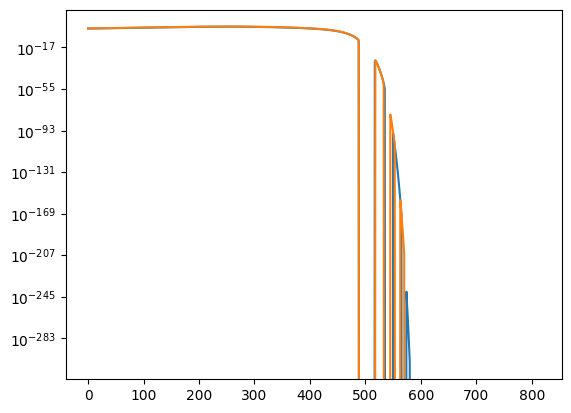

In [9]:
bestfit_auto_v1 = {key: res_auto_v1['pars'][key]['val'] for key in res_auto_v1['pars']}
bestfit_auto_v2 = {key: res_auto_v2['pars'][key]['val'] for key in res_auto_v2['pars']}
bestfit_auto_v3 = {key: res_auto_v3['pars'][key]['val'] for key in res_auto_v3['pars']}

In [10]:
model_auto_v1 = vega_auto_v1.compute_model(bestfit_auto_v1)
model_auto_v2 = vega_auto_v2.compute_model(bestfit_auto_v2)
model_auto_v3 = vega_auto_v3.compute_model(bestfit_auto_v3)

/global/homes/a/acuceu/.conda/envs/mocks/lib/python3.8/site-packages/mcfit/mcfit.py:157: UserWarning: input must be log-spaced
  warnings.warn("input must be log-spaced")
/global/homes/a/acuceu/.conda/envs/mocks/lib/python3.8/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "
/global/homes/a/acuceu/.conda/envs/mocks/lib/python3.8/site-packages/mcfit/mcfit.py:157: UserWarning: input must be log-spaced
  warnings.warn("input must be log-spaced")


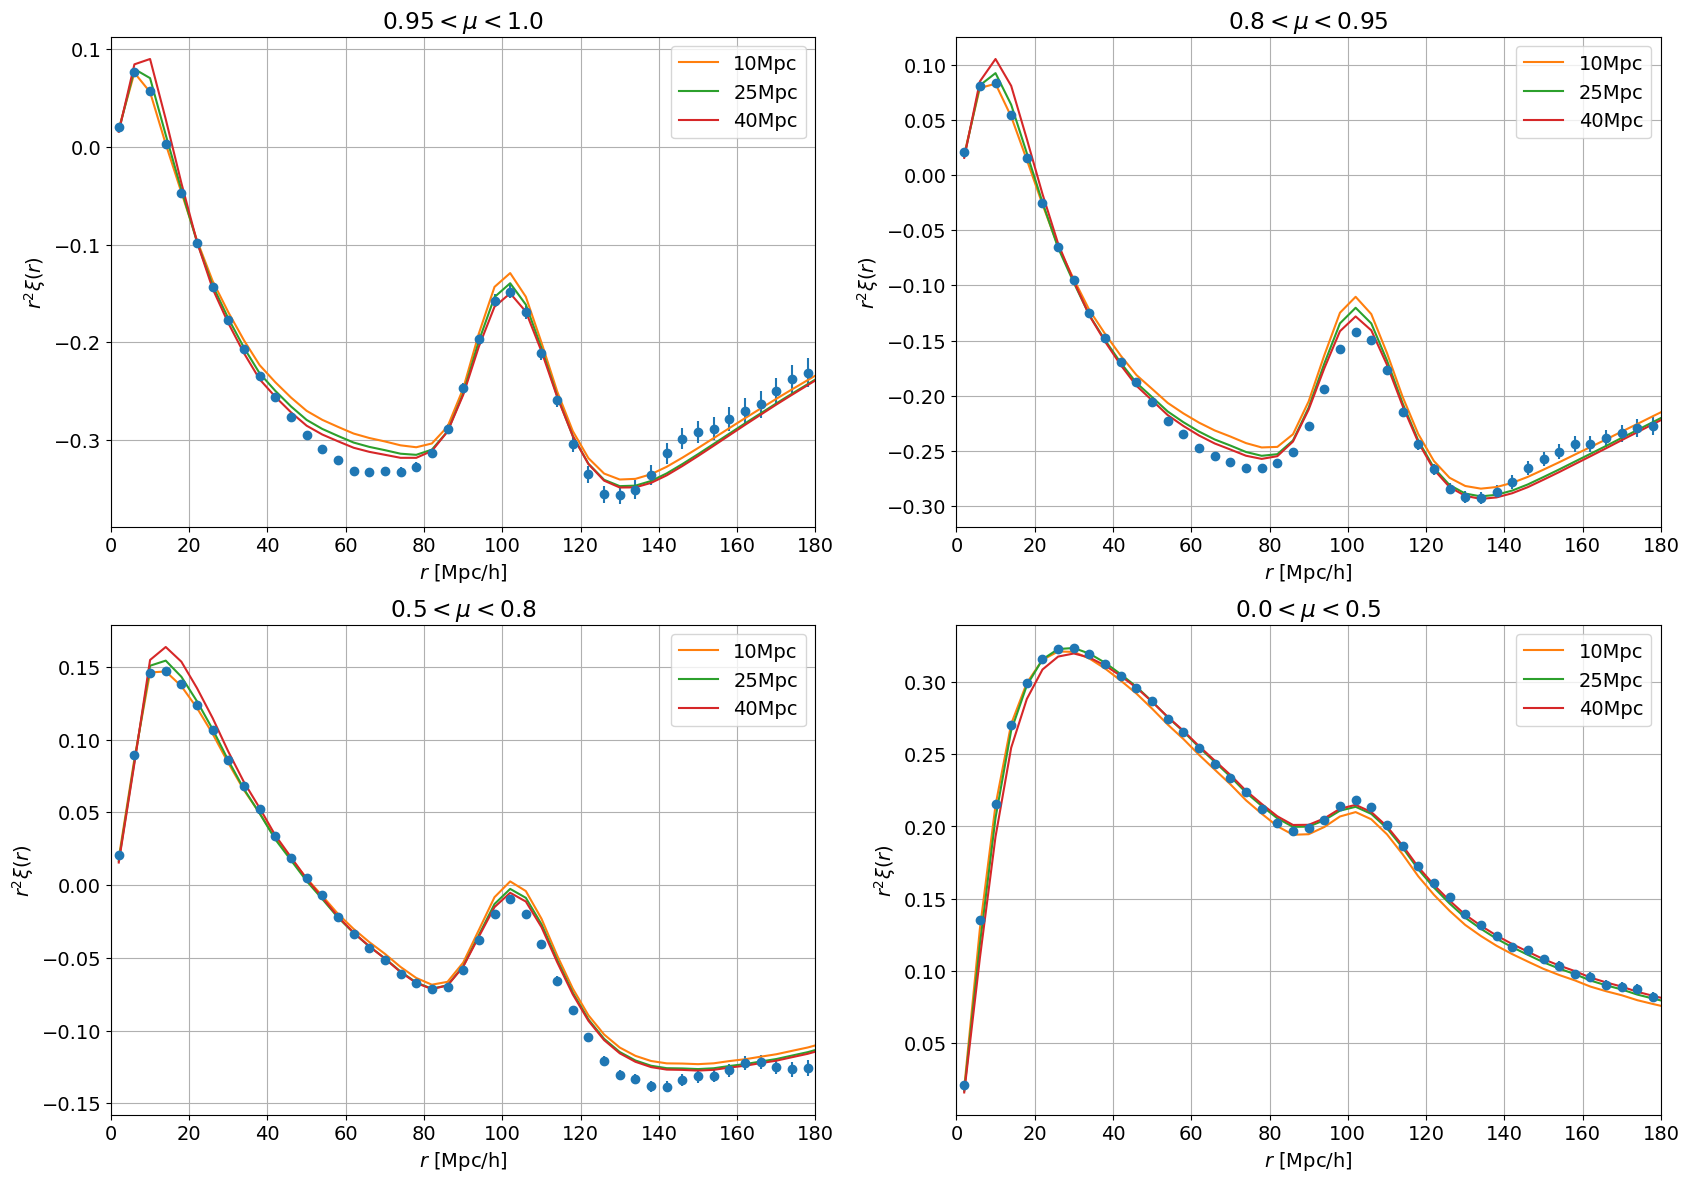

In [14]:
vega_auto_v1.plots.plot_4wedges(models=[model_auto_v1, model_auto_v2, model_auto_v3], labels=['10Mpc', '25Mpc', '40Mpc']);

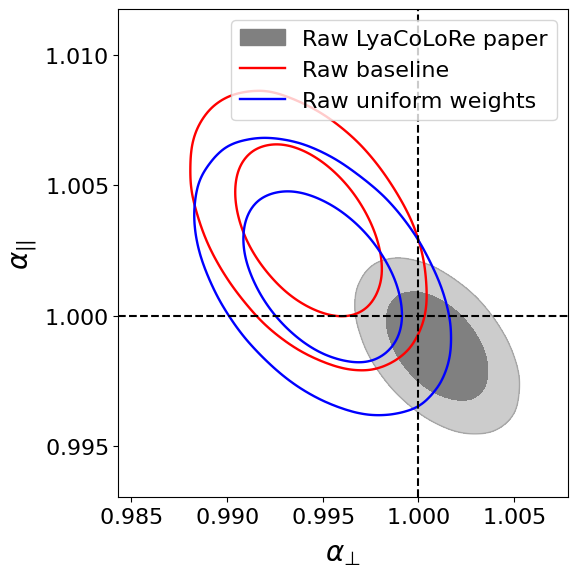

In [36]:
g = getdist.plots.getSubplotPlotter(width_inch=6)
g.settings.fontsize = 16
g.settings.legend_fontsize = 16
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
# pars_all = ['ap', 'at', 'bias_LYA', 'beta_LYA', 'par_sigma_smooth', 'per_sigma_smooth']

g.plot_2d([chain_auto_j_v1, chain_auto_v1, chain_auto_now_v1], ['at', 'ap'], filled=[True, False, False])

g.add_legend(['Raw LyaCoLoRe paper', 'Raw baseline', 'Raw uniform weights'])
g.fig.axes[0].axvline(1, c='k', ls='--')
g.fig.axes[0].axhline(1, c='k', ls='--')

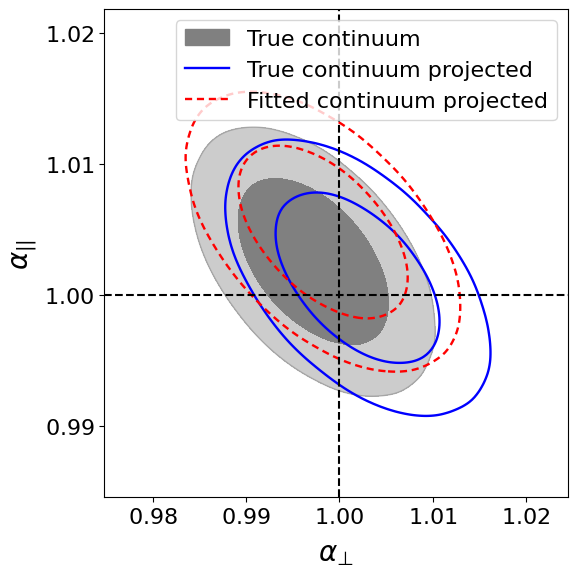

In [46]:
g = getdist.plots.getSubplotPlotter(width_inch=6)
g.settings.fontsize = 16
g.settings.legend_fontsize = 16
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
# pars_all = ['ap', 'at', 'bias_LYA', 'beta_LYA', 'par_sigma_smooth', 'per_sigma_smooth']

g.plot_2d([chain_auto_true_orig_v1, chain_auto_true_v1, chain_auto_fit_v1], ['at', 'ap'], filled=[True, False, False],
         colors=['gray', 'b', 'r'], ls=['-', '-', '--'])

g.add_legend(['True continuum', 'True continuum projected', 'Fitted continuum projected'])
g.fig.axes[0].axvline(1, c='k', ls='--')
g.fig.axes[0].axhline(1, c='k', ls='--')

In [11]:
?vega_auto_v1.plots.plot_4wedges

Signature:
vega_auto_v1.plots.plot_4wedges(
    mu_bins=(0, 0.5, 0.8, 0.95, 1),
    models=None,
    cov_mat=None,
    labels=None,
    data=None,
    cross_flag=False,
    corr_name='lyalya_lyalya',
    models_only=False,
    data_only=False,
    data_label=None,
    fig=None,
    **kwargs,
)
Docstring:
Plot the correlations into four wedges defined by the limits in mu_bins

Parameters
----------
mu_bins : tuple, optional
    Limits of mu bins that define the two wedges, by default (0, 0.5, 1)
models : List[array] or List[dict], optional
    List of models to plot, by default None
cov_mat : array or dict, optional
    Covariance matrix as an array or a dictionary of components, by default None
labels : List[str], optional
    List of labels for the models, by default None
data : array or dict, optional
    Data vector as an array or a dictionary of components, by default None
cross_flag : bool, optional
    Whether the wedge is for the cross-correlation, by default False
corr_name : s

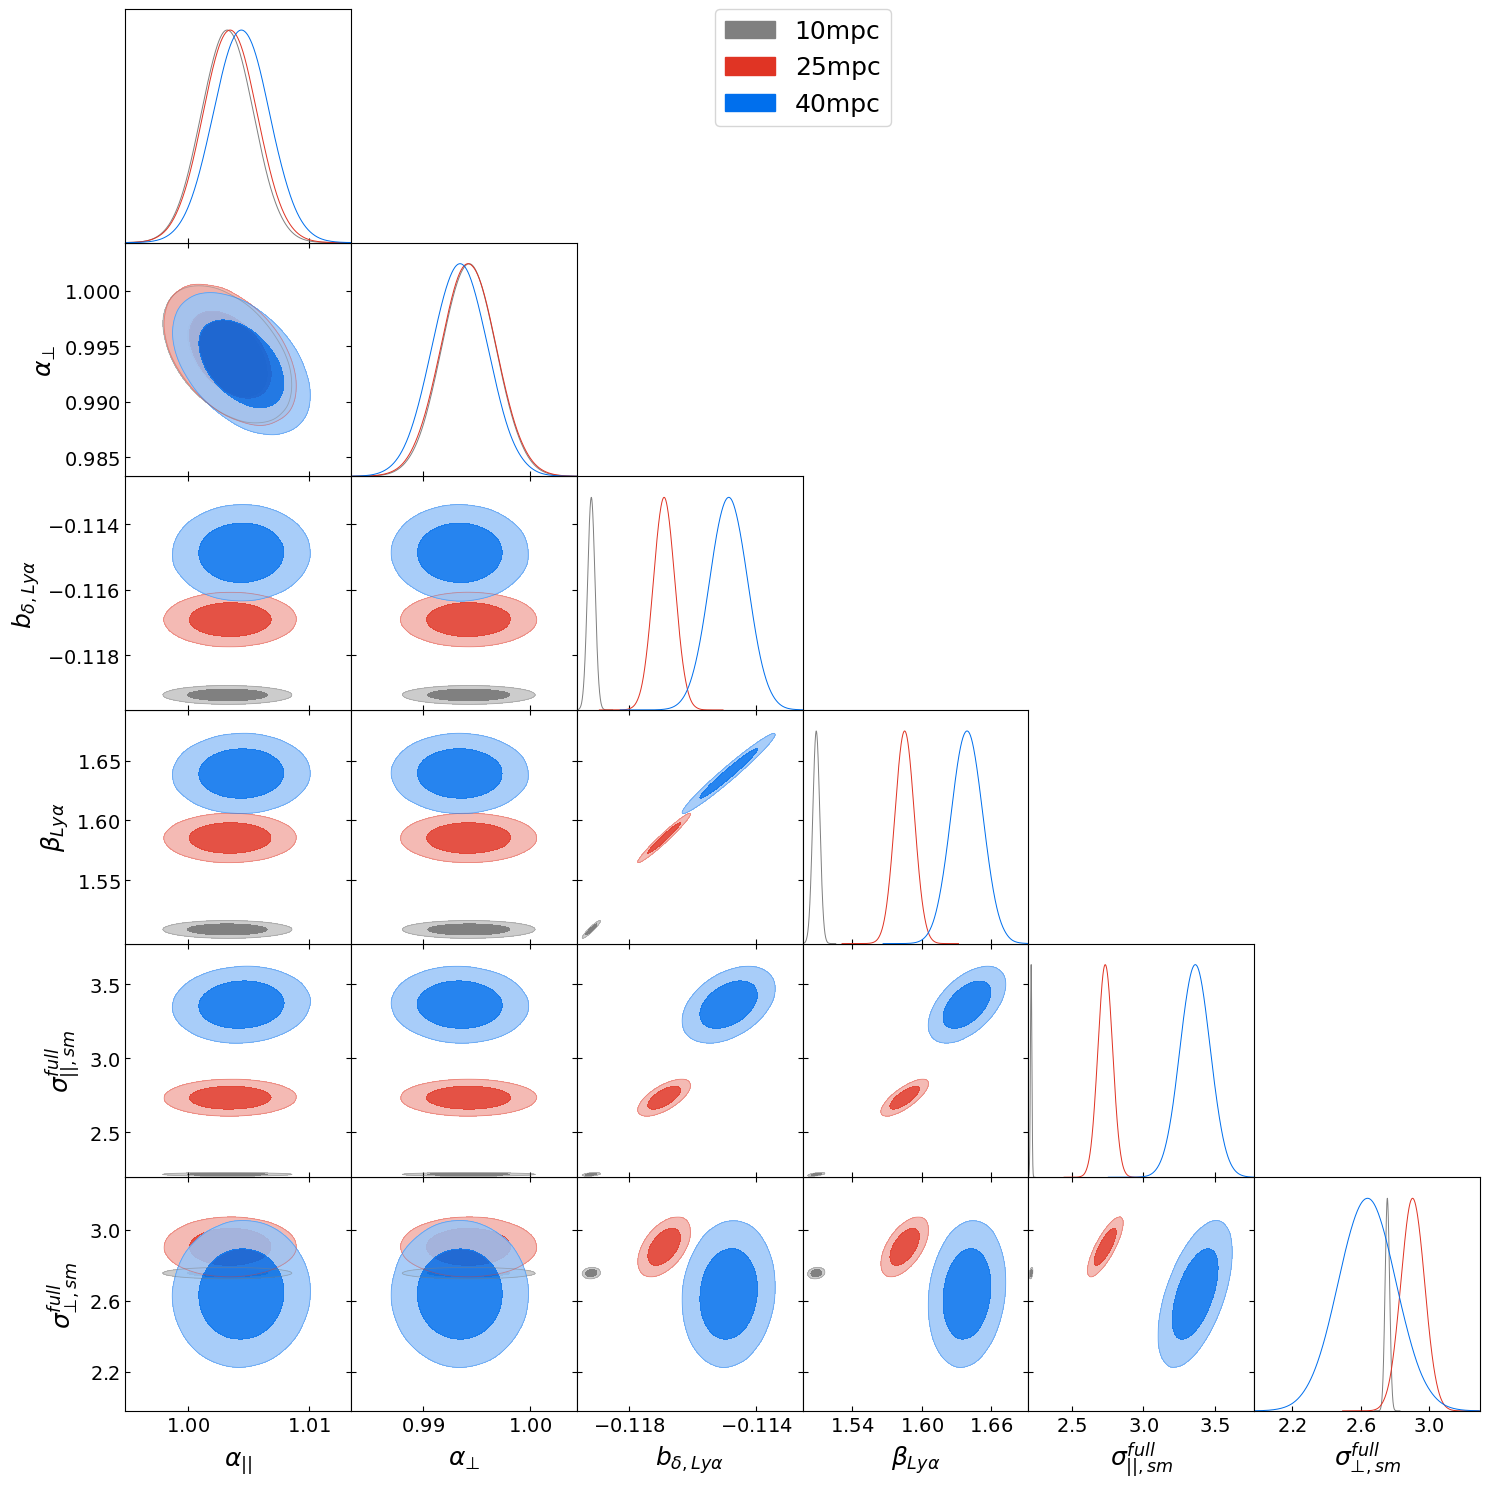

In [8]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
pars_all = ['ap', 'at', 'bias_LYA', 'beta_LYA', 'par_sigma_smooth', 'per_sigma_smooth']

g.triangle_plot([chain_auto_v1, chain_auto_v2, chain_auto_v3], pars_all, filled=True,
               legend_labels=['10mpc', '25mpc', '40mpc'],
               param_limits={'alpha':[0.9,1.1]})

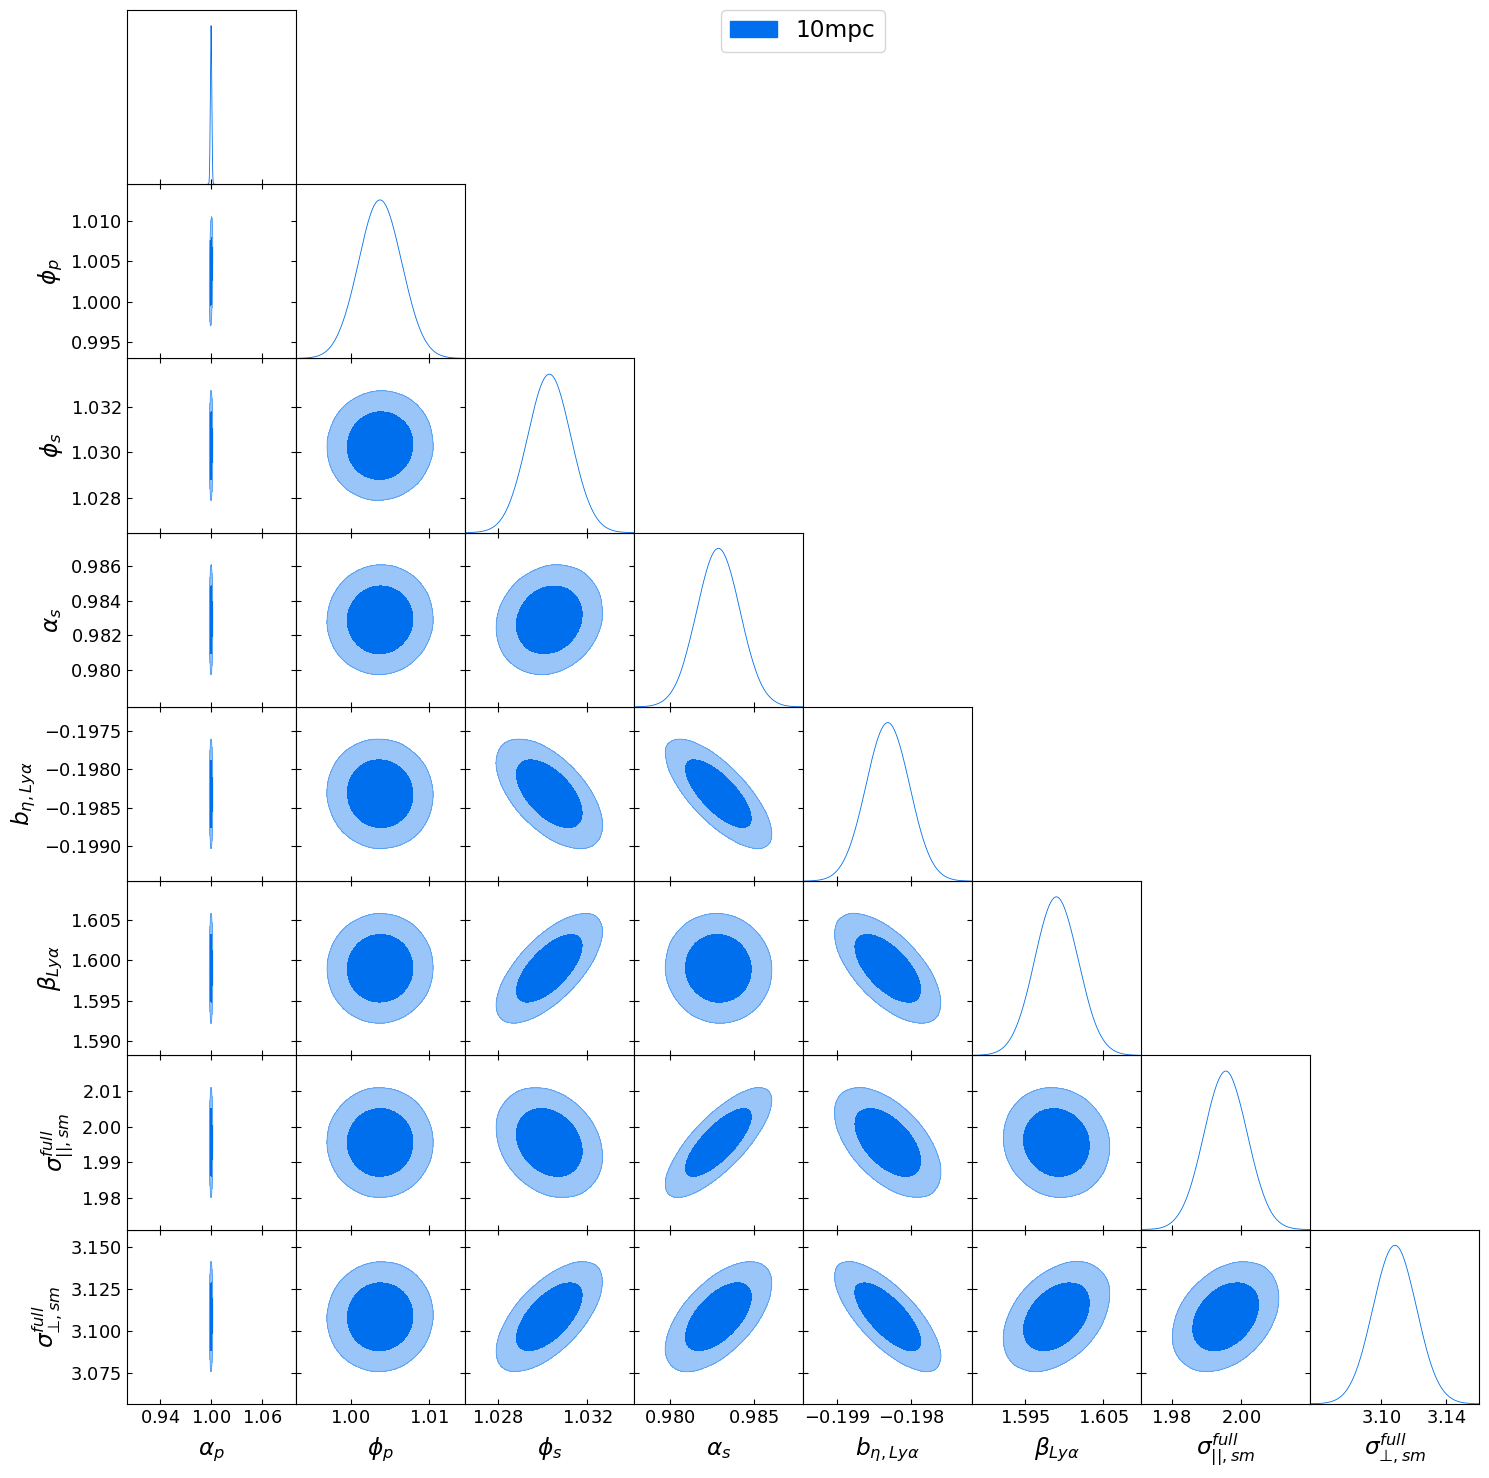

In [25]:
g = getdist.plots.getSubplotPlotter(width_inch=15)
g.settings.fontsize = 16
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20

# pars = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth']
# pars = ['phi_smooth', 'sigma_velo_disp_lorentz_QSO', 'sigma_velo_disp_gauss_QSO']
pars_all = ['alpha', 'phi', 'phi_smooth', 'alpha_smooth', 'bias_eta_LYA', 'beta_LYA', 'par_sigma_smooth', 'per_sigma_smooth']

g.triangle_plot([chain_auto_jfs], pars_all, filled=True,
               legend_labels=['10mpc', '25mpc', '40mpc'],
               param_limits={'alpha':[0.9,1.1]})